In [233]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           125G         67G         44G         83M         13G         56G
Swap:           15G        165M         15G


In [5]:
#allows to reload modules properly
%load_ext autoreload
%autoreload 2

In [6]:
import sys, os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tqdm import tqdm
import seaborn as sns
import uproot
from uproot_methods.classes.TLorentzVector import TLorentzVectorArray
import os
os.sys.path.append('../../')
import eda_tools
from eda_tools import nicole_tools as nt
from eda_tools import histogram_helper as hh
from eda_tools import utilities as u
from eda_tools import trigger_utilities as tu
from eda_tools import plot_helper as ph
from eda_tools import pyhf_models as pm
from loadNNT import loadNNT
from math import log10
from hepstats.modeling import bayesian_blocks
import pyhf
from pyhf import Model, optimizer
from scipy.stats import ks_2samp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras.backend as K

from keras.models import Model
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.layers.normalization import BatchNormalization
from eda_tools import NN_RW as nn

/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [8]:
from eda_tools import bkg_helper as bh

# Part 1:  Objectives

We want to see if there is a better admixture of 2b-split and 2b-together events to use as the starting sample for the "2b-to-4b" reweighting. So the starting sample would be (100% 2bs + x% of 2bt). My naive suggestion is: 
 

1) take a kinematic variable, Y, compare the unweighted distributions (100% 2bs + x% of 2bt) vs. 4b in the CR, where the (100% 2bs + x% of 2bt) distribution is normalised to have the same events as the 4b one (in the CR). Scan the values of x, say from 0% to 100% (11 points) and for each value of x, calculate the chi^2 between the two distributions. Ultimately choose the value of x=x_min that gives the lowest chi^2 and also keep track of the Delta_chi^2_rel = (chi^2(x=100%) - chi^2(x=x_min))/chi^2(x=100%).

$$\Delta \chi^2_{rel} = \frac{\chi^2_{x=100\%} - \chi^2_{x=x\_min}}{\chi^2_{x=100\%}}$$

 

2) If you have done this, say for 20 variables Y, make a plot of the x_min, weighted with the inverse of the Delta_chi^2_rel and see how this looks. One would use the mean of this distribution as the best x value to use for the admixture. The point of weighting with 1/Delta_chi^2_rel is that you give more weight to distributions where the discrepancy is larger and the improvement in chi^2 is larger with this procedure.
$$\frac{1}{\Delta \chi^2_{rel}}$$

 

3) Check if the chosen x value gives some improvement also in the VR for all the above variables

 

4) Do the NN reweighting and check the size of the shape systematic

# Part 2: Load data

In [9]:
f = uproot.open('/mnt/storage/lborgna/data/data17_NN_100_bootstraps_IQR.fmp.root')

In [10]:
f.keys()

[b'fullmassplane;43', b'fullmassplane;42']

In [11]:
df = f['fullmassplane'].pandas.df()

In [12]:
u.calculatedPhi(df)
u.calculatedRhh(df)

In [13]:
dfCR = df[df.kinematic_region == 2]

In [14]:
dfCR.reset_index(drop=True, inplace = True)

In [15]:
dfCR2b = dfCR[dfCR.ntag==2]

In [16]:
dfCR2b.reset_index(drop = True, inplace = True)

In [17]:
dfCR4b = dfCR[dfCR.ntag >= 4]

In [18]:
dfCR4b.reset_index(drop = True, inplace = True)

In [19]:
df.columns

Index(['run_number', 'event_number', 'mc_sf', 'ntag', 'njets',
       'kinematic_region', 'm_min_dj', 'm_max_dj', 'pairing_score_1',
       'pairing_score_2', 'm_hh_cor', 'm_hh', 'pt_hh', 'dEta_hh', 'X_wt',
       'X_wt_2', 'm_h1', 'E_h1', 'pT_h1', 'eta_h1', 'phi_h1', 'm_h2', 'E_h2',
       'pT_h2', 'eta_h2', 'phi_h2', 'm_h1_j1', 'E_h1_j1', 'pT_h1_j1',
       'eta_h1_j1', 'phi_h1_j1', 'tag_h1_j1', 'quantile_h1_j1', 'angle_h1_j1',
       'm_h1_j2', 'E_h1_j2', 'pT_h1_j2', 'eta_h1_j2', 'phi_h1_j2', 'tag_h1_j2',
       'quantile_h1_j2', 'angle_h1_j2', 'm_h2_j1', 'E_h2_j1', 'pT_h2_j1',
       'eta_h2_j1', 'phi_h2_j1', 'tag_h2_j1', 'quantile_h2_j1', 'angle_h2_j1',
       'm_h2_j2', 'E_h2_j2', 'pT_h2_j2', 'eta_h2_j2', 'phi_h2_j2', 'tag_h2_j2',
       'quantile_h2_j2', 'angle_h2_j2', 'pT_4', 'pT_2', 'eta_i', 'dRjj_1',
       'dRjj_2', 'NN_d24_weight_bstrap_med_17',
       'NN_d24_weight_VRderiv_bstrap_med_17', 'NN_d24_weight_bstrap_IQR_17',
       'NN_d24_weight_VRderiv_bstrap_IQR_17', 'dPhi_h

../../eda_tools/utilities.py:325: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum(np.where( p != 0, p * np.log(p/q), 0))
../../eda_tools/utilities.py:325: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(np.where( p != 0, p * np.log(p/q), 0))


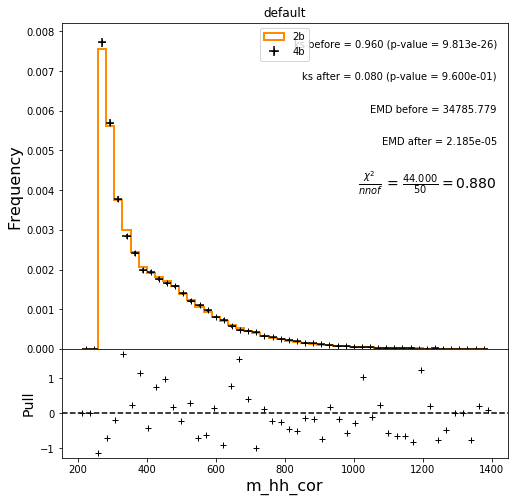

In [20]:
nominal = ph.reweightedHist(dfCR, kinematic_region= 2, feature = 'm_hh_cor', weighted = True, weight_column='NN_d24_weight_bstrap_med_17')

# Part 3: Splitting into the 2b-split and 2b-together datasets

In [21]:
from IPython.display import Image

We define 2b-together the case where both of the b-tags end up in the same Higgs Candidate. Meanwhile the 2b-split is the case where the b-tag ends up in the opposite Higgs candidates. This is shown in the image beloww

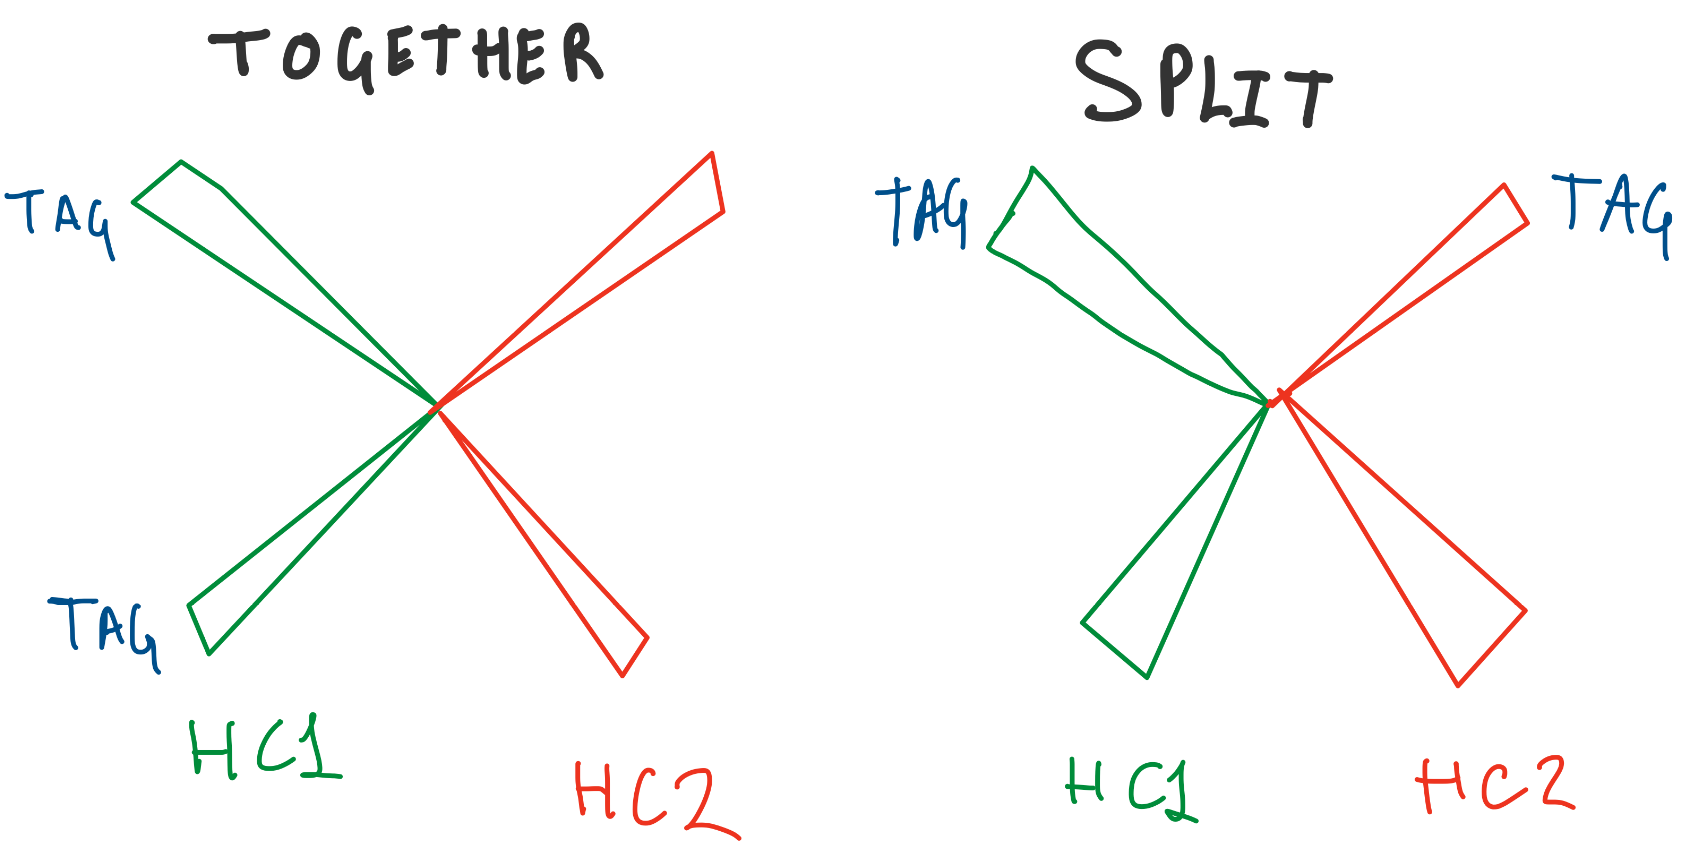

In [22]:
Image("2bsvs2bt.PNG")

To determine how we can select out the 2b-split candidates lets see the possible combinations that we can have

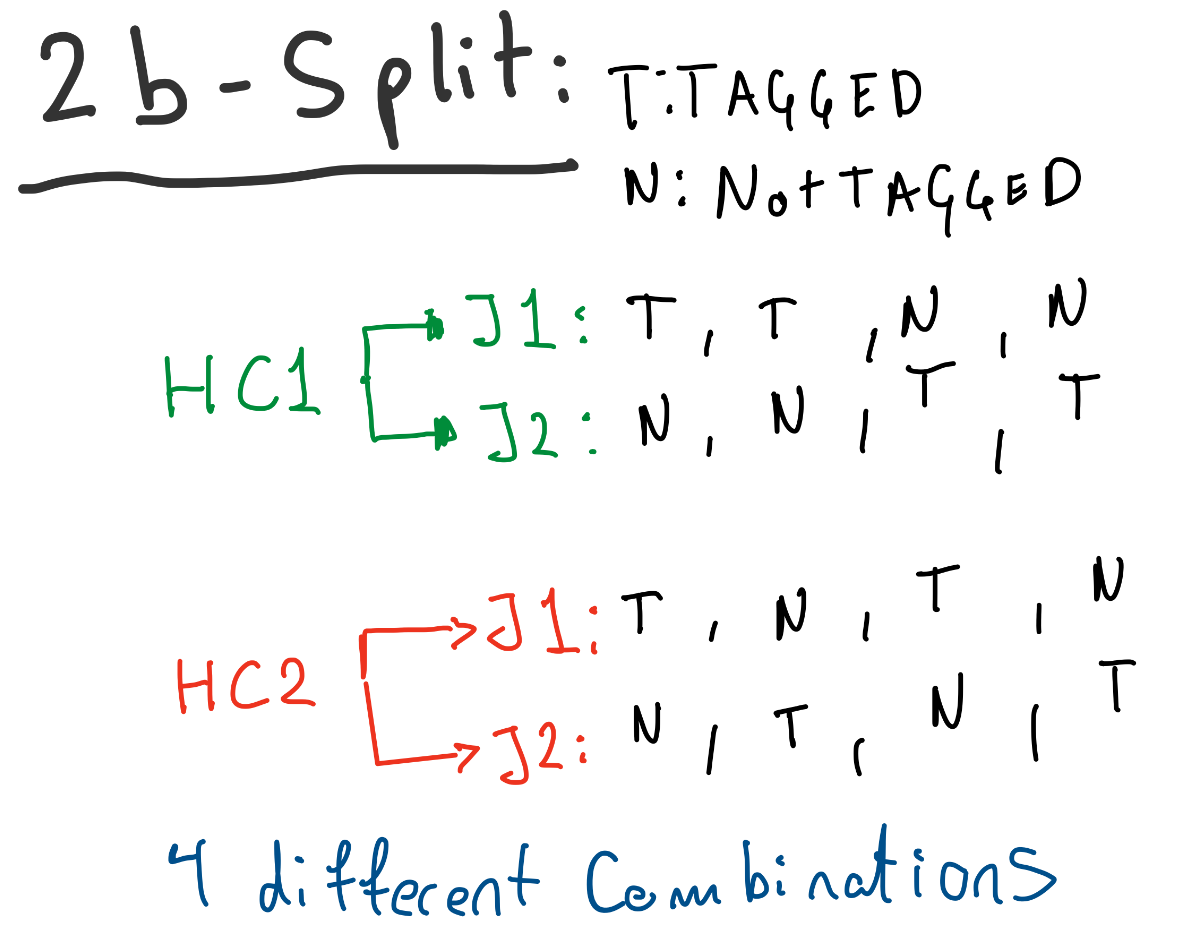

In [23]:
Image("2bscomb.PNG")

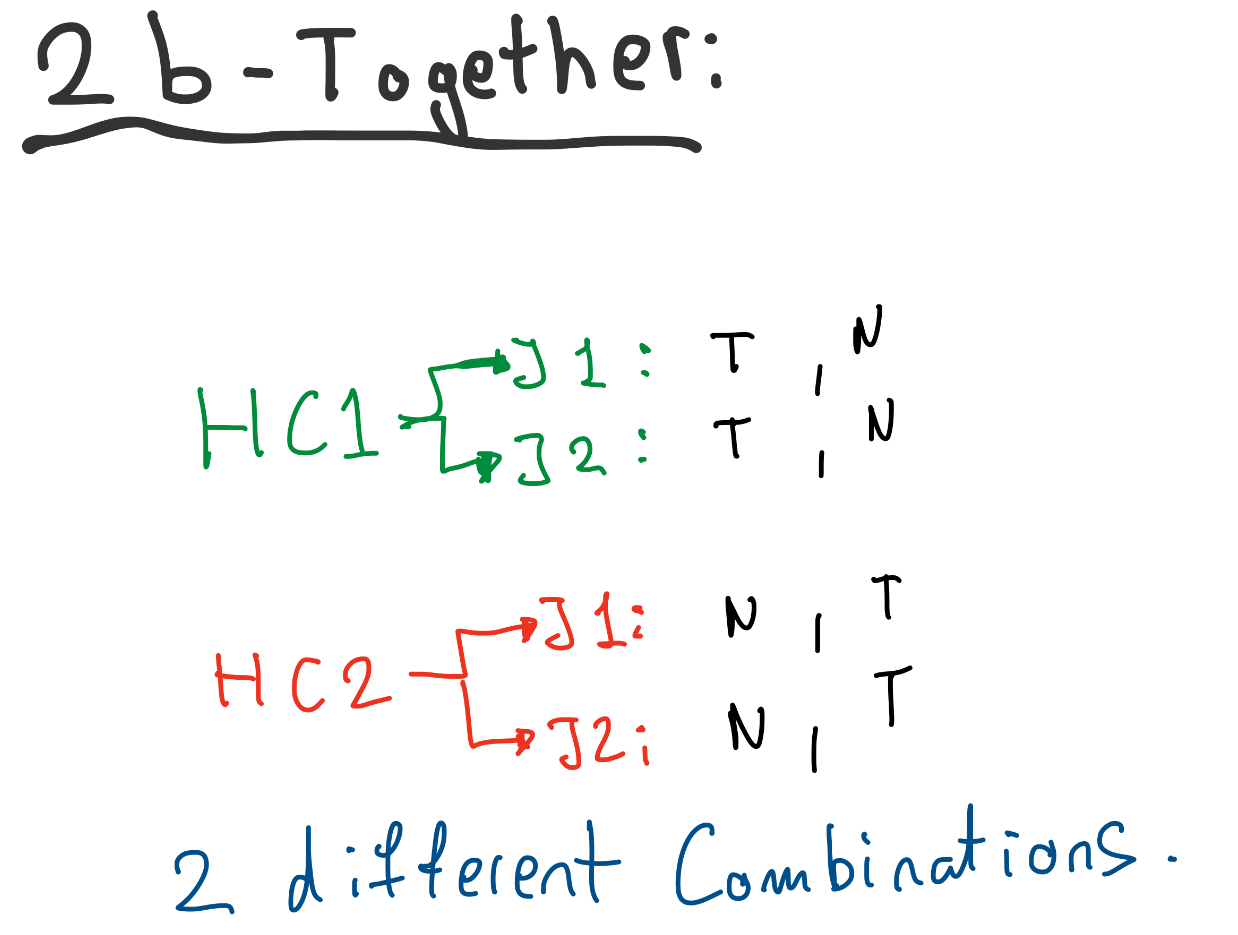

In [24]:
Image("2btcomb.PNG")

With this we can generate the masks for 2b-split and 2b-together

### Part 3.1 2b-split Mask

In [25]:
#Combination1:
comb1 = (df.tag_h1_j1 == True) & (df.tag_h1_j2 == False) & (df.tag_h2_j1 == True) & (df.tag_h2_j2 == False)

In [26]:
comb1.value_counts()

True     2146114
False    1763972
dtype: int64

In [27]:
#Combination2:
comb2 = (df.tag_h1_j1 == True) & (df.tag_h1_j2 == False) & (df.tag_h2_j1 == False) & (df.tag_h2_j2 == True)

In [28]:
comb2.value_counts()

False    3910086
dtype: int64

In [29]:
#Combination3:
comb3 = (df.tag_h1_j1 == False) & (df.tag_h1_j2 == True) & (df.tag_h2_j1 == True) & (df.tag_h2_j2 == False)

In [30]:
comb3.value_counts()

False    3910086
dtype: int64

In [31]:
#Combination4:
comb4 = (df.tag_h1_j1 == False) & (df.tag_h1_j2 == True) & (df.tag_h2_j1 == False) & (df.tag_h2_j2 == True)

In [32]:
comb4.value_counts()

False    3910086
dtype: int64

In [33]:
df[['tag_h1_j1','tag_h1_j2','tag_h2_j1','tag_h2_j2']].head(19)

tag_h1_j1  tag_h1_j2  tag_h2_j1  tag_h2_j2
entry                                            
0           True      False       True      False
1           True      False       True      False
2           True      False       True      False
3           True      False       True      False
4           True      False       True      False
5           True      False       True      False
6           True       True      False      False
7           True      False       True       True
8           True       True      False      False
9           True       True      False      False
10          True      False       True      False
11         False      False       True       True
12          True       True      False      False
13         False      False       True       True
14          True      False       True      False
15          True      False       True      False
16          True      False       True      False
17          True      False       True      False
18          True      False       True      False

In [34]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           125G        100G         15G         73M         10G         23G
Swap:           15G         15G         84K


In [35]:
split_mask = comb1 | comb2 | comb3 | comb4

In [36]:
split_mask.value_counts()

True     2146114
False    1763972
dtype: int64

### Part 3.2 2b-together mask

In [37]:
#comb1:
combT1 = (  (df.tag_h1_j1 == True) &
        (df.tag_h1_j2 == True) &
        (df.tag_h2_j1 == False) &
        (df.tag_h2_j2 == False) )

In [38]:
combT1.value_counts()

False    3199677
True      710409
dtype: int64

In [39]:
#comb2:
combT2 = (  (df.tag_h1_j1 == False) &
        (df.tag_h1_j2 == False) &
        (df.tag_h2_j1 == True) &
        (df.tag_h2_j2 == True) )

In [40]:
combT2.value_counts()

False    3290716
True      619370
dtype: int64

In [41]:
together_mask = combT1 | combT2

In [42]:
together_mask.value_counts()

False    2580307
True     1329779
dtype: int64

Does the size of the split events + together events == to the size of the 2b events in total?

In [43]:
len(df[df.ntag==2])

3475893

In [44]:
len(df[together_mask | split_mask])

3475893

YES IT DOES!!! We MUST BE DOING SOMETHING RIGHT. Let's create a function that for a given dataframe returns the 2b-split mask and the 2b-together mask

In [45]:
def splitMask(df):
    #Combination1:
    comb1 = (df.tag_h1_j1 == True) & (df.tag_h1_j2 == False) & (df.tag_h2_j1 == True) & (df.tag_h2_j2 == False)
    
    #Combination2:
    comb2 = (df.tag_h1_j1 == True) & (df.tag_h1_j2 == False) & (df.tag_h2_j1 == False) & (df.tag_h2_j2 == True)
    
    #Combination3:
    comb3 = (df.tag_h1_j1 == False) & (df.tag_h1_j2 == True) & (df.tag_h2_j1 == True) & (df.tag_h2_j2 == False)

    #Combination4:
    comb4 = (df.tag_h1_j1 == False) & (df.tag_h1_j2 == True) & (df.tag_h2_j1 == False) & (df.tag_h2_j2 == True)
    
    mask = comb1 | comb2 | comb3 | comb4

    return mask
    

In [46]:
def togetherMask(df):
    #comb1:
    combT1 = (  (df.tag_h1_j1 == True) &
                (df.tag_h1_j2 == True) &
                (df.tag_h2_j1 == False) &
                (df.tag_h2_j2 == False) 
             )

    #comb2:
    combT2 = (  (df.tag_h1_j1 == False) &
                (df.tag_h1_j2 == False) &
                (df.tag_h2_j1 == True) &
                (df.tag_h2_j2 == True) 
             )
    
    mask = combT1 | combT2
    
    return mask 

In [47]:
smask = splitMask(df)
tmask = togetherMask(df)

In [48]:
smask.value_counts()

True     2146114
False    1763972
dtype: int64

In [49]:
tmask.value_counts()

False    2580307
True     1329779
dtype: int64

In [50]:
maskCR = df.kinematic_region == 2
mask2b = df.ntag == 2

In [51]:
mask4b = df.ntag >= 4

### Part 3.3 Creating the 2b-split (dfS) and 2b-together (dfT) dataframes in CR

In [52]:
dfS = df[maskCR & mask2b & splitMask(df)]

In [53]:
dfT = df[maskCR & mask2b & togetherMask(df)]

In [54]:
len(dfS) + len(dfT) == len(df[maskCR & mask2b])

True

Ok we'll also need the 4b CR dataframe too

In [55]:
df4b = df[maskCR & mask4b]

In [56]:
len(df4b)

29638

### Part 3.4 Understanding the 2bS and 2bT data

Let's look at what the histogram of m_hh_cor looks like for these 2 dataframes

In [57]:
u.weighted_chisquare(h2b,h4b, np.zeros(len(h2b)), h4b_err)

NameError: name 'h2b' is not defined

In [ ]:
h2b

In [58]:
h4b

NameError: name 'h4b' is not defined

In [59]:
u.chi2(h2b, h4b, nnof = True)

NameError: name 'h2b' is not defined

In [60]:
u.chi2(h2bT, h4b, nnof = True)

NameError: name 'h2bT' is not defined

In [61]:
u.chi2(h2bS, h4b, nnof = True)

NameError: name 'h2bS' is not defined

In [62]:
u.weighted_chisquare(h2bS, h4b, np.zeros(len(h2bS)), np.zeros(len(h4b)))

NameError: name 'h2bS' is not defined

In [63]:
u.weighted_chisquare(h2bT, h4b, np.zeros(len(h2bT)), h4b_err)

NameError: name 'h2bT' is not defined

/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Text(0.5, 1.0, 'comparison of 2bT and 2bS (normalized to N4b)')

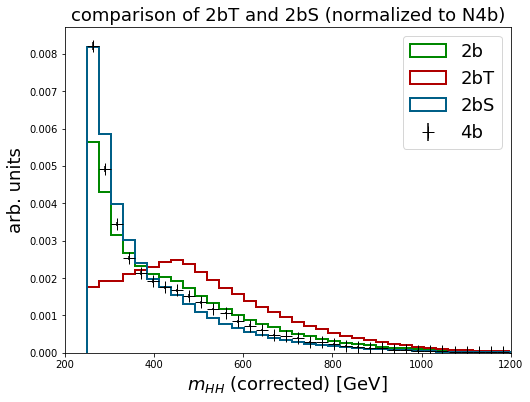

In [64]:
fig = plt.figure(figsize=(8, 6))
h4braw, be = np.histogram(df4b.m_hh_cor, bins = 50, range = (250, 1600), density = 0)

h4b, be = np.histogram(df4b.m_hh_cor, bins = 50, range = (250, 1600), density = 1)
h4b_err = h4b* np.sqrt(h4braw)/h4braw
x = hh.bin_midpoint(be)
plt.errorbar(x, h4b, yerr=h4b_err, fmt='+k', ms = 12, label = '4b')
mu = sum(h4b)/len(dfCR2b)
h2b, _, _ = plt.hist(dfCR2b.m_hh_cor, bins = be, density = 1, lw=2, histtype = 'step', weights = mu *np.ones(len(dfCR2b)), label = '2b')
muT = sum(h4b)/len(dfT)
h2bT, _, _ = plt.hist(dfT.m_hh_cor, bins = be, density = 1, lw = 2, histtype = 'step', weights =  muT * np.ones(len(dfT)), label = '2bT')
muS = sum(h4b)/len(dfS)
h2bS, _, _ = plt.hist(dfS.m_hh_cor, bins = be, density = 1, lw = 2, histtype = 'step', weights = muS * np.ones(len(dfS)), label = '2bS')


plt.legend(fontsize = 18)
plt.xlim((200, 1200))
plt.xlabel('$m_{HH}$ (corrected) [GeV]', fontsize = 18)
plt.ylabel('arb. units', fontsize = 18)
plt.title('comparison of 2bT and 2bS (normalized to N4b)', fontsize = 18)

Legitimately this plot really motivates us to drop the 2bT, it seems that the 2bS alone models things soooo well already. (Maybe lets redo the same plot but focus on the tails)

Text(0.5, 1.0, 'comparison of 2bT and 2bS (normalized to N4b)')

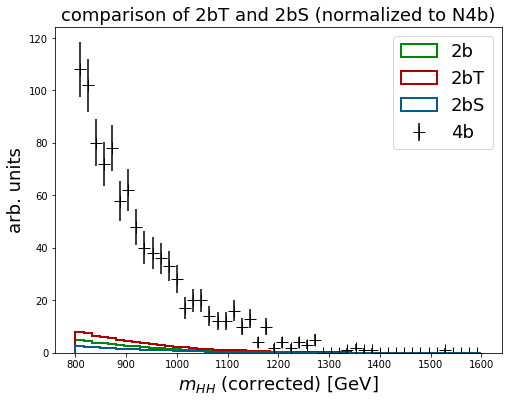

In [65]:
fig = plt.figure(figsize=(8, 6))
h4b, be = np.histogram(df4b.m_hh_cor, bins = 50, range = (800, 1600), density = 0)
h4b_err = np.sqrt(h4b)
x = hh.bin_midpoint(be)
plt.errorbar(x, h4b, yerr=h4b_err, fmt='+k', ms = 12, label = '4b')
mu = sum(h4b)/len(dfCR2b)
h2b, _, _ = plt.hist(dfCR2b.m_hh_cor, bins = be, lw=2, histtype = 'step', weights = mu *np.ones(len(dfCR2b)), label = '2b')
muT = sum(h4b)/len(dfT)
h2bT, _, _ = plt.hist(dfT.m_hh_cor, bins = be, lw = 2, histtype = 'step', weights =  muT * np.ones(len(dfT)), label = '2bT')
muS = sum(h4b)/len(dfS)
h2bS, _, _ = plt.hist(dfS.m_hh_cor, bins = be, lw = 2, histtype = 'step', weights = muS * np.ones(len(dfS)), label = '2bS')
plt.legend(fontsize = 18)
#plt.xlim((200, 1200))
plt.xlabel('$m_{HH}$ (corrected) [GeV]', fontsize = 18)
plt.ylabel('arb. units', fontsize = 18)
plt.title('comparison of 2bT and 2bS (normalized to N4b)', fontsize = 18)

So in the tails neither models it well, but atleast the 2bT helps us get a little bit more statistics

## Part 4: Mixing 2bS + 2bT

This function will mix the 2b-Split dataframe by randomly sampling a certain fraction of 2b-Together events and append them to a new dataframe

In [66]:
def mixSplitTogether(dfS, dfT, f):
    '''
    returns the mixed dataframe of 2b-Split with a certain level of 2b-Together impurities
    df = 100% 2b-Split + f * 2b-Together
    '''
    dfT_sample = dfT.sample(frac = f)
    
    df = dfS.append(dfT_sample)
    
    df.reset_index(drop = True, inplace = True)
    return df
    
    
    

In [67]:
dfM = mixSplitTogether(dfS, dfT, 0.1)

### Part 4.0.1: $\chi^2$ equation

We will be using the following equation for comparing two unweighted histograms


$$ \chi^2 = \frac{1}{MN} \sum_{i=1}^{r}{\frac{(Mn_i - Nm_i)^2}{n_i + m_i}} $$

where $M$ = Total number of events in Histogram 1

$N$ = Total number of events in Histogram 2

$m_i$ events in i-th bin of Histrogram 1

$n_i$ events in i_th bin of Histogram 2

### Part 4.1: Test and verify by adding 50% 2bT

Text(0.5, 1.0, 'comparison of 2bM and 4b (normalized to N4b)')

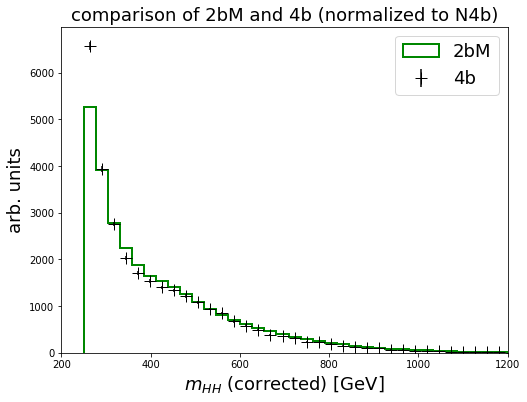

In [68]:
fig = plt.figure(figsize=(8, 6))

h4b, be = np.histogram(df4b.m_hh_cor, bins = 50, range = (250, 1600), density = 0)
h4b_err = np.sqrt(h4b)
x = hh.bin_midpoint(be)
plt.errorbar(x, h4b, yerr=h4b_err, fmt='+k', ms = 12, label = '4b')
N4b = np.sum(h4b)

dfM = mixSplitTogether(dfS, dfT, f=0.5)

mu = N4b/len(dfM)

h2bM, _, _ = plt.hist(dfM.m_hh_cor, bins = be, density = 0,
                      lw=2, histtype = 'step', label = '2bM',
                      weights = mu *np.ones(len(dfM)))


plt.legend(fontsize = 18)
plt.xlim((200, 1200))
plt.xlabel('$m_{HH}$ (corrected) [GeV]', fontsize = 18)
plt.ylabel('arb. units', fontsize = 18)
plt.title('comparison of 2bM and 4b (normalized to N4b)', fontsize = 18)

In [69]:
u.chi2_unweighted(h2bM, f4b)

NameError: name 'f4b' is not defined

So it may not look like it but a 50 % mixture seems to have improved the modelling (prior to reweighting)

### Part 4.2: Loop over a range of mixture

In [70]:
fractions = np.arange(11)/10

In [71]:
fractions

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

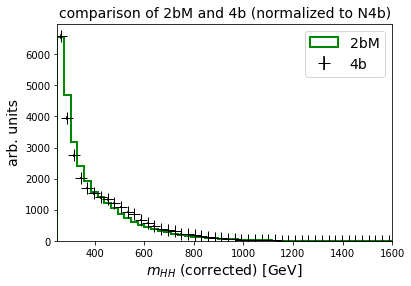

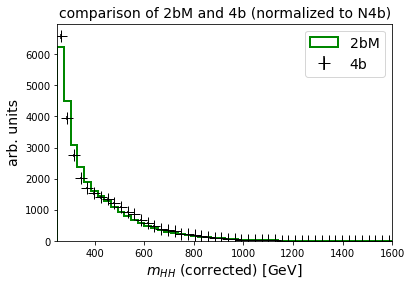

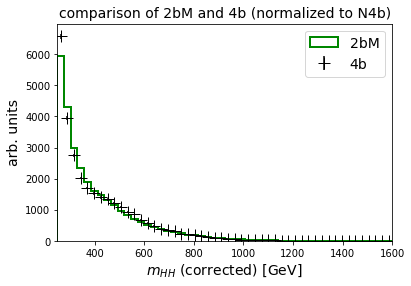

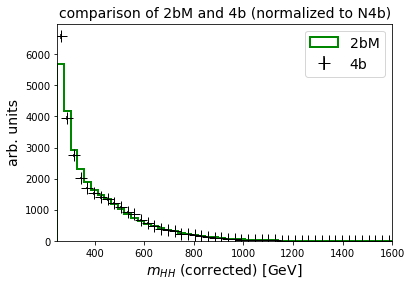

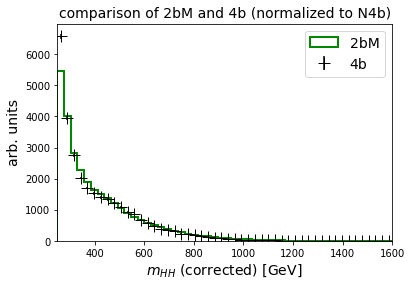

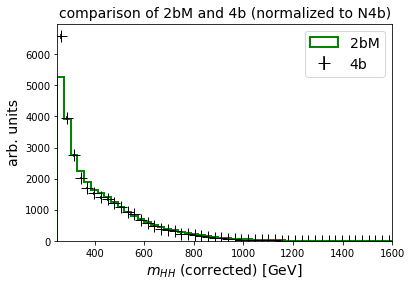

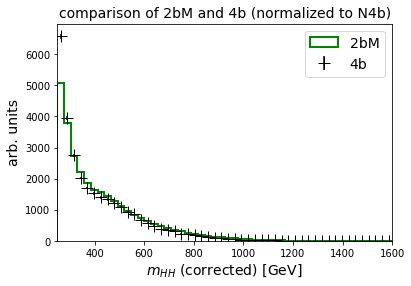

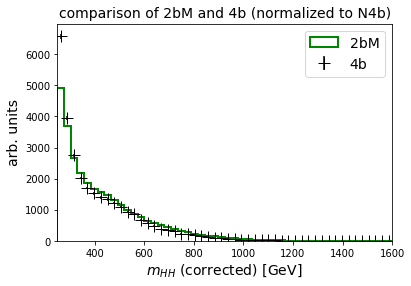

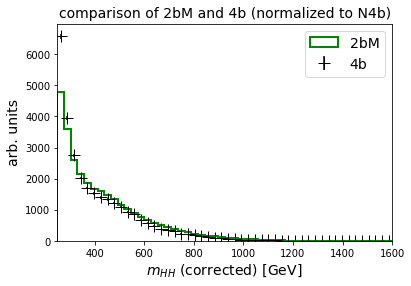

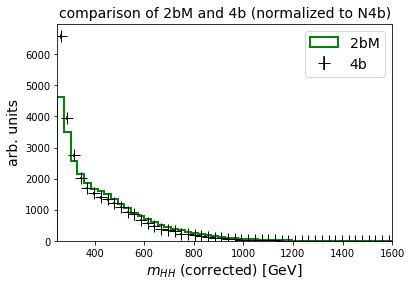

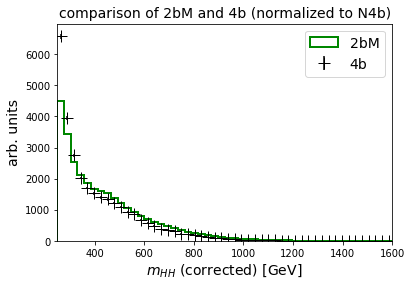

In [72]:
h4b, be = np.histogram(df4b.m_hh_cor, bins = 50, range = (250, 1600), density = 0)
h4b_err = np.sqrt(h4b)
x = hh.bin_midpoint(be)
N4b = np.sum(h4b)
chis2_mhh_cor = []
for fi in fractions:
    fig = plt.figure(figsize=(6, 4))
    plt.errorbar(x, h4b, yerr=h4b_err, fmt='+k', ms = 12, label = '4b')

    dfM = mixSplitTogether(dfS, dfT, f=fi)

    mu = N4b/len(dfM)

    h2bM, _, _ = plt.hist(dfM.m_hh_cor, bins = be, density = 0,
                      lw=2, histtype = 'step', label = '2bM',
                      weights = mu *np.ones(len(dfM)))


    plt.legend(fontsize = 14)
    plt.xlim((250, 1600))
    plt.xlabel('$m_{HH}$ (corrected) [GeV]', fontsize = 14)
    plt.ylabel('arb. units', fontsize = 14)
    plt.title('comparison of 2bM and 4b (normalized to N4b)', fontsize = 14)
    chi2, _, _ = u.chi2_unweighted(h2bM, h4b)
    chis2_mhh_cor.append(chi2)


In [73]:
chis2_mhh_cor

[12.086985591669416,
 6.944910803839628,
 4.619607159593903,
 4.407235633397058,
 5.572977725216186,
 7.680557044187806,
 10.497764890859557,
 13.818626983067707,
 17.326653527530887,
 21.08628283566575,
 25.01339270664783]

In [74]:
Dchi = (chis2_mhh_cor[-1] - chis2_mhh_cor)/chis2_mhh_cor[-1]

In [75]:
Dchi.max()

0.8238049638014222

In [76]:
fractions[Dchi==Dchi.max()]

array([0.3])

In [77]:
mhh_results = pd.DataFrame({"fractions": fractions, 
                            "chi2": chis2_mhh_cor,
                            "Dchi2rel": Dchi})

In [78]:
mhh_results

fractions       chi2  Dchi2rel
0         0.0  12.086986  0.516779
1         0.1   6.944911  0.722352
2         0.2   4.619607  0.815315
3         0.3   4.407236  0.823805
4         0.4   5.572978  0.777200
5         0.5   7.680557  0.692942
6         0.6  10.497765  0.580314
7         0.7  13.818627  0.447551
8         0.8  17.326654  0.307305
9         0.9  21.086283  0.157000
10        1.0  25.013393  0.000000

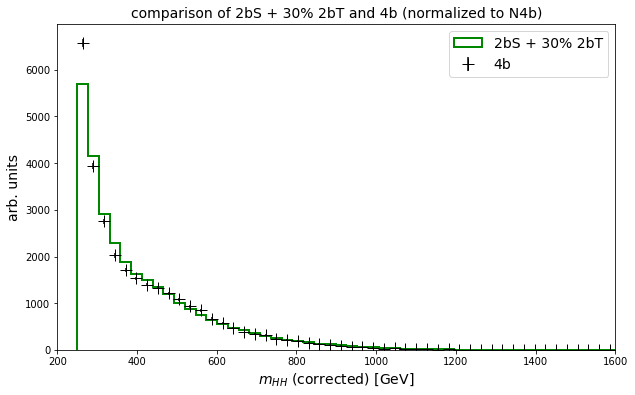

In [79]:
h4b, be = np.histogram(df[(df.ntag>=4) &(df.kinematic_region==2)].m_hh_cor, bins = 50, range = (250, 1600), density = 0)
h4b_err = np.sqrt(h4b)
x = hh.bin_midpoint(be)
N4b = np.sum(h4b)

fig = plt.figure(figsize = (10, 6))
plt.errorbar(x, h4b, yerr = h4b_err, fmt='+k', ms =12, label = '4b')
df30M = mixSplitTogether(dfS[dfS.kinematic_region==2], dfT[dfT.kinematic_region==2], f = 0.3)
mu = N4b/len(df30M)
h2bM, _, _ = plt.hist(df30M.m_hh_cor, bins = be, density = 0,
                     lw = 2, histtype ='step', label = '2bS + 30% 2bT',
                     weights = mu *np.ones(len(df30M)))




plt.legend(fontsize = 14)
plt.xlim((200, 1600))
plt.xlabel('$m_{HH}$ (corrected) [GeV]', fontsize = 14)
plt.ylabel('arb. units', fontsize = 14)
plt.title('comparison of 2bS + 30% 2bT and 4b (normalized to N4b)', fontsize = 14)
chi2, _, _ = u.chi2_unweighted(h2bM, h4b)


### Part 5: Try a different kinematic variables

In [80]:
feature = 'pT_2'

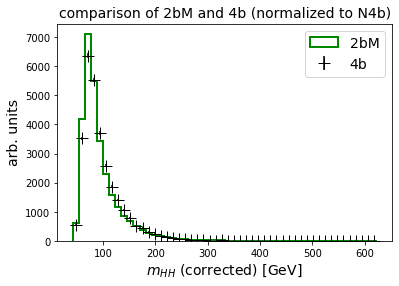

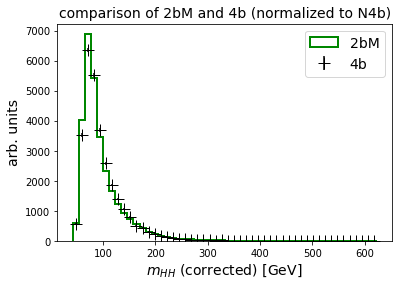

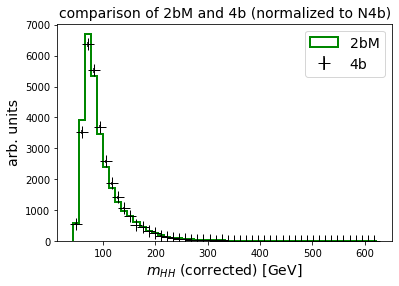

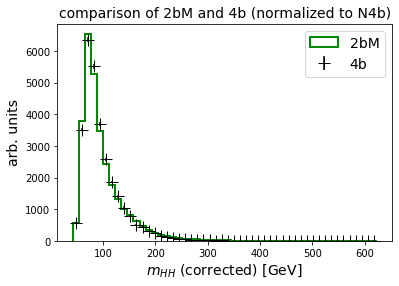

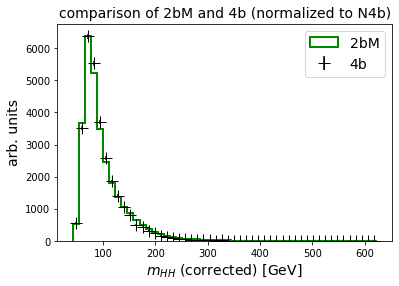

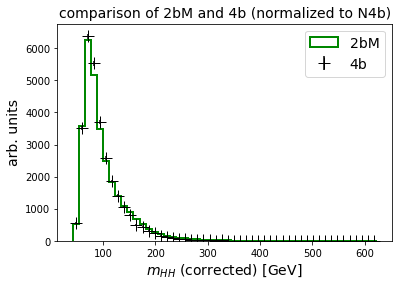

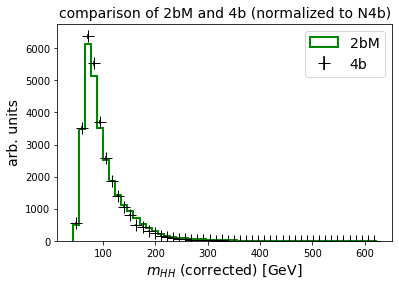

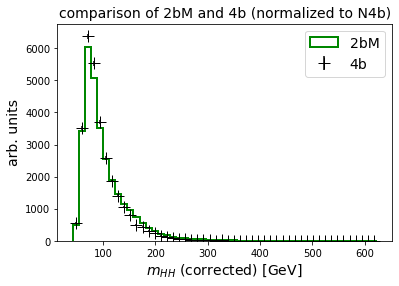

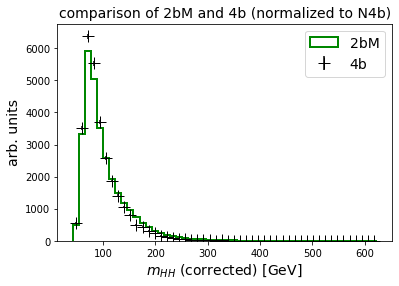

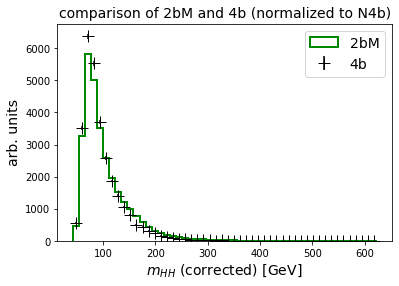

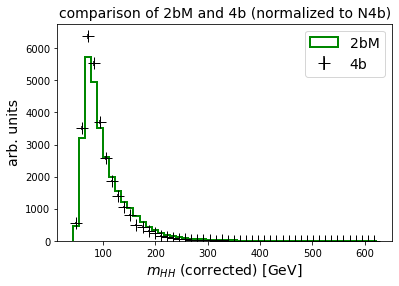

In [81]:
h4b, be = np.histogram(df4b[feature], bins = 50,  density = 0)
h4b_err = np.sqrt(h4b)
x = hh.bin_midpoint(be)
N4b = np.sum(h4b)
chis2_pT_2 = []
for fi in fractions:
    fig = plt.figure(figsize=(6, 4))
    plt.errorbar(x, h4b, yerr=h4b_err, fmt='+k', ms = 12, label = '4b')

    dfM = mixSplitTogether(dfS, dfT, f=fi)

    mu = N4b/len(dfM)

    h2bM, _, _ = plt.hist(dfM[feature], bins = be, density = 0,
                      lw=2, histtype = 'step', label = '2bM',
                      weights = mu *np.ones(len(dfM)))


    plt.legend(fontsize = 14)
    #plt.xlim((250, 1600))
    plt.xlabel('$m_{HH}$ (corrected) [GeV]', fontsize = 14)
    plt.ylabel('arb. units', fontsize = 14)
    plt.title('comparison of 2bM and 4b (normalized to N4b)', fontsize = 14)
    chi2, _, _ = u.chi2_unweighted(h2bM, h4b)
    chis2_pT_2.append(chi2)



In [82]:
chis2_pT_2

[10.182035606581186,
 5.9843670898466765,
 3.9230588940425353,
 3.373832219788882,
 3.749960833449402,
 4.902372718992277,
 6.5667948672520895,
 8.623052109892676,
 10.82528398706467,
 13.249988517135902,
 15.797326054901154]

In [83]:
Dchi_pT_2 = (chis2_pT_2[-1] - chis2_pT_2)/chis2_pT_2[-1]

In [84]:
results = mhh_results

In [85]:
results['chi2_pT_2'] = chis2_pT_2
results['Dchi_pT_2'] = Dchi_pT_2

In [86]:
results

fractions       chi2  Dchi2rel  chi2_pT_2  Dchi_pT_2
0         0.0  12.086986  0.516779  10.182036   0.355458
1         0.1   6.944911  0.722352   5.984367   0.621178
2         0.2   4.619607  0.815315   3.923059   0.751663
3         0.3   4.407236  0.823805   3.373832   0.786430
4         0.4   5.572978  0.777200   3.749961   0.762621
5         0.5   7.680557  0.692942   4.902373   0.689671
6         0.6  10.497765  0.580314   6.566795   0.584310
7         0.7  13.818627  0.447551   8.623052   0.454145
8         0.8  17.326654  0.307305  10.825284   0.314739
9         0.9  21.086283  0.157000  13.249989   0.161251
10        1.0  25.013393  0.000000  15.797326   0.000000

## Part 6: Let's Loop over 20 variables

In [87]:
results

fractions       chi2  Dchi2rel  chi2_pT_2  Dchi_pT_2
0         0.0  12.086986  0.516779  10.182036   0.355458
1         0.1   6.944911  0.722352   5.984367   0.621178
2         0.2   4.619607  0.815315   3.923059   0.751663
3         0.3   4.407236  0.823805   3.373832   0.786430
4         0.4   5.572978  0.777200   3.749961   0.762621
5         0.5   7.680557  0.692942   4.902373   0.689671
6         0.6  10.497765  0.580314   6.566795   0.584310
7         0.7  13.818627  0.447551   8.623052   0.454145
8         0.8  17.326654  0.307305  10.825284   0.314739
9         0.9  21.086283  0.157000  13.249989   0.161251
10        1.0  25.013393  0.000000  15.797326   0.000000

In [88]:
df.columns

Index(['run_number', 'event_number', 'mc_sf', 'ntag', 'njets',
       'kinematic_region', 'm_min_dj', 'm_max_dj', 'pairing_score_1',
       'pairing_score_2', 'm_hh_cor', 'm_hh', 'pt_hh', 'dEta_hh', 'X_wt',
       'X_wt_2', 'm_h1', 'E_h1', 'pT_h1', 'eta_h1', 'phi_h1', 'm_h2', 'E_h2',
       'pT_h2', 'eta_h2', 'phi_h2', 'm_h1_j1', 'E_h1_j1', 'pT_h1_j1',
       'eta_h1_j1', 'phi_h1_j1', 'tag_h1_j1', 'quantile_h1_j1', 'angle_h1_j1',
       'm_h1_j2', 'E_h1_j2', 'pT_h1_j2', 'eta_h1_j2', 'phi_h1_j2', 'tag_h1_j2',
       'quantile_h1_j2', 'angle_h1_j2', 'm_h2_j1', 'E_h2_j1', 'pT_h2_j1',
       'eta_h2_j1', 'phi_h2_j1', 'tag_h2_j1', 'quantile_h2_j1', 'angle_h2_j1',
       'm_h2_j2', 'E_h2_j2', 'pT_h2_j2', 'eta_h2_j2', 'phi_h2_j2', 'tag_h2_j2',
       'quantile_h2_j2', 'angle_h2_j2', 'pT_4', 'pT_2', 'eta_i', 'dRjj_1',
       'dRjj_2', 'NN_d24_weight_bstrap_med_17',
       'NN_d24_weight_VRderiv_bstrap_med_17', 'NN_d24_weight_bstrap_IQR_17',
       'NN_d24_weight_VRderiv_bstrap_IQR_17', 'dPhi_h

In [89]:
variables = ['njets',
             'pT_2',
             'pT_4',
             'dRjj_1',
             'dRjj_2',
             'eta_i',
             'pt_hh',
             'dR_hh',
             'dPhi_h1',
             'dPhi_h2',
             'X_wt',
             'E_h1',
             'E_h2',
             'pT_h2',
             'pT_h1',
             'm_h1',
             'm_h2',
             'dEta_hh',
             'angle_h1_j2',
             'angle_h2_j2'
    
]

In [90]:
bins_settings = [7,
                 50,
                 50,
                 50,
                 50,
                 50,
                 50,
                 50,
                 50,
                 50,
                 50,
                 50,
                 50,
                 50,
                 50,
                 50,
                 50,
                 50,
                 50,
                 50
                ]

In [91]:
len(bins_settings)

20

In [92]:
range_settings = [(4, 11),
                  (40, 250),
                  (40, 100),
                  (0.4, 2),
                  (0.4, 3.5),
                  (0.1, 2),
                  (40, 350),
                  (0.1, 3.5),
                  (0.1, 3.5),
                  (0.0, 3.0),
                  (1.5, 7.0),
                  (50, 900),
                  (50, 900),
                  (0, 350),
                  (0, 400),
                  (90, 170),
                  (70, 170),
                  (0, 1.4),
                  (0.8, 2.5),
                  (0.7, 2.5)
                 ]

In [93]:
len(range_settings)

20

In [94]:
len(variables)

20

In [95]:
df[variables].head()

njets        pT_2       pT_4    dRjj_1    dRjj_2     eta_i       pt_hh  \
entry                                                                           
0          5   97.824142  63.396816  1.138328  1.350479  1.627946   42.914744   
1          4   80.243820  53.175423  1.257046  2.241849  0.493552   17.070967   
2          4  128.025452  59.515724  0.829627  0.894855  1.923816   35.273680   
3          5   93.389709  72.904648  1.402519  2.724107  0.527254  118.847275   
4          4   91.954140  46.157230  1.164766  2.622380  0.501457   70.699528   

          dR_hh   dPhi_h1   dPhi_h2      X_wt         E_h1        E_h2  \
entry                                                                    
0      3.272518  1.349556  1.003954  4.297720  1163.433105  300.944069   
1      3.252822  1.522037  1.564145  1.676490   218.956253  137.996429   
2      3.080000  0.859676  0.237436  4.057891  1183.333832  566.969681   
3      2.325164  1.880559  0.723219  3.404587   198.766808  257.709259   
4      3.010947  1.399295  1.399050  3.006537   231.377792  176.896122   

            pT_h2       pT_h1        m_h1        m_h2   dEta_hh  angle_h1_j2  \
entry                                                                          
0      167.565907  200.217683  133.822225  107.225695  1.331476     1.096859   
1       96.558063  113.295310  111.553858   97.638877  0.954989     1.239081   
2      186.397825  210.808194  104.126321   76.620182  0.638690     1.276508   
3      155.708620  111.887605  158.716340  144.477440  0.465758     1.980776   
4      109.712340  177.855070  115.311913  114.731181  0.161549     2.237243   

       angle_h2_j2  
entry               
0         1.750215  
1         1.326175  
2         2.263889  
3         1.907784  
4         0.925183

In [96]:
def compare2bTo4b(df4b, df2b, feature, hrange, bi):
    
    f4b, be = np.histogram(df4b[feature],
                          bins = bi, 
                          density =0,
                          range = hrange)
    x = hh.bin_midpoint(be)
    
    N4b = np.sum(f4b)
    mu = N4b/len(df2b)
    
    f2b, _ = np.histogram(df2b[feature],
                          bins = be,
                          density = 0,
                          weights = mu * np.ones(len(df2b)),
                          range = hrange)
    
    chi2, _, _ = u.chi2_unweighted(f2b, f4b)
    return chi2
    
    

In [98]:
compare2bTo4b(df4b, dfS, 'njets')

TypeError: compare2bTo4b() missing 2 required positional arguments: 'hrange' and 'bi'

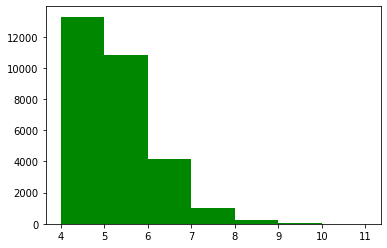

In [99]:
_, njetbins, _ = plt.hist(df4b.njets,bins = 7, range = (4, 11))

In [100]:
njetbins

array([ 4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

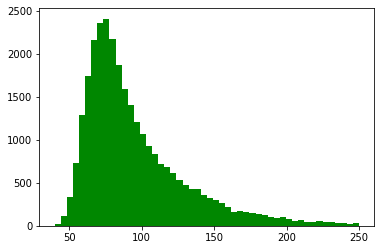

In [101]:
_,_,_ = plt.hist(df4b[variables[1]], bins = 50, range = (40, 250))

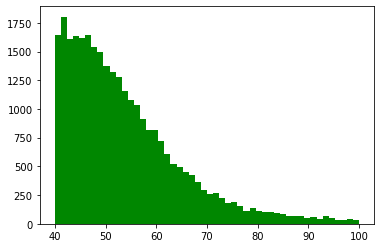

In [102]:
_,_,_ = plt.hist(df4b[variables[2]], bins = 50, range = (40, 100))

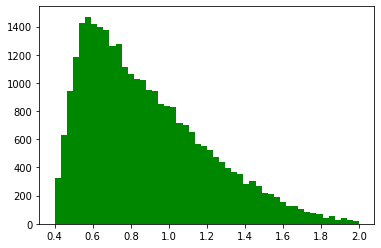

In [103]:
_,_,_ = plt.hist(df4b[variables[3]], bins = 50, range = (0.4, 2))

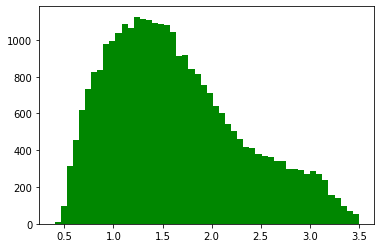

In [104]:
_,_,_ = plt.hist(df4b[variables[4]], bins = 50, range = (0.4, 3.5))

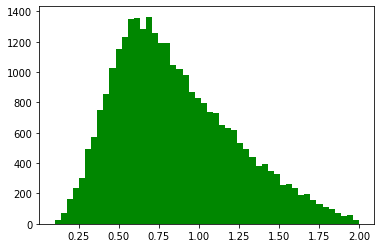

In [105]:
_,_,_ = plt.hist(df4b[variables[5]], bins = 50, range = (0.1, 2))

In [106]:
variables[6]

'pt_hh'

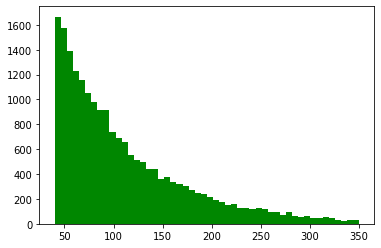

In [107]:
_,_,_ = plt.hist(df4b[variables[6]], bins = 50, range = (40, 350))

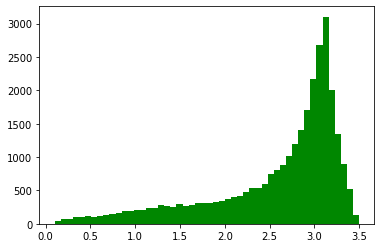

In [108]:
_,_,_ = plt.hist(df4b[variables[7]], bins = 50, range = (0.1, 3.5))

In [109]:
variables[8]

'dPhi_h1'

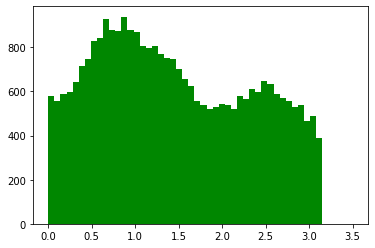

In [110]:
_,_,_ = plt.hist(df4b[variables[8]], bins = 50, range = (0, 3.5))

In [111]:
variables[9]

'dPhi_h2'

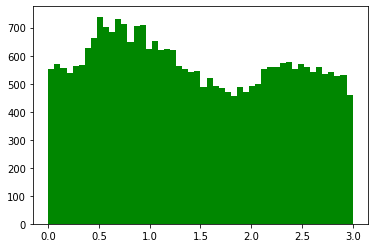

In [112]:
_,_,_ = plt.hist(df4b[variables[9]], bins = 50, range = (0.0, 3.0))

In [113]:
variables[10]

'X_wt'

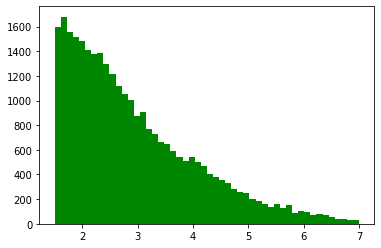

In [114]:
_,_,_ = plt.hist(df4b[variables[10]], bins = 50, range = (1.5, 7))

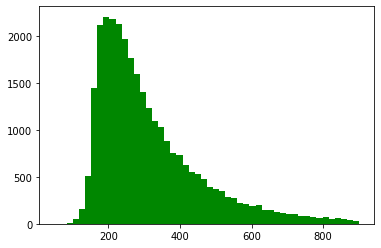

In [115]:
_,_,_ = plt.hist(df4b[variables[11]], bins = 50, range = (50, 900))

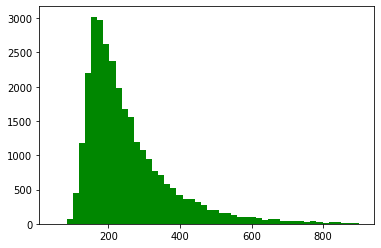

In [116]:
_,_,_ = plt.hist(df4b[variables[12]], bins = 50, range = (50, 900))

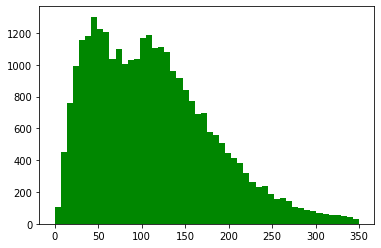

In [117]:
_,_,_ = plt.hist(df4b[variables[13]], bins = 50, range = (0, 350))

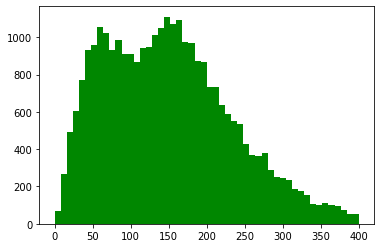

In [118]:
_,_,_ = plt.hist(df4b[variables[14]], bins = 50, range = (0, 400))

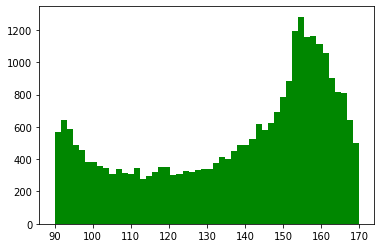

In [119]:
_,_,_ = plt.hist(df4b[variables[15]], bins = 50, range = (90, 170))

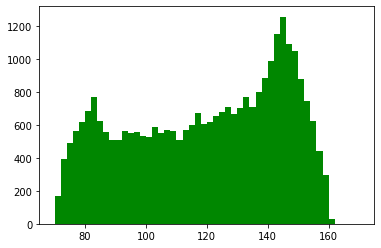

In [120]:
_,_,_ = plt.hist(df4b[variables[16]], bins = 50, range = (70, 170))

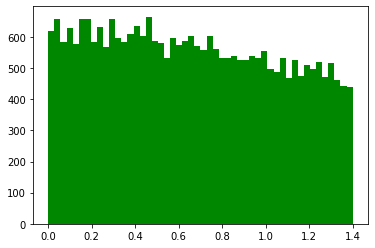

In [121]:
_,_,_ = plt.hist(df4b[variables[17]], bins = 50, range = (0, 1.4))

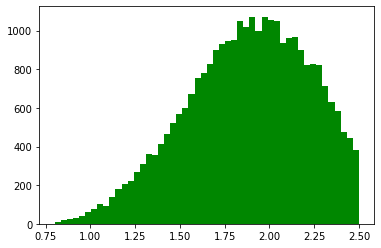

In [122]:
_,_,_ = plt.hist(df4b[variables[18]], bins = 50, range = (0.8, 2.5))

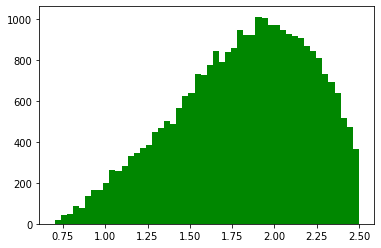

In [123]:
_,_,_ = plt.hist(df4b[variables[19]], bins = 50, range = (0.7, 2.5))

In [124]:
fractions_array = np.zeros((len(variables), len(fractions)))
chi2_array = np.zeros((len(variables), len(fractions)))

In [125]:
xmin_vars = []
Dchi2_x_min_vars = []
chi2_x_min_vars = []

Vi = np.arange(0, len(variables))

for i, var, nbin, hrange in zip(Vi, variables, bins_settings, range_settings):
    chis2 = []
    for j, fi in enumerate(fractions):
        dfM = mixSplitTogether(dfS, dfT, f=fi)

        chi2 = compare2bTo4b(df4b, dfM, var, hrange, nbin)
        fractions_array[i, j] = fi
        chi2_array[i, j] = chi2
        chis2.append(chi2)

    #find the x value for minimum chi2
    xmin = fractions[chis2==np.array(chis2).min()]
    xmin_vars.append(xmin)
    #find the value of the minimum chi2
    chi2min = np.array(chis2).min()
    chi2_x_min_vars.append(chi2min)
    #find the relative Delta_chi2 at x_min
    Dchi2_x_min = (chis2[-1] - chi2min)/chis2[-1]
    Dchi2_x_min_vars.append(Dchi2_x_min)

In [126]:
fractions_array[0]

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [127]:
chi2_array[5]

array([2.45781304, 2.29007872, 2.1598851 , 2.00930118, 1.91334685,
       1.8468784 , 1.78793038, 1.72461337, 1.67810792, 1.63139817,
       1.58552328])

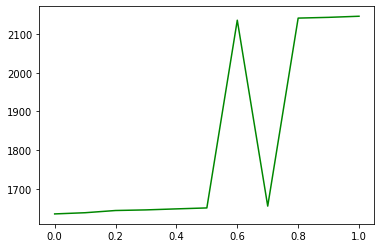

In [128]:
plt.plot(fractions_array[0], chi2_array[0])

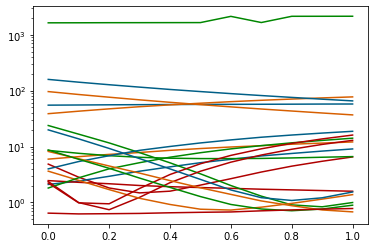

In [129]:
for i in range(20):
    plt.semilogy(fractions_array[i], chi2_array[i])

In [130]:
Dchi2_array = np.zeros((len(variables), len(fractions)))

In [131]:
for i in range(20):
    Dchi2_array[i] = (chi2_array[i, - 1] - chi2_array[i])/chi2_array[i, -1]

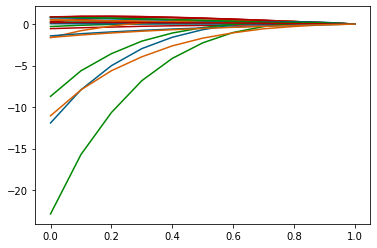

In [132]:
for i in range(20):
    plt.plot(fractions_array[i], Dchi2_array[i])

In [133]:
axs.shape

NameError: name 'axs' is not defined

In [134]:
axs.ravel().shape

NameError: name 'axs' is not defined

In [135]:
axs[0]

NameError: name 'axs' is not defined

In [136]:
axs[2]

NameError: name 'axs' is not defined

In [137]:
fractions_array[0][chi2_array[0]== chi2_array[0].min()]

array([0.])

In [138]:
rw_cols_log = ['pT_2_log', 'pT_4_log', 'eta_i', 'dRjj_1_log','dRjj_2_log','njets','pt_hh_log','X_wt_log','dR_hh','dPhi_h1','dPhi_h2']

In [139]:
chi2_array[0][-1]

2145.446867636781

In [140]:
chi2_array[1][-1]

6.520223073054542

In [141]:
chi2_array[1]

array([4.85065956, 2.83110654, 1.81507608, 1.48120508, 1.59048161,
       2.0421631 , 2.66043962, 3.49965885, 4.45917535, 5.45552832,
       6.52022307])

Text(0, 0.5, '$\\chi^2$ per degree of freedom')

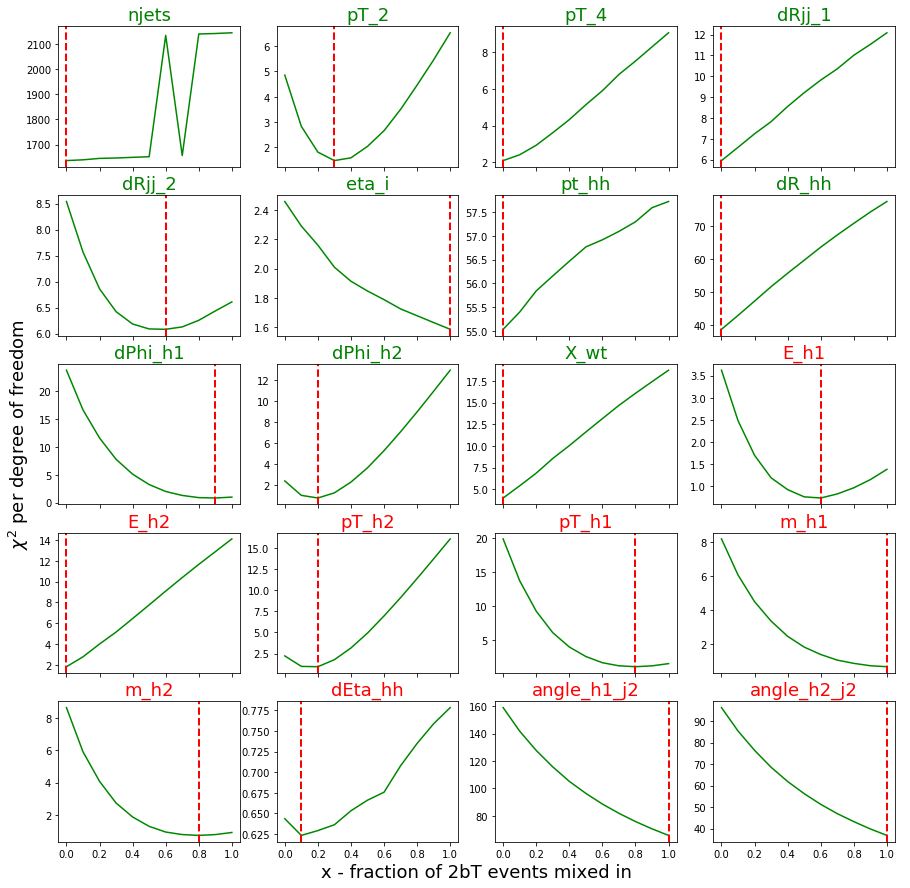

In [152]:
fig, axs = plt.subplots(5,4, sharex=True, figsize = (15, 15))
colors = []
for i in range(20):
    if i <11:
        colors.append('green')
    else:
        colors.append('red')
chi2_best_var = np.zeros(len(variables))
xmin_var = np.zeros(len(variables))
Dchi2_var = np.zeros(len(variables))
W = np.zeros(len(variables))
for i, ax in enumerate(axs.ravel()):
    ax.plot(fractions_array[i], chi2_array[i])
    xmin = fractions_array[i][chi2_array[i] == chi2_array[i].min()]
    ax.axvline(xmin[0], lw = 2, ls = '--', color ='red')
    xmin_var[i] = xmin[0]
    chi2_best_var[i] = chi2_array[i].min()
    Dchi2_var[i] = (chi2_array[i][-1] - chi2_array[i].min())/chi2_array[i][-1]
    W[i] = np.abs(chi2_array[i].max() - chi2_array[i].min())/chi2_array[i].max()
    #print(i, variables[i])
    ax.set_title(variables[i], fontsize = 18, color = colors[i])

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('x - fraction of 2bT events mixed in', fontsize = 18)
plt.ylabel('$\chi^2$ per degree of freedom', fontsize = 18)

In [153]:
xmins = []
for xi in xmin_vars:
    xmins.append(xi[0])


In [154]:
xmins, W

([0.0,
  0.3,
  0.0,
  0.0,
  0.6,
  1.0,
  0.0,
  0.0,
  0.9,
  0.2,
  0.0,
  0.6,
  0.0,
  0.2,
  0.8,
  1.0,
  0.8,
  0.1,
  1.0,
  1.0],
 array([0.23741817, 0.77282908, 0.76849616, 0.50719361, 0.28775238,
        0.35490484, 0.04653928, 0.49926316, 0.96489552, 0.94265303,
        0.78741667, 0.7984906 , 0.87170063, 0.94111764, 0.94542862,
        0.91703142, 0.91807822, 0.19954656, 0.58741068, 0.61717803]))

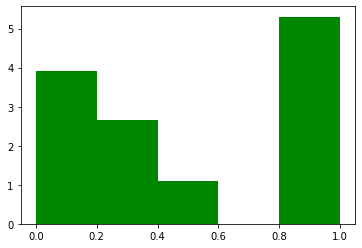

In [158]:
h, bi, _ = plt.hist(xmins, bins = 5, weights = W)

In [159]:
h

array([3.91757424, 2.65659975, 1.08624298, 0.        , 5.30492734])

In [160]:
hh.median_histogram(h, bi)

array(0.29311136)

In [161]:
hh.mean_histogram(h, bi)

0.5018218791848288

### Part 6: Let's do a single test train

In [210]:
df4b = df[df.ntag!=2]

In [211]:
df2b = df[df.ntag==2]

In [212]:
dfS = df2b[splitMask(df2b)]

In [213]:
len(dfS)

2146114

In [214]:
dfT = df2b[togetherMask(df2b)]

In [215]:
dfM = mixSplitTogether(dfS, dfT, f = 0.3)

In [216]:
DF = dfM.append(df4b)

In [217]:
DF.reset_index(drop = True, inplace = True)

In [170]:
nominal = nn.nominal()

In [218]:
DF

run_number  event_number  mc_sf  ntag  njets  kinematic_region  \
0            326468     111778889    1.0     2      5                 0   
1            326468     112388761    1.0     2      4                 0   
2            326468     113866237    1.0     2      4                 2   
3            326468     113078093    1.0     2      5                 2   
4            326468     121644426    1.0     2      4                 0   
...             ...           ...    ...   ...    ...               ...   
2979236      338987    1367051664    1.0     3      4                 1   
2979237      338987    1366546721    1.0     3      6                 1   
2979238      338987    1241396017    1.0     3      4                 2   
2979239      338987    1239796732    1.0     3      7                 2   
2979240      338987    1240526209    1.0     4      5                 2   

           m_min_dj    m_max_dj  pairing_score_1  pairing_score_2  ...  \
0        107.225695  341.705614         0.998575         0.023545  ...   
1         71.237253  172.622854         0.652556         0.240247  ...   
2         76.620182  265.217573         0.997849         0.019249  ...   
3        109.105578  209.255880         0.702341         0.207101  ...   
4         56.056614  243.195143         0.870014         0.197439  ...   
...             ...         ...              ...              ...  ...   
2979236   32.166980  227.641274         0.433535         0.172511  ...   
2979237  106.602647  201.732166         0.915425         0.393216  ...   
2979238   43.046282  156.915479         0.522352         0.370784  ...   
2979239   80.522279  479.163161         0.999869         0.002427  ...   
2979240   27.867719  197.503559         0.280905         0.194657  ...   

            eta_i    dRjj_1    dRjj_2  NN_d24_weight_bstrap_med_17  \
0        1.627946  1.138328  1.350479                     0.011660   
1        0.493552  1.257046  2.241849                     0.009392   
2        1.923816  0.829627  0.894855                     0.007429   
3        0.527254  1.402519  2.724107                     0.025762   
4        0.501457  1.164766  2.622380                     0.008254   
...           ...       ...       ...                          ...   
2979236  1.651927  0.426300  2.346480                     0.979103   
2979237  1.045344  1.304751  1.641521                     0.979103   
2979238  0.417066  0.590761  0.693976                     0.979103   
2979239  0.346419  0.721048  0.727218                     0.979103   
2979240  1.474087  0.542183  1.062959                     0.979103   

         NN_d24_weight_VRderiv_bstrap_med_17  NN_d24_weight_bstrap_IQR_17  \
0                                   0.012281                     0.003038   
1                                   0.010066                     0.002402   
2                                   0.005687                     0.001716   
3                                   0.021310                     0.009356   
4                                   0.009031                     0.001797   
...                                      ...                          ...   
2979236                             0.978789                     0.058382   
2979237                             0.978789                     0.058382   
2979238                             0.978789                     0.058382   
2979239                             0.978789                     0.058382   
2979240                             0.978789                     0.058382   

         NN_d24_weight_VRderiv_bstrap_IQR_17   dPhi_h1   dPhi_h2     dR_hh  
0                                   0.003843  1.349556  1.003954  3.272518  
1                                   0.002721  1.522037  1.564145  3.252822  
2                                   0.001888  0.859676  0.237436  3.080000  
3                                   0.008511  1.880559  0.723219  2.325164  
4                                   0.002318  1.399295  1.399050  3.

In [219]:
rw_cols_to_log = nominal['rw_cols_to_log']

In [220]:
rw_cols_log = nominal['rw_cols_log']

In [221]:
nn.log_inputs(DF, to_log = rw_cols_to_log)

In [174]:
!ls -lh /mnt/storage/lborgna/

total 95G
-rw-r--r-- 1 lborgna users 113M Feb 20 15:32 B1d.pkl
-rw-r--r-- 1 lborgna users  74M Feb 20 15:31 B1s.pkl
-rw-r--r-- 1 lborgna users 300M Feb 25 00:16 B2_BDT_weights100.npz
-rw-r--r-- 1 lborgna users 2.6M Feb 24 23:06 B2_BDT_weights1.npz
-rw-r--r-- 1 lborgna users 1.5G Feb 20 15:32 B2d.pkl
-rw-r--r-- 1 lborgna users 123M Feb 20 15:31 B2s.pkl
-rw-r--r-- 1 lborgna users 1.2G Feb 20 15:32 B3d.pkl
-rw-r--r-- 1 lborgna users 267M Feb 25 23:16 B3_NN_100.npz
-rw-r--r-- 1 lborgna users  29M Feb 20 15:31 B3s.pkl
-rw-r--r-- 1 lborgna users 5.9G Feb 20 15:33 B4d.pkl
-rw-r--r-- 1 lborgna users  28M Feb 20 15:31 B4s.pkl
-rw-r--r-- 1 lborgna users  69M Dec 16 15:46 BDT18_d2b2j_CR
-rw-r--r-- 1 lborgna users  89M Dec 16 15:44 BDT18_d2b2j_SB
-rw-r--r-- 1 lborgna users  18M Dec 16 15:51 BDT18_dother_CR
-rw-r--r-- 1 lborgna users  33M Dec 16 15:51 BDT18_dother_SB
-rw-r--r-- 1 lborgna users 120K Mar  3 00:35 bucket1_BDT_weights
drwxr-xr-x 5 lborgna users 4.0K Mar  3 01:56 condaenv
-rw-r--r-- 1 l

In [176]:
dfW, muQCD, pW, N4b, N2b = nn.getNNweights(DF, kinematic_region= 2, sort_rw_cols = rw_cols_log, epochs = 80, batch_size = 8192)

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771185 samples, validate on 514124 samples
Epoch 1/80
771185/771185 [==============================] - 2s 3us/step - loss: 0.8545 - accuracy: 0.0649 - val_loss: 0.6237 - val_accuracy: 9.3168e-04

Epoch 00001: val_loss improved from inf to 0.62374, saving model to /mnt/storage/lborgna/models/current_model.h5
Epoch 2/80
771185/771185 [==============================] - 1s 2us/step - loss: 0.4895 - accuracy: 0.0026 - val_loss: 0.3586 - val_accuracy: 2.4897e-04

Epoch 00002: val_loss improved from 0.62374 to 0.35857, saving model to /mnt/storage/lborgna/models/current_model.h5
Epoch 3/80
771185/771185 [==============================] - 1s 2us/step - loss: 0.3121 - accuracy: 0.0011 - val_loss: 0.2851 - val_accuracy: 5.9324e-04

Epoch 00003: val_loss improved from 0.35857 to 0.28509, saving model to /mnt/storage

In [177]:
dfW

run_number  event_number  mc_sf  ntag  njets  kinematic_region  \
0            326468     111778889    1.0     2      5                 0   
1            326468     112388761    1.0     2      4                 0   
2            326468     113866237    1.0     2      4                 2   
3            326468     113078093    1.0     2      5                 2   
4            326468     121644426    1.0     2      4                 0   
...             ...           ...    ...   ...    ...               ...   
2979236      338987    1367051664    1.0     3      4                 1   
2979237      338987    1366546721    1.0     3      6                 1   
2979238      338987    1241396017    1.0     3      4                 2   
2979239      338987    1239796732    1.0     3      7                 2   
2979240      338987    1240526209    1.0     4      5                 2   

           m_min_dj    m_max_dj  pairing_score_1  pairing_score_2  ...  \
0        107.225695  341.705614         0.998575         0.023545  ...   
1         71.237253  172.622854         0.652556         0.240247  ...   
2         76.620182  265.217573         0.997849         0.019249  ...   
3        109.105578  209.255880         0.702341         0.207101  ...   
4         56.056614  243.195143         0.870014         0.197439  ...   
...             ...         ...              ...              ...  ...   
2979236   32.166980  227.641274         0.433535         0.172511  ...   
2979237  106.602647  201.732166         0.915425         0.393216  ...   
2979238   43.046282  156.915479         0.522352         0.370784  ...   
2979239   80.522279  479.163161         0.999869         0.002427  ...   
2979240   27.867719  197.503559         0.280905         0.194657  ...   

          dPhi_h2     dR_hh  pT_2_log  pT_4_log  dRjj_1_log  dRjj_2_log  \
0        1.003954  3.272518  4.583171  4.149414    0.129560    0.300460   
1        1.564145  3.252822  4.385070  3.973596    0.228765    0.807301   
2        0.237436  3.080000  4.852229  4.086241   -0.186780   -0.111094   
3        0.723219  2.325164  4.536781  4.289152    0.338270    1.002141   
4        1.399050  3.010947  4.521290  3.832054    0.152521    0.964082   
...           ...       ...       ...       ...         ...         ...   
2979236  1.819923  2.925371  4.415542  3.833874   -0.852612    0.852916   
2979237  1.606537  2.849097  4.611548  4.013991    0.266012    0.495623   
2979238  2.864898  1.437100  4.070203  3.924554   -0.526344   -0.365318   
2979239  0.123887  3.055882  5.030469  4.118105   -0.327050   -0.318530   
2979240  2.188207  1.690315  4.332613  3.723615   -0.612151    0.061057   

         pt_hh_log  X_wt_log  poisson_weight  NN_weight  
0         3.759215  1.458085             NaN   0.015149  
1         2.837379  0.516703             NaN   0.008788  
2         3.563137  1.400663             0.0   0.012172  
3         4.777839  1.225124             1.0   0.055203  
4         4.258439  1.100789             NaN   0.009401  
...            ...       ...             ...        ...  
2979236   4.056248  0.780208             NaN   1.000000  
2979237   4.682672  0.934815             NaN   1.000000  
2979238   4.170439  0.730397             0.0   1.000000  
2979239   5.298725  1.160459             0.0   1.000000  
2979240   4.724016  0.879522             0.0   1.000000  

[2979241 rows x 78 columns]

In [178]:
muQCD

0.9258550091261852

In [179]:
N4b

29486.0

In [180]:
N2b

31847.319190753915

In [181]:
len(dfW[(dfW.ntag >= 4) & (dfW.kinematic_region == 2)]) / np.sum(dfW[(dfW.ntag == 2) & (dfW.kinematic_region == 2)].NN_weight)

0.9300640907651063

In [182]:
len(dfW[(dfW.ntag >= 4) & (dfW.kinematic_region == 2)]) / len(dfW[(dfW.ntag == 2) & (dfW.kinematic_region == 2) ])

0.023603316473821568

looks ok, let's try a quick bootstrap

In [183]:
dfM.shape

(2545048, 70)

In [222]:
nn.log_inputs(dfM, to_log=rw_cols_to_log)

In [226]:
dfR = pd.DataFrame({})

In [235]:
dfR

0         1         2         3         4         5  \
0        1.117789e+08  326468.0  0.017434  0.009234  0.016282  0.017936   
1        1.123888e+08  326468.0  0.018563  0.008964  0.023954  0.013385   
2        1.138662e+08  326468.0  0.013236  0.003865  0.017312  0.007803   
3        1.130781e+08  326468.0  0.023032  0.010059  0.033236  0.022180   
4        1.216444e+08  326468.0  0.013600  0.003660  0.011516  0.024693   
...               ...       ...       ...       ...       ...       ...   
2979236  1.367052e+09  338987.0  1.000000  1.000000  1.000000  1.000000   
2979237  1.366547e+09  338987.0  1.000000  1.000000  1.000000  1.000000   
2979238  1.241396e+09  338987.0  1.000000  1.000000  1.000000  1.000000   
2979239  1.239797e+09  338987.0  1.000000  1.000000  1.000000  1.000000   
2979240  1.240526e+09  338987.0  1.000000  1.000000  1.000000  1.000000   

                6         7         8         9        10        11  
0        0.036860  0.016932  0.029887  0.013760  0.023292  0.013981  
1        0.021562  0.022022  0.022640  0.012694  0.015564  0.010690  
2        0.016557  0.011159  0.014543  0.011190  0.014512  0.011959  
3        0.017877  0.039491  0.016701  0.014601  0.025777  0.023883  
4        0.015082  0.014516  0.005113  0.009441  0.013028  0.014171  
...           ...       ...       ...       ...       ...       ...  
2979236  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
2979237  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
2979238  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
2979239  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
2979240  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  

[2979241 rows x 12 columns]

In [280]:
dfR, muQCD_BS = nn.repeatNNtrain(DF, repeat = 50, kinematic_region = 1,
                                sort_rw_cols=rw_cols_log,
                                epochs = 100,
                                batch_size = 8192,
                                model_storage_directory = '/mnt/storage/lborgna/models/')


  0%|          | 0/50 [00:00<?, ?it/s]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 4us/step - loss: 0.9193 - accuracy: 0.0814 - val_loss: 0.7809 - val_accuracy: 0.0117

Epoch 00001: val_loss improved from inf to 0.78094, saving model to /mnt/storage/lborgna/models/bootstrap_n0.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6576 - accuracy: 0.0081 - val_loss: 0.5366 - val_accuracy: 0.0013

Epoch 00002: val_loss improved from 0.78094 to 0.53660, saving model to /mnt/storage/lborgna/models/bootstrap_n0.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4436 - accuracy: 0.0026 - val_loss: 0.3633 - val_accuracy: 6.0768e-04

Epoch 00003: val_loss improved from 0.53660 to 0.36332, saving model to /mnt/storage/lborgn


  2%|▏         | 1/50 [00:22<18:27, 22.61s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 4us/step - loss: 0.9260 - accuracy: 0.0827 - val_loss: 0.7965 - val_accuracy: 0.0146

Epoch 00001: val_loss improved from inf to 0.79652, saving model to /mnt/storage/lborgna/models/bootstrap_n1.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6754 - accuracy: 0.0092 - val_loss: 0.5624 - val_accuracy: 0.0016

Epoch 00002: val_loss improved from 0.79652 to 0.56237, saving model to /mnt/storage/lborgna/models/bootstrap_n1.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4563 - accuracy: 0.0029 - val_loss: 0.3791 - val_accuracy: 9.7758e-04

Epoch 00003: val_loss improved from 0.56237 to 0.37912, saving model to /mnt/storage/lborgn


  4%|▍         | 2/50 [00:41<17:10, 21.48s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 4us/step - loss: 0.9288 - accuracy: 0.0885 - val_loss: 0.7629 - val_accuracy: 0.0083

Epoch 00001: val_loss improved from inf to 0.76293, saving model to /mnt/storage/lborgna/models/bootstrap_n2.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6685 - accuracy: 0.0089 - val_loss: 0.5208 - val_accuracy: 4.6567e-04

Epoch 00002: val_loss improved from 0.76293 to 0.52085, saving model to /mnt/storage/lborgna/models/bootstrap_n2.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4588 - accuracy: 0.0029 - val_loss: 0.3633 - val_accuracy: 7.7282e-04

Epoch 00003: val_loss improved from 0.52085 to 0.36332, saving model to /mnt/storage/lb


  6%|▌         | 3/50 [01:00<16:12, 20.70s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.9133 - accuracy: 0.0865 - val_loss: 0.7450 - val_accuracy: 0.0062

Epoch 00001: val_loss improved from inf to 0.74503, saving model to /mnt/storage/lborgna/models/bootstrap_n3.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6424 - accuracy: 0.0071 - val_loss: 0.5089 - val_accuracy: 6.9685e-04

Epoch 00002: val_loss improved from 0.74503 to 0.50889, saving model to /mnt/storage/lborgna/models/bootstrap_n3.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4385 - accuracy: 0.0019 - val_loss: 0.3533 - val_accuracy: 6.5392e-04

Epoch 00003: val_loss improved from 0.50889 to 0.35330, saving model to /mnt/storage/lb


  8%|▊         | 4/50 [01:21<15:55, 20.78s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 4us/step - loss: 0.9287 - accuracy: 0.0830 - val_loss: 0.7905 - val_accuracy: 0.0129

Epoch 00001: val_loss improved from inf to 0.79054, saving model to /mnt/storage/lborgna/models/bootstrap_n4.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6831 - accuracy: 0.0092 - val_loss: 0.5472 - val_accuracy: 0.0011

Epoch 00002: val_loss improved from 0.79054 to 0.54722, saving model to /mnt/storage/lborgna/models/bootstrap_n4.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4595 - accuracy: 0.0032 - val_loss: 0.3678 - val_accuracy: 5.9117e-04

Epoch 00003: val_loss improved from 0.54722 to 0.36784, saving model to /mnt/storage/lborgn


 10%|█         | 5/50 [01:40<15:19, 20.43s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 4us/step - loss: 0.9585 - accuracy: 0.0970 - val_loss: 0.7944 - val_accuracy: 0.0131

Epoch 00001: val_loss improved from inf to 0.79437, saving model to /mnt/storage/lborgna/models/bootstrap_n5.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6933 - accuracy: 0.0103 - val_loss: 0.5862 - val_accuracy: 9.8749e-04

Epoch 00002: val_loss improved from 0.79437 to 0.58617, saving model to /mnt/storage/lborgna/models/bootstrap_n5.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.5000 - accuracy: 0.0035 - val_loss: 0.4153 - val_accuracy: 6.3741e-04

Epoch 00003: val_loss improved from 0.58617 to 0.41527, saving model to /mnt/storage/lb


 12%|█▏        | 6/50 [02:00<14:46, 20.15s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.9233 - accuracy: 0.0876 - val_loss: 0.7427 - val_accuracy: 0.0043

Epoch 00001: val_loss improved from inf to 0.74275, saving model to /mnt/storage/lborgna/models/bootstrap_n6.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6631 - accuracy: 0.0091 - val_loss: 0.5230 - val_accuracy: 1.6513e-05

Epoch 00002: val_loss improved from 0.74275 to 0.52295, saving model to /mnt/storage/lborgna/models/bootstrap_n6.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4561 - accuracy: 0.0030 - val_loss: 0.3658 - val_accuracy: 7.9263e-05

Epoch 00003: val_loss improved from 0.52295 to 0.36584, saving model to /mnt/storage/lb


 14%|█▍        | 7/50 [02:20<14:19, 19.99s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.9285 - accuracy: 0.0868 - val_loss: 0.7215 - val_accuracy: 0.0036

Epoch 00001: val_loss improved from inf to 0.72153, saving model to /mnt/storage/lborgna/models/bootstrap_n7.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6633 - accuracy: 0.0088 - val_loss: 0.5075 - val_accuracy: 3.0714e-04

Epoch 00002: val_loss improved from 0.72153 to 0.50749, saving model to /mnt/storage/lborgna/models/bootstrap_n7.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4618 - accuracy: 0.0027 - val_loss: 0.3586 - val_accuracy: 4.0953e-04

Epoch 00003: val_loss improved from 0.50749 to 0.35856, saving model to /mnt/storage/lb


 16%|█▌        | 8/50 [02:38<13:42, 19.58s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 4us/step - loss: 0.9540 - accuracy: 0.1022 - val_loss: 0.7995 - val_accuracy: 0.0162

Epoch 00001: val_loss improved from inf to 0.79945, saving model to /mnt/storage/lborgna/models/bootstrap_n8.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.7128 - accuracy: 0.0115 - val_loss: 0.5932 - val_accuracy: 0.0018

Epoch 00002: val_loss improved from 0.79945 to 0.59319, saving model to /mnt/storage/lborgna/models/bootstrap_n8.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.5096 - accuracy: 0.0036 - val_loss: 0.4187 - val_accuracy: 6.1429e-04

Epoch 00003: val_loss improved from 0.59319 to 0.41874, saving model to /mnt/storage/lborgn


 18%|█▊        | 9/50 [02:59<13:43, 20.08s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 4us/step - loss: 0.9407 - accuracy: 0.1011 - val_loss: 0.7795 - val_accuracy: 0.0120

Epoch 00001: val_loss improved from inf to 0.77952, saving model to /mnt/storage/lborgna/models/bootstrap_n9.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6744 - accuracy: 0.0093 - val_loss: 0.5678 - val_accuracy: 0.0011

Epoch 00002: val_loss improved from 0.77952 to 0.56781, saving model to /mnt/storage/lborgna/models/bootstrap_n9.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4697 - accuracy: 0.0030 - val_loss: 0.3940 - val_accuracy: 7.3318e-04

Epoch 00003: val_loss improved from 0.56781 to 0.39396, saving model to /mnt/storage/lborgn


 20%|██        | 10/50 [03:20<13:25, 20.14s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 4us/step - loss: 0.9296 - accuracy: 0.0882 - val_loss: 0.7501 - val_accuracy: 0.0069

Epoch 00001: val_loss improved from inf to 0.75010, saving model to /mnt/storage/lborgna/models/bootstrap_n10.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6693 - accuracy: 0.0089 - val_loss: 0.5322 - val_accuracy: 3.3687e-04

Epoch 00002: val_loss improved from 0.75010 to 0.53217, saving model to /mnt/storage/lborgna/models/bootstrap_n10.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4608 - accuracy: 0.0028 - val_loss: 0.3699 - val_accuracy: 2.1137e-04

Epoch 00003: val_loss improved from 0.53217 to 0.36991, saving model to /mnt/storage/


 22%|██▏       | 11/50 [03:38<12:49, 19.73s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 4us/step - loss: 0.9291 - accuracy: 0.0756 - val_loss: 0.8111 - val_accuracy: 0.0183

Epoch 00001: val_loss improved from inf to 0.81112, saving model to /mnt/storage/lborgna/models/bootstrap_n11.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6892 - accuracy: 0.0089 - val_loss: 0.5741 - val_accuracy: 0.0024

Epoch 00002: val_loss improved from 0.81112 to 0.57405, saving model to /mnt/storage/lborgna/models/bootstrap_n11.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4579 - accuracy: 0.0026 - val_loss: 0.3731 - val_accuracy: 0.0011

Epoch 00003: val_loss improved from 0.57405 to 0.37307, saving model to /mnt/storage/lborgna/


 24%|██▍       | 12/50 [03:58<12:28, 19.69s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 4us/step - loss: 0.9447 - accuracy: 0.0884 - val_loss: 0.7645 - val_accuracy: 0.0084

Epoch 00001: val_loss improved from inf to 0.76454, saving model to /mnt/storage/lborgna/models/bootstrap_n12.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.7156 - accuracy: 0.0112 - val_loss: 0.5567 - val_accuracy: 2.5100e-04

Epoch 00002: val_loss improved from 0.76454 to 0.55669, saving model to /mnt/storage/lborgna/models/bootstrap_n12.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.5069 - accuracy: 0.0034 - val_loss: 0.3965 - val_accuracy: 2.1467e-04

Epoch 00003: val_loss improved from 0.55669 to 0.39654, saving model to /mnt/storage/


 26%|██▌       | 13/50 [04:18<12:06, 19.64s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.9146 - accuracy: 0.0780 - val_loss: 0.7609 - val_accuracy: 0.0102

Epoch 00001: val_loss improved from inf to 0.76086, saving model to /mnt/storage/lborgna/models/bootstrap_n13.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6465 - accuracy: 0.0073 - val_loss: 0.5216 - val_accuracy: 9.9409e-04

Epoch 00002: val_loss improved from 0.76086 to 0.52162, saving model to /mnt/storage/lborgna/models/bootstrap_n13.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4380 - accuracy: 0.0026 - val_loss: 0.3619 - val_accuracy: 4.1613e-04

Epoch 00003: val_loss improved from 0.52162 to 0.36193, saving model to /mnt/storage/


 28%|██▊       | 14/50 [04:37<11:44, 19.57s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.9278 - accuracy: 0.0870 - val_loss: 0.8048 - val_accuracy: 0.0158

Epoch 00001: val_loss improved from inf to 0.80482, saving model to /mnt/storage/lborgna/models/bootstrap_n14.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6738 - accuracy: 0.0095 - val_loss: 0.5654 - val_accuracy: 0.0012

Epoch 00002: val_loss improved from 0.80482 to 0.56542, saving model to /mnt/storage/lborgna/models/bootstrap_n14.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4655 - accuracy: 0.0032 - val_loss: 0.3829 - val_accuracy: 7.0676e-04

Epoch 00003: val_loss improved from 0.56542 to 0.38285, saving model to /mnt/storage/lbor


 30%|███       | 15/50 [04:56<11:17, 19.37s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.9243 - accuracy: 0.0811 - val_loss: 0.7907 - val_accuracy: 0.0106

Epoch 00001: val_loss improved from inf to 0.79072, saving model to /mnt/storage/lborgna/models/bootstrap_n15.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6715 - accuracy: 0.0082 - val_loss: 0.5574 - val_accuracy: 2.9063e-04

Epoch 00002: val_loss improved from 0.79072 to 0.55735, saving model to /mnt/storage/lborgna/models/bootstrap_n15.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4502 - accuracy: 0.0024 - val_loss: 0.3839 - val_accuracy: 1.7834e-04

Epoch 00003: val_loss improved from 0.55735 to 0.38392, saving model to /mnt/storage/


 32%|███▏      | 16/50 [05:18<11:26, 20.20s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.9389 - accuracy: 0.0968 - val_loss: 0.8136 - val_accuracy: 0.0166

Epoch 00001: val_loss improved from inf to 0.81363, saving model to /mnt/storage/lborgna/models/bootstrap_n16.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6785 - accuracy: 0.0093 - val_loss: 0.6120 - val_accuracy: 0.0017

Epoch 00002: val_loss improved from 0.81363 to 0.61199, saving model to /mnt/storage/lborgna/models/bootstrap_n16.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4750 - accuracy: 0.0028 - val_loss: 0.4202 - val_accuracy: 0.0011

Epoch 00003: val_loss improved from 0.61199 to 0.42016, saving model to /mnt/storage/lborgna/


 34%|███▍      | 17/50 [05:38<11:07, 20.23s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.9413 - accuracy: 0.0943 - val_loss: 0.7979 - val_accuracy: 0.0147

Epoch 00001: val_loss improved from inf to 0.79787, saving model to /mnt/storage/lborgna/models/bootstrap_n17.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6857 - accuracy: 0.0091 - val_loss: 0.5904 - val_accuracy: 0.0013

Epoch 00002: val_loss improved from 0.79787 to 0.59035, saving model to /mnt/storage/lborgna/models/bootstrap_n17.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4853 - accuracy: 0.0029 - val_loss: 0.4141 - val_accuracy: 7.1337e-04

Epoch 00003: val_loss improved from 0.59035 to 0.41414, saving model to /mnt/storage/lbor


 36%|███▌      | 18/50 [05:59<10:48, 20.27s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.9298 - accuracy: 0.0741 - val_loss: 0.7762 - val_accuracy: 0.0112

Epoch 00001: val_loss improved from inf to 0.77617, saving model to /mnt/storage/lborgna/models/bootstrap_n18.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6894 - accuracy: 0.0094 - val_loss: 0.5307 - val_accuracy: 7.5960e-04

Epoch 00002: val_loss improved from 0.77617 to 0.53074, saving model to /mnt/storage/lborgna/models/bootstrap_n18.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4617 - accuracy: 0.0029 - val_loss: 0.3563 - val_accuracy: 4.1943e-04

Epoch 00003: val_loss improved from 0.53074 to 0.35630, saving model to /mnt/storage/


 38%|███▊      | 19/50 [06:18<10:16, 19.87s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.9151 - accuracy: 0.0724 - val_loss: 0.7498 - val_accuracy: 0.0081

Epoch 00001: val_loss improved from inf to 0.74980, saving model to /mnt/storage/lborgna/models/bootstrap_n19.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6572 - accuracy: 0.0075 - val_loss: 0.5005 - val_accuracy: 0.0011

Epoch 00002: val_loss improved from 0.74980 to 0.50052, saving model to /mnt/storage/lborgna/models/bootstrap_n19.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4361 - accuracy: 0.0023 - val_loss: 0.3438 - val_accuracy: 7.8272e-04

Epoch 00003: val_loss improved from 0.50052 to 0.34378, saving model to /mnt/storage/lbor


 40%|████      | 20/50 [06:37<09:55, 19.86s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.9257 - accuracy: 0.0804 - val_loss: 0.7885 - val_accuracy: 0.0143

Epoch 00001: val_loss improved from inf to 0.78850, saving model to /mnt/storage/lborgna/models/bootstrap_n20.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6720 - accuracy: 0.0082 - val_loss: 0.5330 - val_accuracy: 0.0017

Epoch 00002: val_loss improved from 0.78850 to 0.53303, saving model to /mnt/storage/lborgna/models/bootstrap_n20.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4471 - accuracy: 0.0026 - val_loss: 0.3590 - val_accuracy: 7.8603e-04

Epoch 00003: val_loss improved from 0.53303 to 0.35896, saving model to /mnt/storage/lbor


 42%|████▏     | 21/50 [06:58<09:45, 20.20s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 4us/step - loss: 0.9288 - accuracy: 0.0911 - val_loss: 0.7661 - val_accuracy: 0.0063

Epoch 00001: val_loss improved from inf to 0.76606, saving model to /mnt/storage/lborgna/models/bootstrap_n21.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6709 - accuracy: 0.0088 - val_loss: 0.5441 - val_accuracy: 5.7796e-04

Epoch 00002: val_loss improved from 0.76606 to 0.54414, saving model to /mnt/storage/lborgna/models/bootstrap_n21.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4636 - accuracy: 0.0028 - val_loss: 0.3795 - val_accuracy: 5.4824e-04

Epoch 00003: val_loss improved from 0.54414 to 0.37950, saving model to /mnt/storage/


 44%|████▍     | 22/50 [07:18<09:23, 20.14s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 4us/step - loss: 0.9179 - accuracy: 0.0710 - val_loss: 0.8001 - val_accuracy: 0.0164

Epoch 00001: val_loss improved from inf to 0.80013, saving model to /mnt/storage/lborgna/models/bootstrap_n22.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6673 - accuracy: 0.0082 - val_loss: 0.5586 - val_accuracy: 6.5722e-04

Epoch 00002: val_loss improved from 0.80013 to 0.55859, saving model to /mnt/storage/lborgna/models/bootstrap_n22.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4426 - accuracy: 0.0026 - val_loss: 0.3693 - val_accuracy: 3.9301e-04

Epoch 00003: val_loss improved from 0.55859 to 0.36933, saving model to /mnt/storage/


 46%|████▌     | 23/50 [07:37<08:55, 19.82s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 4us/step - loss: 0.9268 - accuracy: 0.0918 - val_loss: 0.7907 - val_accuracy: 0.0150

Epoch 00001: val_loss improved from inf to 0.79067, saving model to /mnt/storage/lborgna/models/bootstrap_n23.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6648 - accuracy: 0.0085 - val_loss: 0.5661 - val_accuracy: 0.0012

Epoch 00002: val_loss improved from 0.79067 to 0.56607, saving model to /mnt/storage/lborgna/models/bootstrap_n23.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4586 - accuracy: 0.0028 - val_loss: 0.3867 - val_accuracy: 4.9209e-04

Epoch 00003: val_loss improved from 0.56607 to 0.38673, saving model to /mnt/storage/lbor


 48%|████▊     | 24/50 [07:57<08:29, 19.60s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.9784 - accuracy: 0.1062 - val_loss: 0.7297 - val_accuracy: 0.0070

Epoch 00001: val_loss improved from inf to 0.72974, saving model to /mnt/storage/lborgna/models/bootstrap_n24.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.7104 - accuracy: 0.0137 - val_loss: 0.5233 - val_accuracy: 8.7520e-04

Epoch 00002: val_loss improved from 0.72974 to 0.52327, saving model to /mnt/storage/lborgna/models/bootstrap_n24.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.5325 - accuracy: 0.0042 - val_loss: 0.3993 - val_accuracy: 4.9209e-04

Epoch 00003: val_loss improved from 0.52327 to 0.39930, saving model to /mnt/storage/


 50%|█████     | 25/50 [08:20<08:35, 20.61s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.9226 - accuracy: 0.0826 - val_loss: 0.7855 - val_accuracy: 0.0125

Epoch 00001: val_loss improved from inf to 0.78549, saving model to /mnt/storage/lborgna/models/bootstrap_n25.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6715 - accuracy: 0.0082 - val_loss: 0.5599 - val_accuracy: 0.0016

Epoch 00002: val_loss improved from 0.78549 to 0.55995, saving model to /mnt/storage/lborgna/models/bootstrap_n25.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4595 - accuracy: 0.0025 - val_loss: 0.3835 - val_accuracy: 9.3134e-04

Epoch 00003: val_loss improved from 0.55995 to 0.38351, saving model to /mnt/storage/lbor


 52%|█████▏    | 26/50 [08:39<08:08, 20.35s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.9199 - accuracy: 0.0866 - val_loss: 0.7949 - val_accuracy: 0.0152

Epoch 00001: val_loss improved from inf to 0.79494, saving model to /mnt/storage/lborgna/models/bootstrap_n26.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6619 - accuracy: 0.0080 - val_loss: 0.5841 - val_accuracy: 0.0017

Epoch 00002: val_loss improved from 0.79494 to 0.58414, saving model to /mnt/storage/lborgna/models/bootstrap_n26.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4564 - accuracy: 0.0027 - val_loss: 0.4042 - val_accuracy: 9.4125e-04

Epoch 00003: val_loss improved from 0.58414 to 0.40424, saving model to /mnt/storage/lbor


 54%|█████▍    | 27/50 [08:59<07:44, 20.22s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.9256 - accuracy: 0.0703 - val_loss: 0.7894 - val_accuracy: 0.0131

Epoch 00001: val_loss improved from inf to 0.78936, saving model to /mnt/storage/lborgna/models/bootstrap_n27.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6811 - accuracy: 0.0085 - val_loss: 0.5350 - val_accuracy: 0.0012

Epoch 00002: val_loss improved from 0.78936 to 0.53495, saving model to /mnt/storage/lborgna/models/bootstrap_n27.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4595 - accuracy: 0.0027 - val_loss: 0.3652 - val_accuracy: 7.7612e-04

Epoch 00003: val_loss improved from 0.53495 to 0.36517, saving model to /mnt/storage/lbor


 56%|█████▌    | 28/50 [09:21<07:37, 20.79s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.9252 - accuracy: 0.0772 - val_loss: 0.7749 - val_accuracy: 0.0114

Epoch 00001: val_loss improved from inf to 0.77490, saving model to /mnt/storage/lborgna/models/bootstrap_n28.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6697 - accuracy: 0.0084 - val_loss: 0.5119 - val_accuracy: 0.0012

Epoch 00002: val_loss improved from 0.77490 to 0.51191, saving model to /mnt/storage/lborgna/models/bootstrap_n28.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4458 - accuracy: 0.0029 - val_loss: 0.3464 - val_accuracy: 6.8364e-04

Epoch 00003: val_loss improved from 0.51191 to 0.34637, saving model to /mnt/storage/lbor


 58%|█████▊    | 29/50 [09:40<07:05, 20.27s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.9338 - accuracy: 0.0823 - val_loss: 0.8141 - val_accuracy: 0.0172

Epoch 00001: val_loss improved from inf to 0.81406, saving model to /mnt/storage/lborgna/models/bootstrap_n29.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6885 - accuracy: 0.0092 - val_loss: 0.5621 - val_accuracy: 0.0021

Epoch 00002: val_loss improved from 0.81406 to 0.56213, saving model to /mnt/storage/lborgna/models/bootstrap_n29.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4701 - accuracy: 0.0030 - val_loss: 0.3804 - val_accuracy: 7.8603e-04

Epoch 00003: val_loss improved from 0.56213 to 0.38043, saving model to /mnt/storage/lbor


 60%|██████    | 30/50 [10:01<06:47, 20.36s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.9212 - accuracy: 0.0865 - val_loss: 0.7535 - val_accuracy: 0.0103

Epoch 00001: val_loss improved from inf to 0.75354, saving model to /mnt/storage/lborgna/models/bootstrap_n30.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6609 - accuracy: 0.0080 - val_loss: 0.5279 - val_accuracy: 0.0019

Epoch 00002: val_loss improved from 0.75354 to 0.52794, saving model to /mnt/storage/lborgna/models/bootstrap_n30.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4518 - accuracy: 0.0025 - val_loss: 0.3655 - val_accuracy: 0.0010

Epoch 00003: val_loss improved from 0.52794 to 0.36551, saving model to /mnt/storage/lborgna/


 62%|██████▏   | 31/50 [10:21<06:23, 20.21s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.9392 - accuracy: 0.0977 - val_loss: 0.8052 - val_accuracy: 0.0167

Epoch 00001: val_loss improved from inf to 0.80516, saving model to /mnt/storage/lborgna/models/bootstrap_n31.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6830 - accuracy: 0.0092 - val_loss: 0.5983 - val_accuracy: 0.0016

Epoch 00002: val_loss improved from 0.80516 to 0.59826, saving model to /mnt/storage/lborgna/models/bootstrap_n31.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4756 - accuracy: 0.0027 - val_loss: 0.4128 - val_accuracy: 9.9739e-04

Epoch 00003: val_loss improved from 0.59826 to 0.41284, saving model to /mnt/storage/lbor


 64%|██████▍   | 32/50 [10:41<06:02, 20.16s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.9214 - accuracy: 0.0779 - val_loss: 0.7992 - val_accuracy: 0.0165

Epoch 00001: val_loss improved from inf to 0.79920, saving model to /mnt/storage/lborgna/models/bootstrap_n32.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6688 - accuracy: 0.0089 - val_loss: 0.5507 - val_accuracy: 0.0012

Epoch 00002: val_loss improved from 0.79920 to 0.55068, saving model to /mnt/storage/lborgna/models/bootstrap_n32.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4485 - accuracy: 0.0028 - val_loss: 0.3698 - val_accuracy: 6.7374e-04

Epoch 00003: val_loss improved from 0.55068 to 0.36983, saving model to /mnt/storage/lbor


 66%|██████▌   | 33/50 [11:00<05:37, 19.88s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 4us/step - loss: 0.9322 - accuracy: 0.0950 - val_loss: 0.8447 - val_accuracy: 0.0201

Epoch 00001: val_loss improved from inf to 0.84467, saving model to /mnt/storage/lborgna/models/bootstrap_n33.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6757 - accuracy: 0.0091 - val_loss: 0.6279 - val_accuracy: 0.0028

Epoch 00002: val_loss improved from 0.84467 to 0.62785, saving model to /mnt/storage/lborgna/models/bootstrap_n33.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4677 - accuracy: 0.0030 - val_loss: 0.4272 - val_accuracy: 0.0012

Epoch 00003: val_loss improved from 0.62785 to 0.42720, saving model to /mnt/storage/lborgna/


 68%|██████▊   | 34/50 [11:22<05:27, 20.47s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 4us/step - loss: 0.9374 - accuracy: 0.0900 - val_loss: 0.7812 - val_accuracy: 0.0119

Epoch 00001: val_loss improved from inf to 0.78122, saving model to /mnt/storage/lborgna/models/bootstrap_n34.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6892 - accuracy: 0.0094 - val_loss: 0.5623 - val_accuracy: 8.1905e-04

Epoch 00002: val_loss improved from 0.78122 to 0.56230, saving model to /mnt/storage/lborgna/models/bootstrap_n34.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4806 - accuracy: 0.0029 - val_loss: 0.3898 - val_accuracy: 3.4017e-04

Epoch 00003: val_loss improved from 0.56230 to 0.38978, saving model to /mnt/storage/


 70%|███████   | 35/50 [11:41<05:02, 20.14s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 4us/step - loss: 0.9284 - accuracy: 0.0838 - val_loss: 0.7965 - val_accuracy: 0.0139

Epoch 00001: val_loss improved from inf to 0.79653, saving model to /mnt/storage/lborgna/models/bootstrap_n35.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6700 - accuracy: 0.0083 - val_loss: 0.5664 - val_accuracy: 0.0018

Epoch 00002: val_loss improved from 0.79653 to 0.56642, saving model to /mnt/storage/lborgna/models/bootstrap_n35.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4561 - accuracy: 0.0025 - val_loss: 0.3820 - val_accuracy: 0.0011

Epoch 00003: val_loss improved from 0.56642 to 0.38200, saving model to /mnt/storage/lborgna/


 72%|███████▏  | 36/50 [12:01<04:38, 19.89s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.9300 - accuracy: 0.0931 - val_loss: 0.7746 - val_accuracy: 0.0114

Epoch 00001: val_loss improved from inf to 0.77456, saving model to /mnt/storage/lborgna/models/bootstrap_n36.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6648 - accuracy: 0.0093 - val_loss: 0.5376 - val_accuracy: 0.0014

Epoch 00002: val_loss improved from 0.77456 to 0.53759, saving model to /mnt/storage/lborgna/models/bootstrap_n36.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4582 - accuracy: 0.0035 - val_loss: 0.3714 - val_accuracy: 7.3649e-04

Epoch 00003: val_loss improved from 0.53759 to 0.37142, saving model to /mnt/storage/lbor


 74%|███████▍  | 37/50 [12:23<04:28, 20.68s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.9247 - accuracy: 0.0821 - val_loss: 0.7821 - val_accuracy: 0.0122

Epoch 00001: val_loss improved from inf to 0.78213, saving model to /mnt/storage/lborgna/models/bootstrap_n37.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6669 - accuracy: 0.0082 - val_loss: 0.5336 - val_accuracy: 0.0011

Epoch 00002: val_loss improved from 0.78213 to 0.53359, saving model to /mnt/storage/lborgna/models/bootstrap_n37.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4494 - accuracy: 0.0027 - val_loss: 0.3606 - val_accuracy: 5.9778e-04

Epoch 00003: val_loss improved from 0.53359 to 0.36063, saving model to /mnt/storage/lbor


 76%|███████▌  | 38/50 [12:43<04:05, 20.49s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.9373 - accuracy: 0.0729 - val_loss: 0.7939 - val_accuracy: 0.0150

Epoch 00001: val_loss improved from inf to 0.79388, saving model to /mnt/storage/lborgna/models/bootstrap_n38.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6959 - accuracy: 0.0092 - val_loss: 0.5496 - val_accuracy: 0.0012

Epoch 00002: val_loss improved from 0.79388 to 0.54957, saving model to /mnt/storage/lborgna/models/bootstrap_n38.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4787 - accuracy: 0.0028 - val_loss: 0.3767 - val_accuracy: 4.8549e-04

Epoch 00003: val_loss improved from 0.54957 to 0.37665, saving model to /mnt/storage/lbor


 78%|███████▊  | 39/50 [13:03<03:43, 20.35s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.9262 - accuracy: 0.0794 - val_loss: 0.7705 - val_accuracy: 0.0098

Epoch 00001: val_loss improved from inf to 0.77053, saving model to /mnt/storage/lborgna/models/bootstrap_n39.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6819 - accuracy: 0.0091 - val_loss: 0.5275 - val_accuracy: 6.6713e-04

Epoch 00002: val_loss improved from 0.77053 to 0.52748, saving model to /mnt/storage/lborgna/models/bootstrap_n39.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4582 - accuracy: 0.0029 - val_loss: 0.3570 - val_accuracy: 3.8971e-04

Epoch 00003: val_loss improved from 0.52748 to 0.35701, saving model to /mnt/storage/


 80%|████████  | 40/50 [13:23<03:22, 20.25s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.9278 - accuracy: 0.0863 - val_loss: 0.7727 - val_accuracy: 0.0122

Epoch 00001: val_loss improved from inf to 0.77268, saving model to /mnt/storage/lborgna/models/bootstrap_n40.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6736 - accuracy: 0.0096 - val_loss: 0.5484 - val_accuracy: 0.0023

Epoch 00002: val_loss improved from 0.77268 to 0.54836, saving model to /mnt/storage/lborgna/models/bootstrap_n40.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4591 - accuracy: 0.0033 - val_loss: 0.3761 - val_accuracy: 8.9171e-04

Epoch 00003: val_loss improved from 0.54836 to 0.37613, saving model to /mnt/storage/lbor


 82%|████████▏ | 41/50 [13:43<03:01, 20.17s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.9281 - accuracy: 0.0867 - val_loss: 0.8240 - val_accuracy: 0.0182

Epoch 00001: val_loss improved from inf to 0.82402, saving model to /mnt/storage/lborgna/models/bootstrap_n41.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6686 - accuracy: 0.0087 - val_loss: 0.5760 - val_accuracy: 0.0027

Epoch 00002: val_loss improved from 0.82402 to 0.57598, saving model to /mnt/storage/lborgna/models/bootstrap_n41.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4566 - accuracy: 0.0030 - val_loss: 0.3898 - val_accuracy: 8.4878e-04

Epoch 00003: val_loss improved from 0.57598 to 0.38983, saving model to /mnt/storage/lbor


 84%|████████▍ | 42/50 [14:03<02:41, 20.16s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.8977 - accuracy: 0.0765 - val_loss: 0.7594 - val_accuracy: 0.0100

Epoch 00001: val_loss improved from inf to 0.75940, saving model to /mnt/storage/lborgna/models/bootstrap_n42.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6212 - accuracy: 0.0067 - val_loss: 0.5002 - val_accuracy: 0.0011

Epoch 00002: val_loss improved from 0.75940 to 0.50021, saving model to /mnt/storage/lborgna/models/bootstrap_n42.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4185 - accuracy: 0.0024 - val_loss: 0.3489 - val_accuracy: 8.4878e-04

Epoch 00003: val_loss improved from 0.50021 to 0.34889, saving model to /mnt/storage/lbor


 86%|████████▌ | 43/50 [14:23<02:19, 19.90s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.9567 - accuracy: 0.0949 - val_loss: 0.8044 - val_accuracy: 0.0146

Epoch 00001: val_loss improved from inf to 0.80437, saving model to /mnt/storage/lborgna/models/bootstrap_n43.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.7069 - accuracy: 0.0100 - val_loss: 0.5963 - val_accuracy: 0.0011

Epoch 00002: val_loss improved from 0.80437 to 0.59628, saving model to /mnt/storage/lborgna/models/bootstrap_n43.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.5109 - accuracy: 0.0029 - val_loss: 0.4170 - val_accuracy: 5.4163e-04

Epoch 00003: val_loss improved from 0.59628 to 0.41700, saving model to /mnt/storage/lbor


 88%|████████▊ | 44/50 [14:45<02:04, 20.69s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.9251 - accuracy: 0.0886 - val_loss: 0.7653 - val_accuracy: 0.0106

Epoch 00001: val_loss improved from inf to 0.76525, saving model to /mnt/storage/lborgna/models/bootstrap_n44.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6679 - accuracy: 0.0088 - val_loss: 0.5391 - val_accuracy: 0.0016

Epoch 00002: val_loss improved from 0.76525 to 0.53906, saving model to /mnt/storage/lborgna/models/bootstrap_n44.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4532 - accuracy: 0.0030 - val_loss: 0.3682 - val_accuracy: 9.9079e-04

Epoch 00003: val_loss improved from 0.53906 to 0.36817, saving model to /mnt/storage/lbor


 90%|█████████ | 45/50 [15:08<01:46, 21.25s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.9505 - accuracy: 0.1040 - val_loss: 0.7488 - val_accuracy: 0.0074

Epoch 00001: val_loss improved from inf to 0.74883, saving model to /mnt/storage/lborgna/models/bootstrap_n45.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6747 - accuracy: 0.0102 - val_loss: 0.5351 - val_accuracy: 8.4217e-04

Epoch 00002: val_loss improved from 0.74883 to 0.53513, saving model to /mnt/storage/lborgna/models/bootstrap_n45.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4744 - accuracy: 0.0032 - val_loss: 0.3833 - val_accuracy: 4.7558e-04

Epoch 00003: val_loss improved from 0.53513 to 0.38327, saving model to /mnt/storage/


 92%|█████████▏| 46/50 [15:28<01:23, 20.95s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.9204 - accuracy: 0.0754 - val_loss: 0.7708 - val_accuracy: 0.0088

Epoch 00001: val_loss improved from inf to 0.77077, saving model to /mnt/storage/lborgna/models/bootstrap_n46.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6707 - accuracy: 0.0082 - val_loss: 0.5329 - val_accuracy: 9.9739e-04

Epoch 00002: val_loss improved from 0.77077 to 0.53292, saving model to /mnt/storage/lborgna/models/bootstrap_n46.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4490 - accuracy: 0.0025 - val_loss: 0.3629 - val_accuracy: 5.7135e-04

Epoch 00003: val_loss improved from 0.53292 to 0.36287, saving model to /mnt/storage/


 94%|█████████▍| 47/50 [15:48<01:02, 20.71s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 4us/step - loss: 0.9291 - accuracy: 0.0839 - val_loss: 0.8171 - val_accuracy: 0.0163

Epoch 00001: val_loss improved from inf to 0.81713, saving model to /mnt/storage/lborgna/models/bootstrap_n47.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6724 - accuracy: 0.0088 - val_loss: 0.5666 - val_accuracy: 0.0024

Epoch 00002: val_loss improved from 0.81713 to 0.56657, saving model to /mnt/storage/lborgna/models/bootstrap_n47.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4649 - accuracy: 0.0031 - val_loss: 0.3860 - val_accuracy: 9.0162e-04

Epoch 00003: val_loss improved from 0.56657 to 0.38604, saving model to /mnt/storage/lbor


 96%|█████████▌| 48/50 [16:14<00:44, 22.31s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 4us/step - loss: 0.9061 - accuracy: 0.0752 - val_loss: 0.7494 - val_accuracy: 0.0102

Epoch 00001: val_loss improved from inf to 0.74938, saving model to /mnt/storage/lborgna/models/bootstrap_n48.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6446 - accuracy: 0.0070 - val_loss: 0.5173 - val_accuracy: 0.0013

Epoch 00002: val_loss improved from 0.74938 to 0.51732, saving model to /mnt/storage/lborgna/models/bootstrap_n48.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4296 - accuracy: 0.0026 - val_loss: 0.3577 - val_accuracy: 4.9870e-04

Epoch 00003: val_loss improved from 0.51732 to 0.35771, saving model to /mnt/storage/lbor


 98%|█████████▊| 49/50 [16:34<00:21, 21.54s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454183 samples, validate on 302789 samples
Epoch 1/100
454183/454183 [==============================] - 2s 3us/step - loss: 0.9464 - accuracy: 0.0924 - val_loss: 0.7353 - val_accuracy: 0.0036

Epoch 00001: val_loss improved from inf to 0.73534, saving model to /mnt/storage/lborgna/models/bootstrap_n49.h5
Epoch 2/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.6982 - accuracy: 0.0104 - val_loss: 0.5391 - val_accuracy: 7.9263e-05

Epoch 00002: val_loss improved from 0.73534 to 0.53915, saving model to /mnt/storage/lborgna/models/bootstrap_n49.h5
Epoch 3/100
454183/454183 [==============================] - 1s 2us/step - loss: 0.4986 - accuracy: 0.0033 - val_loss: 0.3875 - val_accuracy: 1.0238e-04

Epoch 00003: val_loss improved from 0.53915 to 0.38752, saving model to /mnt/storage/


100%|██████████| 50/50 [16:58<00:00, 20.37s/it]


['NN_weightVR_bs_0', 'NN_weightVR_bs_1', 'NN_weightVR_bs_2', 'NN_weightVR_bs_3', 'NN_weightVR_bs_4', 'NN_weightVR_bs_5', 'NN_weightVR_bs_6', 'NN_weightVR_bs_7', 'NN_weightVR_bs_8', 'NN_weightVR_bs_9', 'NN_weightVR_bs_10', 'NN_weightVR_bs_11', 'NN_weightVR_bs_12', 'NN_weightVR_bs_13', 'NN_weightVR_bs_14', 'NN_weightVR_bs_15', 'NN_weightVR_bs_16', 'NN_weightVR_bs_17', 'NN_weightVR_bs_18', 'NN_weightVR_bs_19', 'NN_weightVR_bs_20', 'NN_weightVR_bs_21', 'NN_weightVR_bs_22', 'NN_weightVR_bs_23', 'NN_weightVR_bs_24', 'NN_weightVR_bs_25', 'NN_weightVR_bs_26', 'NN_weightVR_bs_27', 'NN_weightVR_bs_28', 'NN_weightVR_bs_29', 'NN_weightVR_bs_30', 'NN_weightVR_bs_31', 'NN_weightVR_bs_32', 'NN_weightVR_bs_33', 'NN_weightVR_bs_34', 'NN_weightVR_bs_35', 'NN_weightVR_bs_36', 'NN_weightVR_bs_37', 'NN_weightVR_bs_38', 'NN_weightVR_bs_39', 'NN_weightVR_bs_40', 'NN_weightVR_bs_41', 'NN_weightVR_bs_42', 'NN_weightVR_bs_43', 'NN_weightVR_bs_44', 'NN_weightVR_bs_45', 'NN_weightVR_bs_46', 'NN_weightVR_bs_47', '

In [281]:
dfR

event_number  run_number  NN_weight_median_VR  NN_weight_IQR_VR  \
0           111778889      326468             0.015991          0.009194   
1           112388761      326468             0.013051          0.005864   
2           113866237      326468             0.012103          0.006435   
3           113078093      326468             0.028313          0.026222   
4           121644426      326468             0.011601          0.006198   
...               ...         ...                  ...               ...   
2979236    1367051664      338987             1.000000          1.000000   
2979237    1366546721      338987             1.000000          1.000000   
2979238    1241396017      338987             1.000000          1.000000   
2979239    1239796732      338987             1.000000          1.000000   
2979240    1240526209      338987             1.000000          1.000000   

         NN_weightVR_bs_0  NN_weightVR_bs_1  NN_weightVR_bs_2  \
0                0.015682          0.016074          0.011606   
1                0.013326          0.007628          0.014388   
2                0.005237          0.021039          0.008296   
3                0.017386          0.017197          0.018451   
4                0.023709          0.011176          0.016800   
...                   ...               ...               ...   
2979236          1.000000          1.000000          1.000000   
2979237          1.000000          1.000000          1.000000   
2979238          1.000000          1.000000          1.000000   
2979239          1.000000          1.000000          1.000000   
2979240          1.000000          1.000000          1.000000   

         NN_weightVR_bs_3  NN_weightVR_bs_4  NN_weightVR_bs_5  ...  \
0                0.017406          0.020586          0.028707  ...   
1                0.013423          0.014692          0.018960  ...   
2                0.005466          0.008063          0.016726  ...   
3                0.008257          0.068016          0.030817  ...   
4                0.009000          0.012201          0.005158  ...   
...                   ...               ...               ...  ...   
2979236          1.000000          1.000000          1.000000  ...   
2979237          1.000000          1.000000          1.000000  ...   
2979238          1.000000          1.000000          1.000000  ...   
2979239          1.000000          1.000000          1.000000  ...   
2979240          1.000000          1.000000          1.000000  ...   

         NN_weightVR_bs_40  NN_weightVR_bs_41  NN_weightVR_bs_42  \
0                 0.012118           0.056325           0.024609   
1                 0.012004           0.020907           0.013881   
2                 0.015239           0.012173           0.021703   
3                 0.011383           0.068159           0.042217   
4                 0.011844           0.021127           0.009319   
...                    ...                ...                ...   
2979236           1.000000           1.000000           1.000000   
2979237           1.000000           1.000000           1.000000   
2979238           1.000000           1.000000           1.000000   
2979239           1.000000           1.000000           1.000000   
2979240           1.000000           1.000000           1.000000   

         NN_weightVR_bs_43  NN_weightVR_bs_44  NN_weightVR_bs_45  \
0                 0.010219           0.041910           0.014540   
1                 0.010567           0.011739           0.005746   
2                 0.017241           0.012293           0.014918   
3                 0.022787           0.074360           0.019780   
4                 0.013573           0.018083           0.013604   
...                    ...                ...                ...   
2979236           1.000000           1.000000           1.000000   
2979237           1.000000           1.000000           1.000000   
2979238           1.000000           1.000000

In [284]:
DF.drop(columns=['NN_weight_median_VR', 'NN_weight_IQR_VR'], inplace = True)

In [285]:
DF = pd.merge(DF, dfR[['event_number','run_number','NN_weight_median_VR','NN_weight_IQR_VR']],
                    how = 'outer',
                      left_on = ['event_number','run_number'],
                      right_on = ['event_number','run_number'])

In [288]:
muQCD_med = u.getNorm(DF, 1, weight_column='NN_weight_median_VR')

In [289]:
print(muQCD_med)

1.1213952154017064


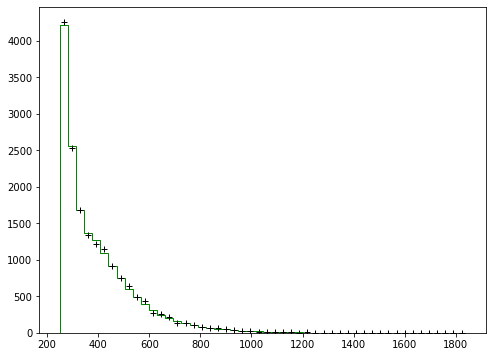

In [290]:
plt.figure(figsize=(8,6))
hb, be, _ = plt.hist(DF[(DF.ntag == 2) & (DF.kinematic_region == 1)].m_hh_cor,
        bins = 50,
        weights = muQCD_med * DF[(DF.ntag == 2) & (DF.kinematic_region == 1)].NN_weight_median_VR,
                    histtype = 'step')
vr4b, _ = np.histogram(DF[(DF.ntag>=4 )&(DF.kinematic_region == 1)].m_hh_cor,
                      bins = be,
                      )
xt = hh.bin_midpoint(be)
plt.plot(xt, vr4b, 'k+')

In [296]:
DF.columns

Index(['run_number', 'event_number', 'mc_sf', 'ntag', 'njets',
       'kinematic_region', 'm_min_dj', 'm_max_dj', 'pairing_score_1',
       'pairing_score_2', 'm_hh_cor', 'm_hh', 'pt_hh', 'dEta_hh', 'X_wt',
       'X_wt_2', 'm_h1', 'E_h1', 'pT_h1', 'eta_h1', 'phi_h1', 'm_h2', 'E_h2',
       'pT_h2', 'eta_h2', 'phi_h2', 'm_h1_j1', 'E_h1_j1', 'pT_h1_j1',
       'eta_h1_j1', 'phi_h1_j1', 'tag_h1_j1', 'quantile_h1_j1', 'angle_h1_j1',
       'm_h1_j2', 'E_h1_j2', 'pT_h1_j2', 'eta_h1_j2', 'phi_h1_j2', 'tag_h1_j2',
       'quantile_h1_j2', 'angle_h1_j2', 'm_h2_j1', 'E_h2_j1', 'pT_h2_j1',
       'eta_h2_j1', 'phi_h2_j1', 'tag_h2_j1', 'quantile_h2_j1', 'angle_h2_j1',
       'm_h2_j2', 'E_h2_j2', 'pT_h2_j2', 'eta_h2_j2', 'phi_h2_j2', 'tag_h2_j2',
       'quantile_h2_j2', 'angle_h2_j2', 'pT_4', 'pT_2', 'eta_i', 'dRjj_1',
       'dRjj_2', 'NN_d24_weight_bstrap_med_17',
       'NN_d24_weight_VRderiv_bstrap_med_17', 'NN_d24_weight_bstrap_IQR_17',
       'NN_d24_weight_VRderiv_bstrap_IQR_17', 'dPhi_h

In [244]:
_dfR[['eta_i_x','eta_i_y']]

eta_i_x   eta_i_y
0        1.627946  1.627946
1        0.493552  0.493552
2        1.923816  1.923816
3        0.527254  0.527254
4        0.501457  0.501457
...           ...       ...
2979236  1.651927  1.651927
2979237  1.045344  1.045344
2979238  0.417066  0.417066
2979239  0.346419  0.346419
2979240  1.474087  1.474087

[2979241 rows x 2 columns]

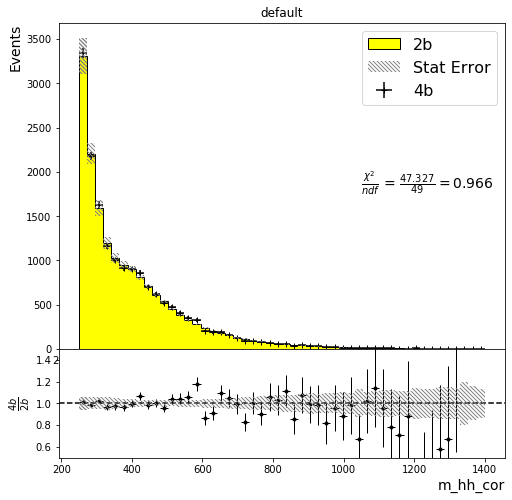

In [301]:
a = bh.reweightedHist(DF, kinematic_region=1, feature='m_hh_cor', bins = 50, hrange=(250,1400),
                 weight_column='NN_weight_median_VR', density = False,
                     bootstrap={'W_med': 'NN_weight_median_VR',
                                'W_IQR': 'NN_weight_IQR_VR',
                                 'mu_med': muQCD_med,
                                 'mu_IQR': u.IQR(muQCD_BS, axis = 0)},
                     pull = None)

Things seem to be ok actually, so let's launch 100 bootstraps to train

In [1000]:
#DF.to_pickle('/mnt/storage/lborgna/data/data17.splitTogether30.pkl')

In [305]:
DF.drop(columns=['NN_weight_median_VR','NN_weight_IQR_VR'], inplace = True)

In [306]:
dfRCR, muQCD_BSCR = nn.repeatNNtrain(DF, repeat = 100, kinematic_region = 2,
                                sort_rw_cols=rw_cols_log,
                                epochs = 100,
                                batch_size = 8192,
                                model_storage_directory = '/mnt/storage/lborgna/models/CR')


  0%|          | 0/100 [00:00<?, ?it/s]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8743 - accuracy: 0.0686 - val_loss: 0.6992 - val_accuracy: 0.0045

Epoch 00001: val_loss improved from inf to 0.69924, saving model to /mnt/storage/lborgna/models/CRbootstrap_n0.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.5165 - accuracy: 0.0038 - val_loss: 0.3979 - val_accuracy: 0.0012

Epoch 00002: val_loss improved from 0.69924 to 0.39791, saving model to /mnt/storage/lborgna/models/CRbootstrap_n0.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3269 - accuracy: 0.0015 - val_loss: 0.2890 - val_accuracy: 8.6559e-04

Epoch 00003: val_loss improved from 0.39791 to 0.28905, saving model to /mnt/storage/lb


  1%|          | 1/100 [00:40<1:06:01, 40.01s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8376 - accuracy: 0.0559 - val_loss: 0.5901 - val_accuracy: 0.0021

Epoch 00001: val_loss improved from inf to 0.59007, saving model to /mnt/storage/lborgna/models/CRbootstrap_n1.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4600 - accuracy: 0.0028 - val_loss: 0.3300 - val_accuracy: 4.6489e-04

Epoch 00002: val_loss improved from 0.59007 to 0.33000, saving model to /mnt/storage/lborgna/models/CRbootstrap_n1.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2997 - accuracy: 0.0014 - val_loss: 0.2790 - val_accuracy: 7.3915e-04

Epoch 00003: val_loss improved from 0.33000 to 0.27900, saving model to /mnt/storag


  2%|▏         | 2/100 [01:09<1:00:02, 36.76s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8374 - accuracy: 0.0557 - val_loss: 0.6559 - val_accuracy: 0.0020

Epoch 00001: val_loss improved from inf to 0.65586, saving model to /mnt/storage/lborgna/models/CRbootstrap_n2.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4626 - accuracy: 0.0026 - val_loss: 0.3428 - val_accuracy: 4.9406e-04

Epoch 00002: val_loss improved from 0.65586 to 0.34280, saving model to /mnt/storage/lborgna/models/CRbootstrap_n2.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2990 - accuracy: 0.0012 - val_loss: 0.2781 - val_accuracy: 5.3102e-04

Epoch 00003: val_loss improved from 0.34280 to 0.27815, saving model to /mnt/storag


  3%|▎         | 3/100 [01:38<55:47, 34.51s/it]  

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8205 - accuracy: 0.0406 - val_loss: 0.5984 - val_accuracy: 0.0013

Epoch 00001: val_loss improved from inf to 0.59842, saving model to /mnt/storage/lborgna/models/CRbootstrap_n3.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4345 - accuracy: 0.0021 - val_loss: 0.3243 - val_accuracy: 8.2085e-04

Epoch 00002: val_loss improved from 0.59842 to 0.32429, saving model to /mnt/storage/lborgna/models/CRbootstrap_n3.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2886 - accuracy: 0.0012 - val_loss: 0.2787 - val_accuracy: 0.0011

Epoch 00003: val_loss improved from 0.32429 to 0.27868, saving model to /mnt/storage/lb


  4%|▍         | 4/100 [02:06<51:57, 32.48s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8472 - accuracy: 0.0578 - val_loss: 0.6334 - val_accuracy: 0.0017

Epoch 00001: val_loss improved from inf to 0.63344, saving model to /mnt/storage/lborgna/models/CRbootstrap_n4.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4734 - accuracy: 0.0027 - val_loss: 0.3457 - val_accuracy: 3.9681e-04

Epoch 00002: val_loss improved from 0.63344 to 0.34575, saving model to /mnt/storage/lborgna/models/CRbootstrap_n4.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3019 - accuracy: 0.0012 - val_loss: 0.2793 - val_accuracy: 5.1741e-04

Epoch 00003: val_loss improved from 0.34575 to 0.27930, saving model to /mnt/storag


  5%|▌         | 5/100 [02:36<50:29, 31.89s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8608 - accuracy: 0.0688 - val_loss: 0.6032 - val_accuracy: 7.1192e-04

Epoch 00001: val_loss improved from inf to 0.60319, saving model to /mnt/storage/lborgna/models/CRbootstrap_n5.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4967 - accuracy: 0.0030 - val_loss: 0.3528 - val_accuracy: 2.0035e-04

Epoch 00002: val_loss improved from 0.60319 to 0.35281, saving model to /mnt/storage/lborgna/models/CRbootstrap_n5.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3146 - accuracy: 0.0013 - val_loss: 0.2817 - val_accuracy: 6.6135e-04

Epoch 00003: val_loss improved from 0.35281 to 0.28171, saving model to /mnt/st


  6%|▌         | 6/100 [03:16<53:33, 34.19s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8368 - accuracy: 0.0586 - val_loss: 0.6327 - val_accuracy: 0.0018

Epoch 00001: val_loss improved from inf to 0.63266, saving model to /mnt/storage/lborgna/models/CRbootstrap_n6.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4589 - accuracy: 0.0028 - val_loss: 0.3379 - val_accuracy: 4.7267e-04

Epoch 00002: val_loss improved from 0.63266 to 0.33794, saving model to /mnt/storage/lborgna/models/CRbootstrap_n6.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2987 - accuracy: 0.0013 - val_loss: 0.2757 - val_accuracy: 8.0529e-04

Epoch 00003: val_loss improved from 0.33794 to 0.27571, saving model to /mnt/storag


  7%|▋         | 7/100 [03:49<52:21, 33.78s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8436 - accuracy: 0.0509 - val_loss: 0.6355 - val_accuracy: 0.0021

Epoch 00001: val_loss improved from inf to 0.63548, saving model to /mnt/storage/lborgna/models/CRbootstrap_n7.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4710 - accuracy: 0.0031 - val_loss: 0.3422 - val_accuracy: 2.9955e-04

Epoch 00002: val_loss improved from 0.63548 to 0.34219, saving model to /mnt/storage/lborgna/models/CRbootstrap_n7.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2990 - accuracy: 0.0014 - val_loss: 0.2781 - val_accuracy: 7.4499e-04

Epoch 00003: val_loss improved from 0.34219 to 0.27814, saving model to /mnt/storag


  8%|▊         | 8/100 [04:19<50:16, 32.79s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8323 - accuracy: 0.0515 - val_loss: 0.6437 - val_accuracy: 0.0022

Epoch 00001: val_loss improved from inf to 0.64375, saving model to /mnt/storage/lborgna/models/CRbootstrap_n8.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4545 - accuracy: 0.0026 - val_loss: 0.3422 - val_accuracy: 6.2633e-04

Epoch 00002: val_loss improved from 0.64375 to 0.34225, saving model to /mnt/storage/lborgna/models/CRbootstrap_n8.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2951 - accuracy: 0.0013 - val_loss: 0.2769 - val_accuracy: 9.5701e-04

Epoch 00003: val_loss improved from 0.34225 to 0.27686, saving model to /mnt/storag


  9%|▉         | 9/100 [04:58<52:33, 34.65s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8393 - accuracy: 0.0489 - val_loss: 0.6225 - val_accuracy: 0.0020

Epoch 00001: val_loss improved from inf to 0.62245, saving model to /mnt/storage/lborgna/models/CRbootstrap_n9.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4581 - accuracy: 0.0026 - val_loss: 0.3334 - val_accuracy: 4.9017e-04

Epoch 00002: val_loss improved from 0.62245 to 0.33344, saving model to /mnt/storage/lborgna/models/CRbootstrap_n9.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2949 - accuracy: 0.0013 - val_loss: 0.2772 - val_accuracy: 9.0449e-04

Epoch 00003: val_loss improved from 0.33344 to 0.27724, saving model to /mnt/storag


 10%|█         | 10/100 [05:27<49:14, 32.82s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8280 - accuracy: 0.0513 - val_loss: 0.6188 - val_accuracy: 8.9087e-04

Epoch 00001: val_loss improved from inf to 0.61884, saving model to /mnt/storage/lborgna/models/CRbootstrap_n10.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4475 - accuracy: 0.0024 - val_loss: 0.3265 - val_accuracy: 3.5596e-04

Epoch 00002: val_loss improved from 0.61884 to 0.32650, saving model to /mnt/storage/lborgna/models/CRbootstrap_n10.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2945 - accuracy: 0.0012 - val_loss: 0.2783 - val_accuracy: 2.6843e-04

Epoch 00003: val_loss improved from 0.32650 to 0.27834, saving model to /mnt/


 11%|█         | 11/100 [05:56<47:19, 31.90s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8606 - accuracy: 0.0668 - val_loss: 0.6604 - val_accuracy: 0.0034

Epoch 00001: val_loss improved from inf to 0.66040, saving model to /mnt/storage/lborgna/models/CRbootstrap_n11.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4906 - accuracy: 0.0030 - val_loss: 0.3556 - val_accuracy: 5.7576e-04

Epoch 00002: val_loss improved from 0.66040 to 0.35563, saving model to /mnt/storage/lborgna/models/CRbootstrap_n11.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3096 - accuracy: 0.0013 - val_loss: 0.2776 - val_accuracy: 6.5357e-04

Epoch 00003: val_loss improved from 0.35563 to 0.27763, saving model to /mnt/stor


 12%|█▏        | 12/100 [06:30<47:38, 32.48s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8423 - accuracy: 0.0493 - val_loss: 0.6228 - val_accuracy: 0.0012

Epoch 00001: val_loss improved from inf to 0.62283, saving model to /mnt/storage/lborgna/models/CRbootstrap_n12.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4580 - accuracy: 0.0025 - val_loss: 0.3295 - val_accuracy: 3.8903e-04

Epoch 00002: val_loss improved from 0.62283 to 0.32950, saving model to /mnt/storage/lborgna/models/CRbootstrap_n12.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2942 - accuracy: 0.0012 - val_loss: 0.2774 - val_accuracy: 6.3217e-04

Epoch 00003: val_loss improved from 0.32950 to 0.27736, saving model to /mnt/stor


 13%|█▎        | 13/100 [06:59<45:20, 31.27s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8640 - accuracy: 0.0560 - val_loss: 0.6321 - val_accuracy: 0.0011

Epoch 00001: val_loss improved from inf to 0.63208, saving model to /mnt/storage/lborgna/models/CRbootstrap_n13.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4920 - accuracy: 0.0028 - val_loss: 0.3466 - val_accuracy: 3.1511e-04

Epoch 00002: val_loss improved from 0.63208 to 0.34661, saving model to /mnt/storage/lborgna/models/CRbootstrap_n13.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3043 - accuracy: 0.0012 - val_loss: 0.2772 - val_accuracy: 4.9406e-04

Epoch 00003: val_loss improved from 0.34661 to 0.27725, saving model to /mnt/stor


 14%|█▍        | 14/100 [07:28<44:10, 30.82s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8513 - accuracy: 0.0651 - val_loss: 0.6399 - val_accuracy: 7.8194e-04

Epoch 00001: val_loss improved from inf to 0.63987, saving model to /mnt/storage/lborgna/models/CRbootstrap_n14.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4763 - accuracy: 0.0024 - val_loss: 0.3529 - val_accuracy: 3.2095e-04

Epoch 00002: val_loss improved from 0.63987 to 0.35286, saving model to /mnt/storage/lborgna/models/CRbootstrap_n14.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3034 - accuracy: 0.0011 - val_loss: 0.2784 - val_accuracy: 7.4304e-04

Epoch 00003: val_loss improved from 0.35286 to 0.27839, saving model to /mnt/


 15%|█▌        | 15/100 [07:55<42:02, 29.68s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8492 - accuracy: 0.0554 - val_loss: 0.6287 - val_accuracy: 9.8424e-04

Epoch 00001: val_loss improved from inf to 0.62872, saving model to /mnt/storage/lborgna/models/CRbootstrap_n15.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4768 - accuracy: 0.0031 - val_loss: 0.3462 - val_accuracy: 4.1042e-04

Epoch 00002: val_loss improved from 0.62872 to 0.34621, saving model to /mnt/storage/lborgna/models/CRbootstrap_n15.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3032 - accuracy: 0.0013 - val_loss: 0.2789 - val_accuracy: 7.9556e-04

Epoch 00003: val_loss improved from 0.34621 to 0.27892, saving model to /mnt/


 16%|█▌        | 16/100 [08:24<40:56, 29.25s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8479 - accuracy: 0.0517 - val_loss: 0.6418 - val_accuracy: 0.0010

Epoch 00001: val_loss improved from inf to 0.64177, saving model to /mnt/storage/lborgna/models/CRbootstrap_n16.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4752 - accuracy: 0.0028 - val_loss: 0.3519 - val_accuracy: 2.9372e-04

Epoch 00002: val_loss improved from 0.64177 to 0.35189, saving model to /mnt/storage/lborgna/models/CRbootstrap_n16.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3010 - accuracy: 0.0013 - val_loss: 0.2789 - val_accuracy: 7.7222e-04

Epoch 00003: val_loss improved from 0.35189 to 0.27887, saving model to /mnt/stor


 17%|█▋        | 17/100 [08:55<41:07, 29.73s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8283 - accuracy: 0.0485 - val_loss: 0.6038 - val_accuracy: 9.4339e-04

Epoch 00001: val_loss improved from inf to 0.60383, saving model to /mnt/storage/lborgna/models/CRbootstrap_n17.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4509 - accuracy: 0.0025 - val_loss: 0.3280 - val_accuracy: 6.2439e-04

Epoch 00002: val_loss improved from 0.60383 to 0.32796, saving model to /mnt/storage/lborgna/models/CRbootstrap_n17.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2955 - accuracy: 0.0013 - val_loss: 0.2787 - val_accuracy: 0.0011

Epoch 00003: val_loss improved from 0.32796 to 0.27868, saving model to /mnt/stor


 18%|█▊        | 18/100 [09:21<39:26, 28.85s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8474 - accuracy: 0.0617 - val_loss: 0.6393 - val_accuracy: 0.0027

Epoch 00001: val_loss improved from inf to 0.63927, saving model to /mnt/storage/lborgna/models/CRbootstrap_n18.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4772 - accuracy: 0.0029 - val_loss: 0.3581 - val_accuracy: 8.1307e-04

Epoch 00002: val_loss improved from 0.63927 to 0.35811, saving model to /mnt/storage/lborgna/models/CRbootstrap_n18.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3068 - accuracy: 0.0013 - val_loss: 0.2830 - val_accuracy: 0.0013

Epoch 00003: val_loss improved from 0.35811 to 0.28301, saving model to /mnt/storage/


 19%|█▉        | 19/100 [09:53<40:17, 29.84s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8306 - accuracy: 0.0512 - val_loss: 0.6003 - val_accuracy: 5.7381e-04

Epoch 00001: val_loss improved from inf to 0.60032, saving model to /mnt/storage/lborgna/models/CRbootstrap_n19.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4487 - accuracy: 0.0027 - val_loss: 0.3346 - val_accuracy: 3.7152e-04

Epoch 00002: val_loss improved from 0.60032 to 0.33459, saving model to /mnt/storage/lborgna/models/CRbootstrap_n19.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2941 - accuracy: 0.0014 - val_loss: 0.2766 - val_accuracy: 8.3057e-04

Epoch 00003: val_loss improved from 0.33459 to 0.27662, saving model to /mnt/


 20%|██        | 20/100 [10:27<41:07, 30.85s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8368 - accuracy: 0.0548 - val_loss: 0.6114 - val_accuracy: 0.0014

Epoch 00001: val_loss improved from inf to 0.61140, saving model to /mnt/storage/lborgna/models/CRbootstrap_n20.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4543 - accuracy: 0.0025 - val_loss: 0.3306 - val_accuracy: 7.5082e-04

Epoch 00002: val_loss improved from 0.61140 to 0.33058, saving model to /mnt/storage/lborgna/models/CRbootstrap_n20.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2947 - accuracy: 0.0013 - val_loss: 0.2750 - val_accuracy: 8.5780e-04

Epoch 00003: val_loss improved from 0.33058 to 0.27503, saving model to /mnt/stor


 21%|██        | 21/100 [10:52<38:26, 29.20s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8502 - accuracy: 0.0594 - val_loss: 0.6432 - val_accuracy: 3.9292e-04

Epoch 00001: val_loss improved from inf to 0.64323, saving model to /mnt/storage/lborgna/models/CRbootstrap_n21.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4933 - accuracy: 0.0032 - val_loss: 0.3633 - val_accuracy: 5.7771e-04

Epoch 00002: val_loss improved from 0.64323 to 0.36328, saving model to /mnt/storage/lborgna/models/CRbootstrap_n21.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3126 - accuracy: 0.0014 - val_loss: 0.2817 - val_accuracy: 7.8583e-04

Epoch 00003: val_loss improved from 0.36328 to 0.28172, saving model to /mnt/


 22%|██▏       | 22/100 [11:19<36:55, 28.40s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8421 - accuracy: 0.0561 - val_loss: 0.6774 - val_accuracy: 0.0028

Epoch 00001: val_loss improved from inf to 0.67739, saving model to /mnt/storage/lborgna/models/CRbootstrap_n22.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4619 - accuracy: 0.0027 - val_loss: 0.3620 - val_accuracy: 6.9441e-04

Epoch 00002: val_loss improved from 0.67739 to 0.36199, saving model to /mnt/storage/lborgna/models/CRbootstrap_n22.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2948 - accuracy: 0.0013 - val_loss: 0.2803 - val_accuracy: 0.0012

Epoch 00003: val_loss improved from 0.36199 to 0.28030, saving model to /mnt/storage/


 23%|██▎       | 23/100 [11:56<39:48, 31.03s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8324 - accuracy: 0.0519 - val_loss: 0.6148 - val_accuracy: 0.0032

Epoch 00001: val_loss improved from inf to 0.61478, saving model to /mnt/storage/lborgna/models/CRbootstrap_n23.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4480 - accuracy: 0.0026 - val_loss: 0.3274 - val_accuracy: 7.6833e-04

Epoch 00002: val_loss improved from 0.61478 to 0.32739, saving model to /mnt/storage/lborgna/models/CRbootstrap_n23.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2917 - accuracy: 0.0013 - val_loss: 0.2787 - val_accuracy: 0.0021

Epoch 00003: val_loss improved from 0.32739 to 0.27874, saving model to /mnt/storage/


 24%|██▍       | 24/100 [12:23<37:53, 29.92s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8218 - accuracy: 0.0517 - val_loss: 0.5880 - val_accuracy: 7.1581e-04

Epoch 00001: val_loss improved from inf to 0.58803, saving model to /mnt/storage/lborgna/models/CRbootstrap_n24.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4451 - accuracy: 0.0025 - val_loss: 0.3285 - val_accuracy: 2.4898e-04

Epoch 00002: val_loss improved from 0.58803 to 0.32851, saving model to /mnt/storage/lborgna/models/CRbootstrap_n24.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2941 - accuracy: 0.0013 - val_loss: 0.2788 - val_accuracy: 6.8858e-04

Epoch 00003: val_loss improved from 0.32851 to 0.27881, saving model to /mnt/


 25%|██▌       | 25/100 [12:49<35:53, 28.71s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8328 - accuracy: 0.0539 - val_loss: 0.6044 - val_accuracy: 0.0013

Epoch 00001: val_loss improved from inf to 0.60438, saving model to /mnt/storage/lborgna/models/CRbootstrap_n25.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4549 - accuracy: 0.0026 - val_loss: 0.3312 - val_accuracy: 5.3686e-04

Epoch 00002: val_loss improved from 0.60438 to 0.33120, saving model to /mnt/storage/lborgna/models/CRbootstrap_n25.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2951 - accuracy: 0.0012 - val_loss: 0.2728 - val_accuracy: 0.0011

Epoch 00003: val_loss improved from 0.33120 to 0.27277, saving model to /mnt/storage/


 26%|██▌       | 26/100 [13:19<35:48, 29.04s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8498 - accuracy: 0.0617 - val_loss: 0.6413 - val_accuracy: 0.0026

Epoch 00001: val_loss improved from inf to 0.64128, saving model to /mnt/storage/lborgna/models/CRbootstrap_n26.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4703 - accuracy: 0.0030 - val_loss: 0.3507 - val_accuracy: 5.8160e-04

Epoch 00002: val_loss improved from 0.64128 to 0.35075, saving model to /mnt/storage/lborgna/models/CRbootstrap_n26.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3003 - accuracy: 0.0013 - val_loss: 0.2784 - val_accuracy: 7.2943e-04

Epoch 00003: val_loss improved from 0.35075 to 0.27836, saving model to /mnt/stor


 27%|██▋       | 27/100 [13:51<36:38, 30.11s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8436 - accuracy: 0.0555 - val_loss: 0.5888 - val_accuracy: 0.0010

Epoch 00001: val_loss improved from inf to 0.58884, saving model to /mnt/storage/lborgna/models/CRbootstrap_n27.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4804 - accuracy: 0.0028 - val_loss: 0.3391 - val_accuracy: 5.0963e-04

Epoch 00002: val_loss improved from 0.58884 to 0.33909, saving model to /mnt/storage/lborgna/models/CRbootstrap_n27.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3068 - accuracy: 0.0013 - val_loss: 0.2777 - val_accuracy: 6.1077e-04

Epoch 00003: val_loss improved from 0.33909 to 0.27774, saving model to /mnt/stor


 28%|██▊       | 28/100 [14:22<36:29, 30.41s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8323 - accuracy: 0.0566 - val_loss: 0.6423 - val_accuracy: 0.0023

Epoch 00001: val_loss improved from inf to 0.64225, saving model to /mnt/storage/lborgna/models/CRbootstrap_n28.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4572 - accuracy: 0.0028 - val_loss: 0.3493 - val_accuracy: 8.3641e-04

Epoch 00002: val_loss improved from 0.64225 to 0.34925, saving model to /mnt/storage/lborgna/models/CRbootstrap_n28.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2978 - accuracy: 0.0014 - val_loss: 0.2777 - val_accuracy: 0.0011

Epoch 00003: val_loss improved from 0.34925 to 0.27768, saving model to /mnt/storage/


 29%|██▉       | 29/100 [14:53<36:12, 30.60s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8399 - accuracy: 0.0546 - val_loss: 0.6409 - val_accuracy: 0.0018

Epoch 00001: val_loss improved from inf to 0.64093, saving model to /mnt/storage/lborgna/models/CRbootstrap_n29.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4611 - accuracy: 0.0024 - val_loss: 0.3376 - val_accuracy: 4.2598e-04

Epoch 00002: val_loss improved from 0.64093 to 0.33761, saving model to /mnt/storage/lborgna/models/CRbootstrap_n29.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2968 - accuracy: 0.0012 - val_loss: 0.2759 - val_accuracy: 8.7531e-04

Epoch 00003: val_loss improved from 0.33761 to 0.27586, saving model to /mnt/stor


 30%|███       | 30/100 [15:23<35:25, 30.37s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8358 - accuracy: 0.0544 - val_loss: 0.6417 - val_accuracy: 0.0016

Epoch 00001: val_loss improved from inf to 0.64168, saving model to /mnt/storage/lborgna/models/CRbootstrap_n30.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4561 - accuracy: 0.0026 - val_loss: 0.3457 - val_accuracy: 4.6100e-04

Epoch 00002: val_loss improved from 0.64168 to 0.34566, saving model to /mnt/storage/lborgna/models/CRbootstrap_n30.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2957 - accuracy: 0.0012 - val_loss: 0.2796 - val_accuracy: 7.1581e-04

Epoch 00003: val_loss improved from 0.34566 to 0.27963, saving model to /mnt/stor


 31%|███       | 31/100 [15:53<34:35, 30.08s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8234 - accuracy: 0.0533 - val_loss: 0.6117 - val_accuracy: 5.5436e-04

Epoch 00001: val_loss improved from inf to 0.61171, saving model to /mnt/storage/lborgna/models/CRbootstrap_n31.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4470 - accuracy: 0.0026 - val_loss: 0.3328 - val_accuracy: 4.4155e-04

Epoch 00002: val_loss improved from 0.61171 to 0.33277, saving model to /mnt/storage/lborgna/models/CRbootstrap_n31.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2940 - accuracy: 0.0013 - val_loss: 0.2777 - val_accuracy: 9.8229e-04

Epoch 00003: val_loss improved from 0.33277 to 0.27769, saving model to /mnt/


 32%|███▏      | 32/100 [16:26<35:13, 31.09s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8357 - accuracy: 0.0543 - val_loss: 0.6392 - val_accuracy: 0.0017

Epoch 00001: val_loss improved from inf to 0.63916, saving model to /mnt/storage/lborgna/models/CRbootstrap_n32.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4561 - accuracy: 0.0027 - val_loss: 0.3387 - val_accuracy: 7.0219e-04

Epoch 00002: val_loss improved from 0.63916 to 0.33872, saving model to /mnt/storage/lborgna/models/CRbootstrap_n32.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2966 - accuracy: 0.0014 - val_loss: 0.2774 - val_accuracy: 7.9167e-04

Epoch 00003: val_loss improved from 0.33872 to 0.27738, saving model to /mnt/stor


 33%|███▎      | 33/100 [16:58<35:03, 31.39s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8479 - accuracy: 0.0595 - val_loss: 0.6420 - val_accuracy: 7.9945e-04

Epoch 00001: val_loss improved from inf to 0.64195, saving model to /mnt/storage/lborgna/models/CRbootstrap_n33.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4812 - accuracy: 0.0030 - val_loss: 0.3584 - val_accuracy: 4.0848e-04

Epoch 00002: val_loss improved from 0.64195 to 0.35845, saving model to /mnt/storage/lborgna/models/CRbootstrap_n33.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3061 - accuracy: 0.0015 - val_loss: 0.2802 - val_accuracy: 3.8903e-04

Epoch 00003: val_loss improved from 0.35845 to 0.28021, saving model to /mnt/


 34%|███▍      | 34/100 [17:28<33:52, 30.80s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8285 - accuracy: 0.0489 - val_loss: 0.6225 - val_accuracy: 0.0017

Epoch 00001: val_loss improved from inf to 0.62251, saving model to /mnt/storage/lborgna/models/CRbootstrap_n34.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4457 - accuracy: 0.0025 - val_loss: 0.3277 - val_accuracy: 4.4933e-04

Epoch 00002: val_loss improved from 0.62251 to 0.32773, saving model to /mnt/storage/lborgna/models/CRbootstrap_n34.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2933 - accuracy: 0.0013 - val_loss: 0.2738 - val_accuracy: 6.1272e-04

Epoch 00003: val_loss improved from 0.32773 to 0.27378, saving model to /mnt/stor


 35%|███▌      | 35/100 [17:57<32:55, 30.39s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8252 - accuracy: 0.0523 - val_loss: 0.6473 - val_accuracy: 0.0057

Epoch 00001: val_loss improved from inf to 0.64731, saving model to /mnt/storage/lborgna/models/CRbootstrap_n35.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4479 - accuracy: 0.0029 - val_loss: 0.3381 - val_accuracy: 9.7840e-04

Epoch 00002: val_loss improved from 0.64731 to 0.33810, saving model to /mnt/storage/lborgna/models/CRbootstrap_n35.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2935 - accuracy: 0.0014 - val_loss: 0.2738 - val_accuracy: 0.0013

Epoch 00003: val_loss improved from 0.33810 to 0.27379, saving model to /mnt/storage/


 36%|███▌      | 36/100 [18:23<30:49, 28.89s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8473 - accuracy: 0.0541 - val_loss: 0.6201 - val_accuracy: 0.0021

Epoch 00001: val_loss improved from inf to 0.62012, saving model to /mnt/storage/lborgna/models/CRbootstrap_n36.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4640 - accuracy: 0.0025 - val_loss: 0.3311 - val_accuracy: 5.0963e-04

Epoch 00002: val_loss improved from 0.62012 to 0.33111, saving model to /mnt/storage/lborgna/models/CRbootstrap_n36.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2969 - accuracy: 0.0012 - val_loss: 0.2760 - val_accuracy: 6.7107e-04

Epoch 00003: val_loss improved from 0.33111 to 0.27597, saving model to /mnt/stor


 37%|███▋      | 37/100 [18:54<31:06, 29.62s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8200 - accuracy: 0.0518 - val_loss: 0.6024 - val_accuracy: 0.0016

Epoch 00001: val_loss improved from inf to 0.60245, saving model to /mnt/storage/lborgna/models/CRbootstrap_n37.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4406 - accuracy: 0.0024 - val_loss: 0.3282 - val_accuracy: 6.0299e-04

Epoch 00002: val_loss improved from 0.60245 to 0.32819, saving model to /mnt/storage/lborgna/models/CRbootstrap_n37.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2950 - accuracy: 0.0013 - val_loss: 0.2774 - val_accuracy: 5.0184e-04

Epoch 00003: val_loss improved from 0.32819 to 0.27740, saving model to /mnt/stor


 38%|███▊      | 38/100 [19:23<30:21, 29.38s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8335 - accuracy: 0.0575 - val_loss: 0.6957 - val_accuracy: 0.0037

Epoch 00001: val_loss improved from inf to 0.69568, saving model to /mnt/storage/lborgna/models/CRbootstrap_n38.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4588 - accuracy: 0.0028 - val_loss: 0.3643 - val_accuracy: 6.5357e-04

Epoch 00002: val_loss improved from 0.69568 to 0.36433, saving model to /mnt/storage/lborgna/models/CRbootstrap_n38.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2989 - accuracy: 0.0013 - val_loss: 0.2806 - val_accuracy: 7.5666e-04

Epoch 00003: val_loss improved from 0.36433 to 0.28062, saving model to /mnt/stor


 39%|███▉      | 39/100 [19:55<30:54, 30.41s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8354 - accuracy: 0.0635 - val_loss: 0.6664 - val_accuracy: 0.0032

Epoch 00001: val_loss improved from inf to 0.66636, saving model to /mnt/storage/lborgna/models/CRbootstrap_n39.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4556 - accuracy: 0.0029 - val_loss: 0.3546 - val_accuracy: 0.0010

Epoch 00002: val_loss improved from 0.66636 to 0.35464, saving model to /mnt/storage/lborgna/models/CRbootstrap_n39.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2983 - accuracy: 0.0014 - val_loss: 0.2784 - val_accuracy: 0.0014

Epoch 00003: val_loss improved from 0.35464 to 0.27844, saving model to /mnt/storage/lbor


 40%|████      | 40/100 [20:27<30:39, 30.66s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8240 - accuracy: 0.0480 - val_loss: 0.5896 - val_accuracy: 0.0012

Epoch 00001: val_loss improved from inf to 0.58961, saving model to /mnt/storage/lborgna/models/CRbootstrap_n40.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4498 - accuracy: 0.0025 - val_loss: 0.3263 - val_accuracy: 6.1272e-04

Epoch 00002: val_loss improved from 0.58961 to 0.32634, saving model to /mnt/storage/lborgna/models/CRbootstrap_n40.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2965 - accuracy: 0.0014 - val_loss: 0.2750 - val_accuracy: 6.4773e-04

Epoch 00003: val_loss improved from 0.32634 to 0.27504, saving model to /mnt/stor


 41%|████      | 41/100 [21:03<31:56, 32.47s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8449 - accuracy: 0.0535 - val_loss: 0.6165 - val_accuracy: 4.0264e-04

Epoch 00001: val_loss improved from inf to 0.61648, saving model to /mnt/storage/lborgna/models/CRbootstrap_n41.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4811 - accuracy: 0.0025 - val_loss: 0.3470 - val_accuracy: 2.6065e-04

Epoch 00002: val_loss improved from 0.61648 to 0.34699, saving model to /mnt/storage/lborgna/models/CRbootstrap_n41.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3066 - accuracy: 0.0011 - val_loss: 0.2802 - val_accuracy: 6.3022e-04

Epoch 00003: val_loss improved from 0.34699 to 0.28016, saving model to /mnt/


 42%|████▏     | 42/100 [21:36<31:23, 32.47s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8269 - accuracy: 0.0562 - val_loss: 0.5851 - val_accuracy: 3.8514e-04

Epoch 00001: val_loss improved from inf to 0.58514, saving model to /mnt/storage/lborgna/models/CRbootstrap_n42.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4608 - accuracy: 0.0029 - val_loss: 0.3374 - val_accuracy: 2.0035e-04

Epoch 00002: val_loss improved from 0.58514 to 0.33738, saving model to /mnt/storage/lborgna/models/CRbootstrap_n42.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3012 - accuracy: 0.0013 - val_loss: 0.2783 - val_accuracy: 5.5436e-04

Epoch 00003: val_loss improved from 0.33738 to 0.27828, saving model to /mnt/


 43%|████▎     | 43/100 [22:08<30:48, 32.43s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8325 - accuracy: 0.0517 - val_loss: 0.6310 - val_accuracy: 0.0022

Epoch 00001: val_loss improved from inf to 0.63101, saving model to /mnt/storage/lborgna/models/CRbootstrap_n43.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4450 - accuracy: 0.0023 - val_loss: 0.3323 - val_accuracy: 6.4968e-04

Epoch 00002: val_loss improved from 0.63101 to 0.33229, saving model to /mnt/storage/lborgna/models/CRbootstrap_n43.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2904 - accuracy: 0.0011 - val_loss: 0.2779 - val_accuracy: 6.3022e-04

Epoch 00003: val_loss improved from 0.33229 to 0.27789, saving model to /mnt/stor


 44%|████▍     | 44/100 [22:41<30:17, 32.45s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8783 - accuracy: 0.0671 - val_loss: 0.7225 - val_accuracy: 0.0039

Epoch 00001: val_loss improved from inf to 0.72251, saving model to /mnt/storage/lborgna/models/CRbootstrap_n44.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.5130 - accuracy: 0.0029 - val_loss: 0.3809 - val_accuracy: 5.8354e-04

Epoch 00002: val_loss improved from 0.72251 to 0.38094, saving model to /mnt/storage/lborgna/models/CRbootstrap_n44.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3141 - accuracy: 0.0011 - val_loss: 0.2807 - val_accuracy: 6.2244e-04

Epoch 00003: val_loss improved from 0.38094 to 0.28071, saving model to /mnt/stor


 45%|████▌     | 45/100 [23:06<27:54, 30.45s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8351 - accuracy: 0.0572 - val_loss: 0.6012 - val_accuracy: 5.5436e-04

Epoch 00001: val_loss improved from inf to 0.60116, saving model to /mnt/storage/lborgna/models/CRbootstrap_n45.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4625 - accuracy: 0.0027 - val_loss: 0.3322 - val_accuracy: 3.0733e-04

Epoch 00002: val_loss improved from 0.60116 to 0.33218, saving model to /mnt/storage/lborgna/models/CRbootstrap_n45.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3000 - accuracy: 0.0012 - val_loss: 0.2783 - val_accuracy: 5.1935e-04

Epoch 00003: val_loss improved from 0.33218 to 0.27829, saving model to /mnt/


 46%|████▌     | 46/100 [23:40<28:19, 31.47s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8337 - accuracy: 0.0494 - val_loss: 0.5706 - val_accuracy: 5.9910e-04

Epoch 00001: val_loss improved from inf to 0.57058, saving model to /mnt/storage/lborgna/models/CRbootstrap_n46.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4557 - accuracy: 0.0028 - val_loss: 0.3227 - val_accuracy: 3.9292e-04

Epoch 00002: val_loss improved from 0.57058 to 0.32269, saving model to /mnt/storage/lborgna/models/CRbootstrap_n46.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2957 - accuracy: 0.0014 - val_loss: 0.2757 - val_accuracy: 0.0011

Epoch 00003: val_loss improved from 0.32269 to 0.27569, saving model to /mnt/stor


 47%|████▋     | 47/100 [24:11<27:36, 31.25s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8315 - accuracy: 0.0520 - val_loss: 0.6013 - val_accuracy: 0.0018

Epoch 00001: val_loss improved from inf to 0.60130, saving model to /mnt/storage/lborgna/models/CRbootstrap_n47.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4531 - accuracy: 0.0026 - val_loss: 0.3309 - val_accuracy: 4.8239e-04

Epoch 00002: val_loss improved from 0.60130 to 0.33092, saving model to /mnt/storage/lborgna/models/CRbootstrap_n47.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2956 - accuracy: 0.0013 - val_loss: 0.2769 - val_accuracy: 6.1466e-04

Epoch 00003: val_loss improved from 0.33092 to 0.27687, saving model to /mnt/stor


 48%|████▊     | 48/100 [24:44<27:24, 31.62s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8343 - accuracy: 0.0595 - val_loss: 0.6378 - val_accuracy: 0.0024

Epoch 00001: val_loss improved from inf to 0.63782, saving model to /mnt/storage/lborgna/models/CRbootstrap_n48.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4571 - accuracy: 0.0026 - val_loss: 0.3449 - val_accuracy: 7.4499e-04

Epoch 00002: val_loss improved from 0.63782 to 0.34485, saving model to /mnt/storage/lborgna/models/CRbootstrap_n48.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2979 - accuracy: 0.0012 - val_loss: 0.2795 - val_accuracy: 0.0013

Epoch 00003: val_loss improved from 0.34485 to 0.27945, saving model to /mnt/storage/


 49%|████▉     | 49/100 [25:13<26:24, 31.06s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8307 - accuracy: 0.0510 - val_loss: 0.6251 - val_accuracy: 0.0013

Epoch 00001: val_loss improved from inf to 0.62510, saving model to /mnt/storage/lborgna/models/CRbootstrap_n49.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4516 - accuracy: 0.0026 - val_loss: 0.3388 - val_accuracy: 0.0010

Epoch 00002: val_loss improved from 0.62510 to 0.33883, saving model to /mnt/storage/lborgna/models/CRbootstrap_n49.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2931 - accuracy: 0.0013 - val_loss: 0.2805 - val_accuracy: 9.0643e-04

Epoch 00003: val_loss improved from 0.33883 to 0.28055, saving model to /mnt/storage/


 50%|█████     | 50/100 [25:42<25:12, 30.26s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8605 - accuracy: 0.0602 - val_loss: 0.6881 - val_accuracy: 0.0029

Epoch 00001: val_loss improved from inf to 0.68810, saving model to /mnt/storage/lborgna/models/CRbootstrap_n50.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4916 - accuracy: 0.0031 - val_loss: 0.3763 - val_accuracy: 5.7965e-04

Epoch 00002: val_loss improved from 0.68810 to 0.37628, saving model to /mnt/storage/lborgna/models/CRbootstrap_n50.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3116 - accuracy: 0.0013 - val_loss: 0.2780 - val_accuracy: 6.8858e-04

Epoch 00003: val_loss improved from 0.37628 to 0.27802, saving model to /mnt/stor


 51%|█████     | 51/100 [26:15<25:31, 31.26s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8393 - accuracy: 0.0566 - val_loss: 0.5985 - val_accuracy: 0.0019

Epoch 00001: val_loss improved from inf to 0.59849, saving model to /mnt/storage/lborgna/models/CRbootstrap_n51.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4549 - accuracy: 0.0028 - val_loss: 0.3316 - val_accuracy: 8.1890e-04

Epoch 00002: val_loss improved from 0.59849 to 0.33162, saving model to /mnt/storage/lborgna/models/CRbootstrap_n51.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2943 - accuracy: 0.0013 - val_loss: 0.2785 - val_accuracy: 0.0012

Epoch 00003: val_loss improved from 0.33162 to 0.27847, saving model to /mnt/storage/


 52%|█████▏    | 52/100 [26:45<24:42, 30.88s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8290 - accuracy: 0.0520 - val_loss: 0.6256 - val_accuracy: 0.0023

Epoch 00001: val_loss improved from inf to 0.62563, saving model to /mnt/storage/lborgna/models/CRbootstrap_n52.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4536 - accuracy: 0.0026 - val_loss: 0.3354 - val_accuracy: 6.6135e-04

Epoch 00002: val_loss improved from 0.62563 to 0.33544, saving model to /mnt/storage/lborgna/models/CRbootstrap_n52.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2962 - accuracy: 0.0013 - val_loss: 0.2742 - val_accuracy: 9.9980e-04

Epoch 00003: val_loss improved from 0.33544 to 0.27423, saving model to /mnt/stor


 53%|█████▎    | 53/100 [27:20<25:10, 32.13s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8528 - accuracy: 0.0590 - val_loss: 0.6074 - val_accuracy: 6.4189e-04

Epoch 00001: val_loss improved from inf to 0.60739, saving model to /mnt/storage/lborgna/models/CRbootstrap_n53.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4825 - accuracy: 0.0035 - val_loss: 0.3344 - val_accuracy: 3.1122e-04

Epoch 00002: val_loss improved from 0.60739 to 0.33436, saving model to /mnt/storage/lborgna/models/CRbootstrap_n53.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3045 - accuracy: 0.0016 - val_loss: 0.2732 - val_accuracy: 8.2085e-04

Epoch 00003: val_loss improved from 0.33436 to 0.27325, saving model to /mnt/


 54%|█████▍    | 54/100 [28:03<26:59, 35.21s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8454 - accuracy: 0.0578 - val_loss: 0.6262 - val_accuracy: 0.0017

Epoch 00001: val_loss improved from inf to 0.62619, saving model to /mnt/storage/lborgna/models/CRbootstrap_n54.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4686 - accuracy: 0.0024 - val_loss: 0.3468 - val_accuracy: 5.3686e-04

Epoch 00002: val_loss improved from 0.62619 to 0.34678, saving model to /mnt/storage/lborgna/models/CRbootstrap_n54.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3014 - accuracy: 0.0011 - val_loss: 0.2802 - val_accuracy: 6.3217e-04

Epoch 00003: val_loss improved from 0.34678 to 0.28016, saving model to /mnt/stor


 55%|█████▌    | 55/100 [28:37<26:13, 34.96s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8645 - accuracy: 0.0692 - val_loss: 0.6567 - val_accuracy: 0.0025

Epoch 00001: val_loss improved from inf to 0.65668, saving model to /mnt/storage/lborgna/models/CRbootstrap_n55.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4996 - accuracy: 0.0034 - val_loss: 0.3732 - val_accuracy: 7.3137e-04

Epoch 00002: val_loss improved from 0.65668 to 0.37323, saving model to /mnt/storage/lborgna/models/CRbootstrap_n55.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3151 - accuracy: 0.0015 - val_loss: 0.2857 - val_accuracy: 7.7611e-04

Epoch 00003: val_loss improved from 0.37323 to 0.28569, saving model to /mnt/stor


 56%|█████▌    | 56/100 [29:11<25:30, 34.77s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8240 - accuracy: 0.0453 - val_loss: 0.6149 - val_accuracy: 0.0029

Epoch 00001: val_loss improved from inf to 0.61491, saving model to /mnt/storage/lborgna/models/CRbootstrap_n56.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4487 - accuracy: 0.0025 - val_loss: 0.3314 - val_accuracy: 5.1741e-04

Epoch 00002: val_loss improved from 0.61491 to 0.33135, saving model to /mnt/storage/lborgna/models/CRbootstrap_n56.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2929 - accuracy: 0.0012 - val_loss: 0.2790 - val_accuracy: 0.0010

Epoch 00003: val_loss improved from 0.33135 to 0.27901, saving model to /mnt/storage/


 57%|█████▋    | 57/100 [29:44<24:27, 34.13s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8416 - accuracy: 0.0591 - val_loss: 0.6159 - val_accuracy: 8.6948e-04

Epoch 00001: val_loss improved from inf to 0.61590, saving model to /mnt/storage/lborgna/models/CRbootstrap_n57.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4729 - accuracy: 0.0028 - val_loss: 0.3504 - val_accuracy: 1.9257e-04

Epoch 00002: val_loss improved from 0.61590 to 0.35041, saving model to /mnt/storage/lborgna/models/CRbootstrap_n57.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3032 - accuracy: 0.0014 - val_loss: 0.2849 - val_accuracy: 4.4738e-04

Epoch 00003: val_loss improved from 0.35041 to 0.28489, saving model to /mnt/


 58%|█████▊    | 58/100 [30:14<22:59, 32.84s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8371 - accuracy: 0.0590 - val_loss: 0.6416 - val_accuracy: 0.0020

Epoch 00001: val_loss improved from inf to 0.64156, saving model to /mnt/storage/lborgna/models/CRbootstrap_n58.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4640 - accuracy: 0.0026 - val_loss: 0.3556 - val_accuracy: 6.7691e-04

Epoch 00002: val_loss improved from 0.64156 to 0.35557, saving model to /mnt/storage/lborgna/models/CRbootstrap_n58.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3030 - accuracy: 0.0014 - val_loss: 0.2794 - val_accuracy: 0.0010

Epoch 00003: val_loss improved from 0.35557 to 0.27943, saving model to /mnt/storage/


 59%|█████▉    | 59/100 [30:44<21:52, 32.00s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8477 - accuracy: 0.0533 - val_loss: 0.5958 - val_accuracy: 0.0010

Epoch 00001: val_loss improved from inf to 0.59577, saving model to /mnt/storage/lborgna/models/CRbootstrap_n59.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4656 - accuracy: 0.0026 - val_loss: 0.3250 - val_accuracy: 7.3332e-04

Epoch 00002: val_loss improved from 0.59577 to 0.32503, saving model to /mnt/storage/lborgna/models/CRbootstrap_n59.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2970 - accuracy: 0.0012 - val_loss: 0.2753 - val_accuracy: 8.4613e-04

Epoch 00003: val_loss improved from 0.32503 to 0.27527, saving model to /mnt/stor


 60%|██████    | 60/100 [31:13<20:38, 30.97s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8334 - accuracy: 0.0524 - val_loss: 0.6199 - val_accuracy: 0.0025

Epoch 00001: val_loss improved from inf to 0.61986, saving model to /mnt/storage/lborgna/models/CRbootstrap_n60.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4481 - accuracy: 0.0027 - val_loss: 0.3314 - val_accuracy: 3.2095e-04

Epoch 00002: val_loss improved from 0.61986 to 0.33135, saving model to /mnt/storage/lborgna/models/CRbootstrap_n60.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2913 - accuracy: 0.0013 - val_loss: 0.2767 - val_accuracy: 0.0010

Epoch 00003: val_loss improved from 0.33135 to 0.27666, saving model to /mnt/storage/


 61%|██████    | 61/100 [31:39<19:10, 29.51s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8234 - accuracy: 0.0539 - val_loss: 0.6006 - val_accuracy: 0.0018

Epoch 00001: val_loss improved from inf to 0.60055, saving model to /mnt/storage/lborgna/models/CRbootstrap_n61.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4476 - accuracy: 0.0026 - val_loss: 0.3325 - val_accuracy: 3.9486e-04

Epoch 00002: val_loss improved from 0.60055 to 0.33251, saving model to /mnt/storage/lborgna/models/CRbootstrap_n61.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2942 - accuracy: 0.0012 - val_loss: 0.2774 - val_accuracy: 0.0011

Epoch 00003: val_loss improved from 0.33251 to 0.27737, saving model to /mnt/storage/


 62%|██████▏   | 62/100 [32:11<19:18, 30.49s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8640 - accuracy: 0.0699 - val_loss: 0.6163 - val_accuracy: 0.0018

Epoch 00001: val_loss improved from inf to 0.61632, saving model to /mnt/storage/lborgna/models/CRbootstrap_n62.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.5016 - accuracy: 0.0035 - val_loss: 0.3698 - val_accuracy: 4.0459e-04

Epoch 00002: val_loss improved from 0.61632 to 0.36984, saving model to /mnt/storage/lborgna/models/CRbootstrap_n62.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3210 - accuracy: 0.0014 - val_loss: 0.2860 - val_accuracy: 6.4189e-04

Epoch 00003: val_loss improved from 0.36984 to 0.28602, saving model to /mnt/stor


 63%|██████▎   | 63/100 [32:43<18:58, 30.76s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8507 - accuracy: 0.0628 - val_loss: 0.5961 - val_accuracy: 0.0018

Epoch 00001: val_loss improved from inf to 0.59614, saving model to /mnt/storage/lborgna/models/CRbootstrap_n63.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4853 - accuracy: 0.0032 - val_loss: 0.3465 - val_accuracy: 0.0010

Epoch 00002: val_loss improved from 0.59614 to 0.34652, saving model to /mnt/storage/lborgna/models/CRbootstrap_n63.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3095 - accuracy: 0.0016 - val_loss: 0.2844 - val_accuracy: 7.3721e-04

Epoch 00003: val_loss improved from 0.34652 to 0.28435, saving model to /mnt/storage/


 64%|██████▍   | 64/100 [33:16<18:49, 31.37s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8663 - accuracy: 0.0656 - val_loss: 0.7012 - val_accuracy: 0.0039

Epoch 00001: val_loss improved from inf to 0.70123, saving model to /mnt/storage/lborgna/models/CRbootstrap_n64.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.5032 - accuracy: 0.0030 - val_loss: 0.3889 - val_accuracy: 6.3411e-04

Epoch 00002: val_loss improved from 0.70123 to 0.38886, saving model to /mnt/storage/lborgna/models/CRbootstrap_n64.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3151 - accuracy: 0.0013 - val_loss: 0.2864 - val_accuracy: 5.3686e-04

Epoch 00003: val_loss improved from 0.38886 to 0.28641, saving model to /mnt/stor


 65%|██████▌   | 65/100 [33:51<19:00, 32.59s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8324 - accuracy: 0.0574 - val_loss: 0.5987 - val_accuracy: 9.9396e-04

Epoch 00001: val_loss improved from inf to 0.59872, saving model to /mnt/storage/lborgna/models/CRbootstrap_n65.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4534 - accuracy: 0.0028 - val_loss: 0.3312 - val_accuracy: 3.0928e-04

Epoch 00002: val_loss improved from 0.59872 to 0.33119, saving model to /mnt/storage/lborgna/models/CRbootstrap_n65.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2941 - accuracy: 0.0013 - val_loss: 0.2763 - val_accuracy: 7.2943e-04

Epoch 00003: val_loss improved from 0.33119 to 0.27627, saving model to /mnt/


 66%|██████▌   | 66/100 [34:23<18:17, 32.27s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8556 - accuracy: 0.0632 - val_loss: 0.7022 - val_accuracy: 0.0045

Epoch 00001: val_loss improved from inf to 0.70224, saving model to /mnt/storage/lborgna/models/CRbootstrap_n66.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4799 - accuracy: 0.0029 - val_loss: 0.3729 - val_accuracy: 7.1386e-04

Epoch 00002: val_loss improved from 0.70224 to 0.37286, saving model to /mnt/storage/lborgna/models/CRbootstrap_n66.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3061 - accuracy: 0.0013 - val_loss: 0.2808 - val_accuracy: 6.0299e-04

Epoch 00003: val_loss improved from 0.37286 to 0.28075, saving model to /mnt/stor


 67%|██████▋   | 67/100 [34:58<18:16, 33.22s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8227 - accuracy: 0.0462 - val_loss: 0.6021 - val_accuracy: 0.0022

Epoch 00001: val_loss improved from inf to 0.60213, saving model to /mnt/storage/lborgna/models/CRbootstrap_n67.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4367 - accuracy: 0.0026 - val_loss: 0.3218 - val_accuracy: 4.3960e-04

Epoch 00002: val_loss improved from 0.60213 to 0.32181, saving model to /mnt/storage/lborgna/models/CRbootstrap_n67.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2889 - accuracy: 0.0012 - val_loss: 0.2776 - val_accuracy: 8.7337e-04

Epoch 00003: val_loss improved from 0.32181 to 0.27763, saving model to /mnt/stor


 68%|██████▊   | 68/100 [35:34<18:12, 34.13s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8617 - accuracy: 0.0564 - val_loss: 0.6732 - val_accuracy: 0.0022

Epoch 00001: val_loss improved from inf to 0.67318, saving model to /mnt/storage/lborgna/models/CRbootstrap_n68.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4932 - accuracy: 0.0031 - val_loss: 0.3583 - val_accuracy: 4.5322e-04

Epoch 00002: val_loss improved from 0.67318 to 0.35827, saving model to /mnt/storage/lborgna/models/CRbootstrap_n68.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3060 - accuracy: 0.0013 - val_loss: 0.2787 - val_accuracy: 7.2554e-04

Epoch 00003: val_loss improved from 0.35827 to 0.27867, saving model to /mnt/stor


 69%|██████▉   | 69/100 [36:09<17:43, 34.31s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8348 - accuracy: 0.0545 - val_loss: 0.6475 - val_accuracy: 0.0036

Epoch 00001: val_loss improved from inf to 0.64753, saving model to /mnt/storage/lborgna/models/CRbootstrap_n69.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4603 - accuracy: 0.0027 - val_loss: 0.3453 - val_accuracy: 0.0011

Epoch 00002: val_loss improved from 0.64753 to 0.34535, saving model to /mnt/storage/lborgna/models/CRbootstrap_n69.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2979 - accuracy: 0.0015 - val_loss: 0.2817 - val_accuracy: 6.3411e-04

Epoch 00003: val_loss improved from 0.34535 to 0.28173, saving model to /mnt/storage/


 70%|███████   | 70/100 [36:44<17:12, 34.43s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8282 - accuracy: 0.0409 - val_loss: 0.5811 - val_accuracy: 9.1810e-04

Epoch 00001: val_loss improved from inf to 0.58111, saving model to /mnt/storage/lborgna/models/CRbootstrap_n70.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4402 - accuracy: 0.0024 - val_loss: 0.3181 - val_accuracy: 3.2678e-04

Epoch 00002: val_loss improved from 0.58111 to 0.31807, saving model to /mnt/storage/lborgna/models/CRbootstrap_n70.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2899 - accuracy: 0.0013 - val_loss: 0.2772 - val_accuracy: 6.6913e-04

Epoch 00003: val_loss improved from 0.31807 to 0.27720, saving model to /mnt/


 71%|███████   | 71/100 [37:18<16:39, 34.46s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8495 - accuracy: 0.0617 - val_loss: 0.6392 - val_accuracy: 0.0013

Epoch 00001: val_loss improved from inf to 0.63922, saving model to /mnt/storage/lborgna/models/CRbootstrap_n71.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4770 - accuracy: 0.0029 - val_loss: 0.3519 - val_accuracy: 4.8434e-04

Epoch 00002: val_loss improved from 0.63922 to 0.35195, saving model to /mnt/storage/lborgna/models/CRbootstrap_n71.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3050 - accuracy: 0.0013 - val_loss: 0.2778 - val_accuracy: 7.2748e-04

Epoch 00003: val_loss improved from 0.35195 to 0.27780, saving model to /mnt/stor


 72%|███████▏  | 72/100 [37:51<15:52, 34.03s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8257 - accuracy: 0.0586 - val_loss: 0.6304 - val_accuracy: 0.0026

Epoch 00001: val_loss improved from inf to 0.63044, saving model to /mnt/storage/lborgna/models/CRbootstrap_n72.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4495 - accuracy: 0.0027 - val_loss: 0.3449 - val_accuracy: 7.8778e-04

Epoch 00002: val_loss improved from 0.63044 to 0.34488, saving model to /mnt/storage/lborgna/models/CRbootstrap_n72.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2986 - accuracy: 0.0013 - val_loss: 0.2782 - val_accuracy: 7.9945e-04

Epoch 00003: val_loss improved from 0.34488 to 0.27824, saving model to /mnt/stor


 73%|███████▎  | 73/100 [38:20<14:38, 32.52s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8349 - accuracy: 0.0541 - val_loss: 0.6295 - val_accuracy: 0.0032

Epoch 00001: val_loss improved from inf to 0.62948, saving model to /mnt/storage/lborgna/models/CRbootstrap_n73.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4662 - accuracy: 0.0026 - val_loss: 0.3505 - val_accuracy: 8.7920e-04

Epoch 00002: val_loss improved from 0.62948 to 0.35054, saving model to /mnt/storage/lborgna/models/CRbootstrap_n73.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2999 - accuracy: 0.0013 - val_loss: 0.2817 - val_accuracy: 9.8035e-04

Epoch 00003: val_loss improved from 0.35054 to 0.28170, saving model to /mnt/stor


 74%|███████▍  | 74/100 [38:51<13:48, 31.86s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8656 - accuracy: 0.0678 - val_loss: 0.7141 - val_accuracy: 0.0050

Epoch 00001: val_loss improved from inf to 0.71406, saving model to /mnt/storage/lborgna/models/CRbootstrap_n74.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4982 - accuracy: 0.0036 - val_loss: 0.3792 - val_accuracy: 7.4888e-04

Epoch 00002: val_loss improved from 0.71406 to 0.37920, saving model to /mnt/storage/lborgna/models/CRbootstrap_n74.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3074 - accuracy: 0.0014 - val_loss: 0.2783 - val_accuracy: 7.4304e-04

Epoch 00003: val_loss improved from 0.37920 to 0.27835, saving model to /mnt/stor


 75%|███████▌  | 75/100 [39:17<12:34, 30.18s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8396 - accuracy: 0.0549 - val_loss: 0.6305 - val_accuracy: 0.0029

Epoch 00001: val_loss improved from inf to 0.63049, saving model to /mnt/storage/lborgna/models/CRbootstrap_n75.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4688 - accuracy: 0.0030 - val_loss: 0.3432 - val_accuracy: 9.0254e-04

Epoch 00002: val_loss improved from 0.63049 to 0.34316, saving model to /mnt/storage/lborgna/models/CRbootstrap_n75.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3008 - accuracy: 0.0015 - val_loss: 0.2792 - val_accuracy: 0.0011

Epoch 00003: val_loss improved from 0.34316 to 0.27915, saving model to /mnt/storage/


 76%|███████▌  | 76/100 [39:52<12:42, 31.77s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8361 - accuracy: 0.0538 - val_loss: 0.6146 - val_accuracy: 0.0014

Epoch 00001: val_loss improved from inf to 0.61464, saving model to /mnt/storage/lborgna/models/CRbootstrap_n76.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4635 - accuracy: 0.0026 - val_loss: 0.3397 - val_accuracy: 6.0883e-04

Epoch 00002: val_loss improved from 0.61464 to 0.33969, saving model to /mnt/storage/lborgna/models/CRbootstrap_n76.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3014 - accuracy: 0.0014 - val_loss: 0.2776 - val_accuracy: 7.3915e-04

Epoch 00003: val_loss improved from 0.33969 to 0.27764, saving model to /mnt/stor


 77%|███████▋  | 77/100 [40:18<11:31, 30.07s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8457 - accuracy: 0.0580 - val_loss: 0.6730 - val_accuracy: 0.0045

Epoch 00001: val_loss improved from inf to 0.67305, saving model to /mnt/storage/lborgna/models/CRbootstrap_n77.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4683 - accuracy: 0.0026 - val_loss: 0.3518 - val_accuracy: 0.0011

Epoch 00002: val_loss improved from 0.67305 to 0.35183, saving model to /mnt/storage/lborgna/models/CRbootstrap_n77.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3007 - accuracy: 0.0012 - val_loss: 0.2815 - val_accuracy: 0.0011

Epoch 00003: val_loss improved from 0.35183 to 0.28146, saving model to /mnt/storage/lbor


 78%|███████▊  | 78/100 [40:49<11:02, 30.11s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8585 - accuracy: 0.0615 - val_loss: 0.6202 - val_accuracy: 0.0010

Epoch 00001: val_loss improved from inf to 0.62024, saving model to /mnt/storage/lborgna/models/CRbootstrap_n78.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4963 - accuracy: 0.0032 - val_loss: 0.3511 - val_accuracy: 2.8204e-04

Epoch 00002: val_loss improved from 0.62024 to 0.35113, saving model to /mnt/storage/lborgna/models/CRbootstrap_n78.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3105 - accuracy: 0.0015 - val_loss: 0.2800 - val_accuracy: 6.8469e-04

Epoch 00003: val_loss improved from 0.35113 to 0.28000, saving model to /mnt/stor


 79%|███████▉  | 79/100 [41:20<10:42, 30.59s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8311 - accuracy: 0.0583 - val_loss: 0.6065 - val_accuracy: 0.0020

Epoch 00001: val_loss improved from inf to 0.60651, saving model to /mnt/storage/lborgna/models/CRbootstrap_n79.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4583 - accuracy: 0.0026 - val_loss: 0.3293 - val_accuracy: 4.7072e-04

Epoch 00002: val_loss improved from 0.60651 to 0.32930, saving model to /mnt/storage/lborgna/models/CRbootstrap_n79.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2996 - accuracy: 0.0013 - val_loss: 0.2768 - val_accuracy: 5.0379e-04

Epoch 00003: val_loss improved from 0.32930 to 0.27679, saving model to /mnt/stor


 80%|████████  | 80/100 [41:54<10:32, 31.61s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8424 - accuracy: 0.0563 - val_loss: 0.6089 - val_accuracy: 0.0014

Epoch 00001: val_loss improved from inf to 0.60893, saving model to /mnt/storage/lborgna/models/CRbootstrap_n80.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4591 - accuracy: 0.0027 - val_loss: 0.3283 - val_accuracy: 2.8983e-04

Epoch 00002: val_loss improved from 0.60893 to 0.32834, saving model to /mnt/storage/lborgna/models/CRbootstrap_n80.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2963 - accuracy: 0.0013 - val_loss: 0.2777 - val_accuracy: 5.0184e-04

Epoch 00003: val_loss improved from 0.32834 to 0.27766, saving model to /mnt/stor


 81%|████████  | 81/100 [42:24<09:51, 31.12s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8400 - accuracy: 0.0551 - val_loss: 0.6346 - val_accuracy: 0.0021

Epoch 00001: val_loss improved from inf to 0.63462, saving model to /mnt/storage/lborgna/models/CRbootstrap_n81.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4637 - accuracy: 0.0026 - val_loss: 0.3422 - val_accuracy: 7.7027e-04

Epoch 00002: val_loss improved from 0.63462 to 0.34216, saving model to /mnt/storage/lborgna/models/CRbootstrap_n81.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2981 - accuracy: 0.0014 - val_loss: 0.2811 - val_accuracy: 4.0653e-04

Epoch 00003: val_loss improved from 0.34216 to 0.28107, saving model to /mnt/stor


 82%|████████▏ | 82/100 [42:52<09:01, 30.07s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8314 - accuracy: 0.0552 - val_loss: 0.6338 - val_accuracy: 0.0012

Epoch 00001: val_loss improved from inf to 0.63377, saving model to /mnt/storage/lborgna/models/CRbootstrap_n82.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4483 - accuracy: 0.0027 - val_loss: 0.3418 - val_accuracy: 3.6374e-04

Epoch 00002: val_loss improved from 0.63377 to 0.34185, saving model to /mnt/storage/lborgna/models/CRbootstrap_n82.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2933 - accuracy: 0.0013 - val_loss: 0.2799 - val_accuracy: 5.4075e-04

Epoch 00003: val_loss improved from 0.34185 to 0.27993, saving model to /mnt/stor


 83%|████████▎ | 83/100 [43:24<08:39, 30.57s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8506 - accuracy: 0.0583 - val_loss: 0.6446 - val_accuracy: 0.0016

Epoch 00001: val_loss improved from inf to 0.64464, saving model to /mnt/storage/lborgna/models/CRbootstrap_n83.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4733 - accuracy: 0.0029 - val_loss: 0.3485 - val_accuracy: 3.0928e-04

Epoch 00002: val_loss improved from 0.64464 to 0.34854, saving model to /mnt/storage/lborgna/models/CRbootstrap_n83.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2993 - accuracy: 0.0013 - val_loss: 0.2742 - val_accuracy: 0.0011

Epoch 00003: val_loss improved from 0.34854 to 0.27417, saving model to /mnt/storage/


 84%|████████▍ | 84/100 [44:07<09:09, 34.35s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8521 - accuracy: 0.0646 - val_loss: 0.6046 - val_accuracy: 2.3536e-04

Epoch 00001: val_loss improved from inf to 0.60460, saving model to /mnt/storage/lborgna/models/CRbootstrap_n84.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4811 - accuracy: 0.0033 - val_loss: 0.3489 - val_accuracy: 2.5092e-04

Epoch 00002: val_loss improved from 0.60460 to 0.34890, saving model to /mnt/storage/lborgna/models/CRbootstrap_n84.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3083 - accuracy: 0.0015 - val_loss: 0.2803 - val_accuracy: 5.0768e-04

Epoch 00003: val_loss improved from 0.34890 to 0.28033, saving model to /mnt/


 85%|████████▌ | 85/100 [44:39<08:25, 33.68s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8443 - accuracy: 0.0548 - val_loss: 0.6151 - val_accuracy: 0.0026

Epoch 00001: val_loss improved from inf to 0.61512, saving model to /mnt/storage/lborgna/models/CRbootstrap_n85.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4660 - accuracy: 0.0026 - val_loss: 0.3317 - val_accuracy: 8.5975e-04

Epoch 00002: val_loss improved from 0.61512 to 0.33170, saving model to /mnt/storage/lborgna/models/CRbootstrap_n85.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2972 - accuracy: 0.0012 - val_loss: 0.2777 - val_accuracy: 7.9167e-04

Epoch 00003: val_loss improved from 0.33170 to 0.27766, saving model to /mnt/stor


 86%|████████▌ | 86/100 [45:10<07:39, 32.84s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8514 - accuracy: 0.0632 - val_loss: 0.5909 - val_accuracy: 0.0021

Epoch 00001: val_loss improved from inf to 0.59095, saving model to /mnt/storage/lborgna/models/CRbootstrap_n86.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4916 - accuracy: 0.0036 - val_loss: 0.3467 - val_accuracy: 6.2439e-04

Epoch 00002: val_loss improved from 0.59095 to 0.34672, saving model to /mnt/storage/lborgna/models/CRbootstrap_n86.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3141 - accuracy: 0.0015 - val_loss: 0.2800 - val_accuracy: 9.0643e-04

Epoch 00003: val_loss improved from 0.34672 to 0.28000, saving model to /mnt/stor


 87%|████████▋ | 87/100 [45:52<07:45, 35.79s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8224 - accuracy: 0.0522 - val_loss: 0.5661 - val_accuracy: 1.1282e-04

Epoch 00001: val_loss improved from inf to 0.56605, saving model to /mnt/storage/lborgna/models/CRbootstrap_n87.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4457 - accuracy: 0.0025 - val_loss: 0.3231 - val_accuracy: 2.8204e-04

Epoch 00002: val_loss improved from 0.56605 to 0.32313, saving model to /mnt/storage/lborgna/models/CRbootstrap_n87.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2952 - accuracy: 0.0013 - val_loss: 0.2780 - val_accuracy: 5.1546e-04

Epoch 00003: val_loss improved from 0.32313 to 0.27802, saving model to /mnt/


 88%|████████▊ | 88/100 [46:28<07:10, 35.86s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8445 - accuracy: 0.0592 - val_loss: 0.6397 - val_accuracy: 0.0011

Epoch 00001: val_loss improved from inf to 0.63967, saving model to /mnt/storage/lborgna/models/CRbootstrap_n88.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4719 - accuracy: 0.0029 - val_loss: 0.3477 - val_accuracy: 3.4818e-04

Epoch 00002: val_loss improved from 0.63967 to 0.34770, saving model to /mnt/storage/lborgna/models/CRbootstrap_n88.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3029 - accuracy: 0.0013 - val_loss: 0.2800 - val_accuracy: 0.0012

Epoch 00003: val_loss improved from 0.34770 to 0.28002, saving model to /mnt/storage/


 89%|████████▉ | 89/100 [46:56<06:08, 33.50s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8791 - accuracy: 0.0665 - val_loss: 0.6494 - val_accuracy: 0.0038

Epoch 00001: val_loss improved from inf to 0.64942, saving model to /mnt/storage/lborgna/models/CRbootstrap_n89.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.5277 - accuracy: 0.0038 - val_loss: 0.3811 - val_accuracy: 4.4933e-04

Epoch 00002: val_loss improved from 0.64942 to 0.38114, saving model to /mnt/storage/lborgna/models/CRbootstrap_n89.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3335 - accuracy: 0.0015 - val_loss: 0.2865 - val_accuracy: 4.5905e-04

Epoch 00003: val_loss improved from 0.38114 to 0.28648, saving model to /mnt/stor


 90%|█████████ | 90/100 [47:33<05:45, 34.55s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8540 - accuracy: 0.0591 - val_loss: 0.6428 - val_accuracy: 6.0688e-04

Epoch 00001: val_loss improved from inf to 0.64278, saving model to /mnt/storage/lborgna/models/CRbootstrap_n90.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4778 - accuracy: 0.0027 - val_loss: 0.3464 - val_accuracy: 4.5905e-04

Epoch 00002: val_loss improved from 0.64278 to 0.34640, saving model to /mnt/storage/lborgna/models/CRbootstrap_n90.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3005 - accuracy: 0.0012 - val_loss: 0.2816 - val_accuracy: 7.4304e-04

Epoch 00003: val_loss improved from 0.34640 to 0.28163, saving model to /mnt/


 91%|█████████ | 91/100 [48:00<04:49, 32.14s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8314 - accuracy: 0.0585 - val_loss: 0.6136 - val_accuracy: 0.0011

Epoch 00001: val_loss improved from inf to 0.61357, saving model to /mnt/storage/lborgna/models/CRbootstrap_n91.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4554 - accuracy: 0.0025 - val_loss: 0.3412 - val_accuracy: 5.5242e-04

Epoch 00002: val_loss improved from 0.61357 to 0.34117, saving model to /mnt/storage/lborgna/models/CRbootstrap_n91.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2986 - accuracy: 0.0012 - val_loss: 0.2806 - val_accuracy: 8.1112e-04

Epoch 00003: val_loss improved from 0.34117 to 0.28058, saving model to /mnt/stor


 92%|█████████▏| 92/100 [48:32<04:16, 32.08s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8410 - accuracy: 0.0544 - val_loss: 0.6439 - val_accuracy: 0.0015

Epoch 00001: val_loss improved from inf to 0.64392, saving model to /mnt/storage/lborgna/models/CRbootstrap_n92.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4594 - accuracy: 0.0026 - val_loss: 0.3448 - val_accuracy: 3.7930e-04

Epoch 00002: val_loss improved from 0.64392 to 0.34480, saving model to /mnt/storage/lborgna/models/CRbootstrap_n92.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2951 - accuracy: 0.0013 - val_loss: 0.2798 - val_accuracy: 4.5905e-04

Epoch 00003: val_loss improved from 0.34480 to 0.27975, saving model to /mnt/stor


 93%|█████████▎| 93/100 [49:00<03:35, 30.78s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8675 - accuracy: 0.0795 - val_loss: 0.7173 - val_accuracy: 0.0045

Epoch 00001: val_loss improved from inf to 0.71730, saving model to /mnt/storage/lborgna/models/CRbootstrap_n93.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.5009 - accuracy: 0.0033 - val_loss: 0.4134 - val_accuracy: 0.0010

Epoch 00002: val_loss improved from 0.71730 to 0.41345, saving model to /mnt/storage/lborgna/models/CRbootstrap_n93.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3235 - accuracy: 0.0013 - val_loss: 0.2951 - val_accuracy: 9.2199e-04

Epoch 00003: val_loss improved from 0.41345 to 0.29507, saving model to /mnt/storage/


 94%|█████████▍| 94/100 [49:33<03:08, 31.44s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8370 - accuracy: 0.0535 - val_loss: 0.6044 - val_accuracy: 3.4623e-04

Epoch 00001: val_loss improved from inf to 0.60436, saving model to /mnt/storage/lborgna/models/CRbootstrap_n94.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4573 - accuracy: 0.0024 - val_loss: 0.3340 - val_accuracy: 2.9761e-04

Epoch 00002: val_loss improved from 0.60436 to 0.33404, saving model to /mnt/storage/lborgna/models/CRbootstrap_n94.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2955 - accuracy: 0.0012 - val_loss: 0.2783 - val_accuracy: 6.4968e-04

Epoch 00003: val_loss improved from 0.33404 to 0.27827, saving model to /mnt/


 95%|█████████▌| 95/100 [50:03<02:35, 31.16s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8455 - accuracy: 0.0541 - val_loss: 0.6165 - val_accuracy: 6.9247e-04

Epoch 00001: val_loss improved from inf to 0.61652, saving model to /mnt/storage/lborgna/models/CRbootstrap_n95.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4748 - accuracy: 0.0025 - val_loss: 0.3390 - val_accuracy: 1.6534e-04

Epoch 00002: val_loss improved from 0.61652 to 0.33903, saving model to /mnt/storage/lborgna/models/CRbootstrap_n95.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3013 - accuracy: 0.0012 - val_loss: 0.2772 - val_accuracy: 6.7107e-04

Epoch 00003: val_loss improved from 0.33903 to 0.27716, saving model to /mnt/


 96%|█████████▌| 96/100 [50:36<02:06, 31.71s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8489 - accuracy: 0.0568 - val_loss: 0.6629 - val_accuracy: 0.0022

Epoch 00001: val_loss improved from inf to 0.66292, saving model to /mnt/storage/lborgna/models/CRbootstrap_n96.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4677 - accuracy: 0.0029 - val_loss: 0.3457 - val_accuracy: 6.5551e-04

Epoch 00002: val_loss improved from 0.66292 to 0.34572, saving model to /mnt/storage/lborgna/models/CRbootstrap_n96.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2967 - accuracy: 0.0014 - val_loss: 0.2784 - val_accuracy: 7.3332e-04

Epoch 00003: val_loss improved from 0.34572 to 0.27842, saving model to /mnt/stor


 97%|█████████▋| 97/100 [51:03<01:30, 30.17s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8811 - accuracy: 0.0709 - val_loss: 0.6094 - val_accuracy: 0.0013

Epoch 00001: val_loss improved from inf to 0.60936, saving model to /mnt/storage/lborgna/models/CRbootstrap_n97.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.5320 - accuracy: 0.0040 - val_loss: 0.3800 - val_accuracy: 4.0653e-04

Epoch 00002: val_loss improved from 0.60936 to 0.38001, saving model to /mnt/storage/lborgna/models/CRbootstrap_n97.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3377 - accuracy: 0.0016 - val_loss: 0.2901 - val_accuracy: 5.9327e-04

Epoch 00003: val_loss improved from 0.38001 to 0.29014, saving model to /mnt/stor


 98%|█████████▊| 98/100 [51:44<01:06, 33.50s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8586 - accuracy: 0.0612 - val_loss: 0.6591 - val_accuracy: 0.0028

Epoch 00001: val_loss improved from inf to 0.65906, saving model to /mnt/storage/lborgna/models/CRbootstrap_n98.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4898 - accuracy: 0.0034 - val_loss: 0.3556 - val_accuracy: 6.3411e-04

Epoch 00002: val_loss improved from 0.65906 to 0.35562, saving model to /mnt/storage/lborgna/models/CRbootstrap_n98.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.3061 - accuracy: 0.0014 - val_loss: 0.2826 - val_accuracy: 6.9247e-04

Epoch 00003: val_loss improved from 0.35562 to 0.28256, saving model to /mnt/stor


 99%|█████████▉| 99/100 [52:16<00:33, 33.08s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 771154 samples, validate on 514103 samples
Epoch 1/100
771154/771154 [==============================] - 2s 3us/step - loss: 0.8466 - accuracy: 0.0485 - val_loss: 0.6498 - val_accuracy: 0.0017

Epoch 00001: val_loss improved from inf to 0.64976, saving model to /mnt/storage/lborgna/models/CRbootstrap_n99.h5
Epoch 2/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.4668 - accuracy: 0.0026 - val_loss: 0.3329 - val_accuracy: 4.2598e-04

Epoch 00002: val_loss improved from 0.64976 to 0.33290, saving model to /mnt/storage/lborgna/models/CRbootstrap_n99.h5
Epoch 3/100
771154/771154 [==============================] - 1s 2us/step - loss: 0.2950 - accuracy: 0.0013 - val_loss: 0.2735 - val_accuracy: 3.5790e-04

Epoch 00003: val_loss improved from 0.33290 to 0.27348, saving model to /mnt/stor


100%|██████████| 100/100 [52:51<00:00, 31.72s/it]


['NN_weightCR_bs_0', 'NN_weightCR_bs_1', 'NN_weightCR_bs_2', 'NN_weightCR_bs_3', 'NN_weightCR_bs_4', 'NN_weightCR_bs_5', 'NN_weightCR_bs_6', 'NN_weightCR_bs_7', 'NN_weightCR_bs_8', 'NN_weightCR_bs_9', 'NN_weightCR_bs_10', 'NN_weightCR_bs_11', 'NN_weightCR_bs_12', 'NN_weightCR_bs_13', 'NN_weightCR_bs_14', 'NN_weightCR_bs_15', 'NN_weightCR_bs_16', 'NN_weightCR_bs_17', 'NN_weightCR_bs_18', 'NN_weightCR_bs_19', 'NN_weightCR_bs_20', 'NN_weightCR_bs_21', 'NN_weightCR_bs_22', 'NN_weightCR_bs_23', 'NN_weightCR_bs_24', 'NN_weightCR_bs_25', 'NN_weightCR_bs_26', 'NN_weightCR_bs_27', 'NN_weightCR_bs_28', 'NN_weightCR_bs_29', 'NN_weightCR_bs_30', 'NN_weightCR_bs_31', 'NN_weightCR_bs_32', 'NN_weightCR_bs_33', 'NN_weightCR_bs_34', 'NN_weightCR_bs_35', 'NN_weightCR_bs_36', 'NN_weightCR_bs_37', 'NN_weightCR_bs_38', 'NN_weightCR_bs_39', 'NN_weightCR_bs_40', 'NN_weightCR_bs_41', 'NN_weightCR_bs_42', 'NN_weightCR_bs_43', 'NN_weightCR_bs_44', 'NN_weightCR_bs_45', 'NN_weightCR_bs_46', 'NN_weightCR_bs_47', '

In [1002]:
dfRCR.to_pickle('/mnt/storage/lborgna/models/CR/dat_weightsCR.pkl')
np.save('/mnt/storage/lborgna/models/CR/muQCD_BS_CR.npy', muQCD_BSCR)

In [311]:
!ls -lh /mnt/storage/lborgna/models/VR/

total 2.4G
-rw-r--r-- 1 lborgna users 2.4G May 27 02:05 dat_weightsVR.pkl
-rw-r--r-- 1 lborgna users  928 May 27 02:05 muQCD_BS_VR.npy


In [314]:
!ls -lh /mnt/storage/lborgna/models/

total 55M
-rw-r--r-- 1 lborgna users 124K May 13 02:55 bootsrap_n0.h5
-rw-r--r-- 1 lborgna users 124K May 13 02:50 bootsrap_n1.h5
-rw-r--r-- 1 lborgna users 124K May 13 02:50 bootsrap_n2.h5
-rw-r--r-- 1 lborgna users 124K May 27 00:00 bootstrap_n0.h5
-rw-r--r-- 1 lborgna users 124K May 27 00:03 bootstrap_n10.h5
-rw-r--r-- 1 lborgna users 124K May 27 00:04 bootstrap_n11.h5
-rw-r--r-- 1 lborgna users 124K May 27 00:04 bootstrap_n12.h5
-rw-r--r-- 1 lborgna users 124K May 27 00:04 bootstrap_n13.h5
-rw-r--r-- 1 lborgna users 124K May 27 00:05 bootstrap_n14.h5
-rw-r--r-- 1 lborgna users 124K May 27 00:05 bootstrap_n15.h5
-rw-r--r-- 1 lborgna users 124K May 27 00:05 bootstrap_n16.h5
-rw-r--r-- 1 lborgna users 124K May 27 00:06 bootstrap_n17.h5
-rw-r--r-- 1 lborgna users 124K May 27 00:06 bootstrap_n18.h5
-rw-r--r-- 1 lborgna users 124K May 27 00:06 bootstrap_n19.h5
-rw-r--r-- 1 lborgna users 124K May 27 00:00 bootstrap_n1.h5
-rw-r--r-- 1 lborgna users 124K May 27 00:07 bootstrap_n20.h5
-rw-r-

In [1003]:
dfRVR, muQCD_BSVR = nn.repeatNNtrain(DF, repeat = 100, kinematic_region = 1,
                                sort_rw_cols=rw_cols_log,
                                epochs = 100,
                                batch_size = 8192,
                                model_storage_directory = '/mnt/storage/lborgna/models/VR')


  0%|          | 0/100 [00:00<?, ?it/s]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9333 - accuracy: 0.0891 - val_loss: 0.7687 - val_accuracy: 0.0096

Epoch 00001: val_loss improved from inf to 0.76874, saving model to /mnt/storage/lborgna/models/VRbootsrap_n0.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6827 - accuracy: 0.0092 - val_loss: 0.5603 - val_accuracy: 7.9242e-04

Epoch 00002: val_loss improved from 0.76874 to 0.56026, saving model to /mnt/storage/lborgna/models/VRbootsrap_n0.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4648 - accuracy: 0.0030 - val_loss: 0.3796 - val_accuracy: 4.5564e-04

Epoch 00003: val_loss improved from 0.56026 to 0.37961, saving model to /mnt/storage/


  1%|          | 1/100 [00:24<40:38, 24.63s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9205 - accuracy: 0.0739 - val_loss: 0.8059 - val_accuracy: 0.0159

Epoch 00001: val_loss improved from inf to 0.80589, saving model to /mnt/storage/lborgna/models/VRbootsrap_n1.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6683 - accuracy: 0.0084 - val_loss: 0.5606 - val_accuracy: 0.0017

Epoch 00002: val_loss improved from 0.80589 to 0.56058, saving model to /mnt/storage/lborgna/models/VRbootsrap_n1.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4485 - accuracy: 0.0027 - val_loss: 0.3769 - val_accuracy: 8.5515e-04

Epoch 00003: val_loss improved from 0.56058 to 0.37689, saving model to /mnt/storage/lbor


  2%|▏         | 2/100 [00:49<40:18, 24.68s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9242 - accuracy: 0.0914 - val_loss: 0.8021 - val_accuracy: 0.0156

Epoch 00001: val_loss improved from inf to 0.80214, saving model to /mnt/storage/lborgna/models/VRbootsrap_n2.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6572 - accuracy: 0.0082 - val_loss: 0.5753 - val_accuracy: 0.0014

Epoch 00002: val_loss improved from 0.80214 to 0.57534, saving model to /mnt/storage/lborgna/models/VRbootsrap_n2.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4499 - accuracy: 0.0026 - val_loss: 0.3898 - val_accuracy: 7.5280e-04

Epoch 00003: val_loss improved from 0.57534 to 0.38979, saving model to /mnt/storage/lbor


  3%|▎         | 3/100 [01:12<39:00, 24.13s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9362 - accuracy: 0.0911 - val_loss: 0.7298 - val_accuracy: 0.0062

Epoch 00001: val_loss improved from inf to 0.72976, saving model to /mnt/storage/lborgna/models/VRbootsrap_n3.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6762 - accuracy: 0.0094 - val_loss: 0.5005 - val_accuracy: 9.9712e-04

Epoch 00002: val_loss improved from 0.72976 to 0.50053, saving model to /mnt/storage/lborgna/models/VRbootsrap_n3.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4684 - accuracy: 0.0029 - val_loss: 0.3542 - val_accuracy: 8.4855e-04

Epoch 00003: val_loss improved from 0.50053 to 0.35424, saving model to /mnt/storage/


  4%|▍         | 4/100 [01:34<37:47, 23.62s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9194 - accuracy: 0.0805 - val_loss: 0.7424 - val_accuracy: 0.0066

Epoch 00001: val_loss improved from inf to 0.74243, saving model to /mnt/storage/lborgna/models/VRbootsrap_n4.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6651 - accuracy: 0.0084 - val_loss: 0.4996 - val_accuracy: 4.6885e-04

Epoch 00002: val_loss improved from 0.74243 to 0.49958, saving model to /mnt/storage/lborgna/models/VRbootsrap_n4.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4508 - accuracy: 0.0027 - val_loss: 0.3530 - val_accuracy: 4.3583e-04

Epoch 00003: val_loss improved from 0.49958 to 0.35304, saving model to /mnt/storage/


  5%|▌         | 5/100 [01:56<36:23, 22.99s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9229 - accuracy: 0.0802 - val_loss: 0.7729 - val_accuracy: 0.0112

Epoch 00001: val_loss improved from inf to 0.77286, saving model to /mnt/storage/lborgna/models/VRbootsrap_n5.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6711 - accuracy: 0.0085 - val_loss: 0.5598 - val_accuracy: 8.2543e-04

Epoch 00002: val_loss improved from 0.77286 to 0.55984, saving model to /mnt/storage/lborgna/models/VRbootsrap_n5.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4527 - accuracy: 0.0026 - val_loss: 0.3824 - val_accuracy: 3.7970e-04

Epoch 00003: val_loss improved from 0.55984 to 0.38240, saving model to /mnt/storage/


  6%|▌         | 6/100 [02:17<35:19, 22.55s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9192 - accuracy: 0.0731 - val_loss: 0.7882 - val_accuracy: 0.0133

Epoch 00001: val_loss improved from inf to 0.78817, saving model to /mnt/storage/lborgna/models/VRbootsrap_n6.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6642 - accuracy: 0.0076 - val_loss: 0.5498 - val_accuracy: 0.0013

Epoch 00002: val_loss improved from 0.78817 to 0.54977, saving model to /mnt/storage/lborgna/models/VRbootsrap_n6.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4483 - accuracy: 0.0026 - val_loss: 0.3789 - val_accuracy: 8.4855e-04

Epoch 00003: val_loss improved from 0.54977 to 0.37889, saving model to /mnt/storage/lbor


  7%|▋         | 7/100 [02:41<35:17, 22.77s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9338 - accuracy: 0.0871 - val_loss: 0.7870 - val_accuracy: 0.0146

Epoch 00001: val_loss improved from inf to 0.78703, saving model to /mnt/storage/lborgna/models/VRbootsrap_n7.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6798 - accuracy: 0.0092 - val_loss: 0.5719 - val_accuracy: 5.3158e-04

Epoch 00002: val_loss improved from 0.78703 to 0.57189, saving model to /mnt/storage/lborgna/models/VRbootsrap_n7.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4710 - accuracy: 0.0026 - val_loss: 0.3927 - val_accuracy: 3.6649e-04

Epoch 00003: val_loss improved from 0.57189 to 0.39267, saving model to /mnt/storage/


  8%|▊         | 8/100 [03:05<35:29, 23.15s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9388 - accuracy: 0.0924 - val_loss: 0.7930 - val_accuracy: 0.0133

Epoch 00001: val_loss improved from inf to 0.79298, saving model to /mnt/storage/lborgna/models/VRbootsrap_n8.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6902 - accuracy: 0.0103 - val_loss: 0.5727 - val_accuracy: 0.0012

Epoch 00002: val_loss improved from 0.79298 to 0.57268, saving model to /mnt/storage/lborgna/models/VRbootsrap_n8.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4842 - accuracy: 0.0031 - val_loss: 0.3959 - val_accuracy: 6.0752e-04

Epoch 00003: val_loss improved from 0.57268 to 0.39595, saving model to /mnt/storage/lbor


  9%|▉         | 9/100 [03:29<35:33, 23.44s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9346 - accuracy: 0.0956 - val_loss: 0.7911 - val_accuracy: 0.0147

Epoch 00001: val_loss improved from inf to 0.79114, saving model to /mnt/storage/lborgna/models/VRbootsrap_n9.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6692 - accuracy: 0.0087 - val_loss: 0.5694 - val_accuracy: 0.0014

Epoch 00002: val_loss improved from 0.79114 to 0.56940, saving model to /mnt/storage/lborgna/models/VRbootsrap_n9.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4618 - accuracy: 0.0027 - val_loss: 0.3846 - val_accuracy: 7.1648e-04

Epoch 00003: val_loss improved from 0.56940 to 0.38462, saving model to /mnt/storage/lbor


 10%|█         | 10/100 [03:51<34:41, 23.13s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 2s 3us/step - loss: 0.9241 - accuracy: 0.0856 - val_loss: 0.7813 - val_accuracy: 0.0122

Epoch 00001: val_loss improved from inf to 0.78130, saving model to /mnt/storage/lborgna/models/VRbootsrap_n10.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6638 - accuracy: 0.0090 - val_loss: 0.5409 - val_accuracy: 8.4855e-04

Epoch 00002: val_loss improved from 0.78130 to 0.54092, saving model to /mnt/storage/lborgna/models/VRbootsrap_n10.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4537 - accuracy: 0.0030 - val_loss: 0.3711 - val_accuracy: 2.5423e-04

Epoch 00003: val_loss improved from 0.54092 to 0.37113, saving model to /mnt/storag


 11%|█         | 11/100 [04:18<36:09, 24.38s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9473 - accuracy: 0.0944 - val_loss: 0.7836 - val_accuracy: 0.0127

Epoch 00001: val_loss improved from inf to 0.78361, saving model to /mnt/storage/lborgna/models/VRbootsrap_n11.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6928 - accuracy: 0.0101 - val_loss: 0.5795 - val_accuracy: 0.0012

Epoch 00002: val_loss improved from 0.78361 to 0.57953, saving model to /mnt/storage/lborgna/models/VRbootsrap_n11.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4885 - accuracy: 0.0029 - val_loss: 0.4014 - val_accuracy: 6.8346e-04

Epoch 00003: val_loss improved from 0.57953 to 0.40144, saving model to /mnt/storage/lb


 12%|█▏        | 12/100 [04:40<34:40, 23.65s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9055 - accuracy: 0.0729 - val_loss: 0.7492 - val_accuracy: 0.0075

Epoch 00001: val_loss improved from inf to 0.74924, saving model to /mnt/storage/lborgna/models/VRbootsrap_n12.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6503 - accuracy: 0.0080 - val_loss: 0.5156 - val_accuracy: 0.0012

Epoch 00002: val_loss improved from 0.74924 to 0.51564, saving model to /mnt/storage/lborgna/models/VRbootsrap_n12.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4396 - accuracy: 0.0028 - val_loss: 0.3543 - val_accuracy: 0.0010

Epoch 00003: val_loss improved from 0.51564 to 0.35432, saving model to /mnt/storage/lborgn


 13%|█▎        | 13/100 [05:02<33:30, 23.11s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9301 - accuracy: 0.0925 - val_loss: 0.8596 - val_accuracy: 0.0211

Epoch 00001: val_loss improved from inf to 0.85956, saving model to /mnt/storage/lborgna/models/VRbootsrap_n13.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6724 - accuracy: 0.0091 - val_loss: 0.6223 - val_accuracy: 0.0039

Epoch 00002: val_loss improved from 0.85956 to 0.62229, saving model to /mnt/storage/lborgna/models/VRbootsrap_n13.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4580 - accuracy: 0.0029 - val_loss: 0.4084 - val_accuracy: 0.0019

Epoch 00003: val_loss improved from 0.62229 to 0.40839, saving model to /mnt/storage/lborgn


 14%|█▍        | 14/100 [05:26<33:16, 23.21s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9342 - accuracy: 0.0850 - val_loss: 0.7547 - val_accuracy: 0.0066

Epoch 00001: val_loss improved from inf to 0.75465, saving model to /mnt/storage/lborgna/models/VRbootsrap_n14.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6645 - accuracy: 0.0073 - val_loss: 0.5374 - val_accuracy: 6.1082e-04

Epoch 00002: val_loss improved from 0.75465 to 0.53744, saving model to /mnt/storage/lborgna/models/VRbootsrap_n14.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4642 - accuracy: 0.0024 - val_loss: 0.3769 - val_accuracy: 3.5329e-04

Epoch 00003: val_loss improved from 0.53744 to 0.37695, saving model to /mnt/storag


 15%|█▌        | 15/100 [05:49<33:02, 23.33s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9247 - accuracy: 0.0812 - val_loss: 0.8294 - val_accuracy: 0.0191

Epoch 00001: val_loss improved from inf to 0.82939, saving model to /mnt/storage/lborgna/models/VRbootsrap_n15.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6787 - accuracy: 0.0089 - val_loss: 0.6023 - val_accuracy: 0.0020

Epoch 00002: val_loss improved from 0.82939 to 0.60233, saving model to /mnt/storage/lborgna/models/VRbootsrap_n15.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4653 - accuracy: 0.0026 - val_loss: 0.4005 - val_accuracy: 7.5280e-04

Epoch 00003: val_loss improved from 0.60233 to 0.40045, saving model to /mnt/storage/lb


 16%|█▌        | 16/100 [06:12<32:22, 23.12s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9316 - accuracy: 0.0855 - val_loss: 0.8059 - val_accuracy: 0.0153

Epoch 00001: val_loss improved from inf to 0.80589, saving model to /mnt/storage/lborgna/models/VRbootsrap_n16.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6920 - accuracy: 0.0102 - val_loss: 0.5587 - val_accuracy: 0.0021

Epoch 00002: val_loss improved from 0.80589 to 0.55868, saving model to /mnt/storage/lborgna/models/VRbootsrap_n16.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4715 - accuracy: 0.0033 - val_loss: 0.3716 - val_accuracy: 0.0011

Epoch 00003: val_loss improved from 0.55868 to 0.37158, saving model to /mnt/storage/lborgn


 17%|█▋        | 17/100 [06:34<31:30, 22.77s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9247 - accuracy: 0.0821 - val_loss: 0.7730 - val_accuracy: 0.0104

Epoch 00001: val_loss improved from inf to 0.77304, saving model to /mnt/storage/lborgna/models/VRbootsrap_n17.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6715 - accuracy: 0.0088 - val_loss: 0.5334 - val_accuracy: 3.2027e-04

Epoch 00002: val_loss improved from 0.77304 to 0.53339, saving model to /mnt/storage/lborgna/models/VRbootsrap_n17.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4513 - accuracy: 0.0027 - val_loss: 0.3694 - val_accuracy: 2.1461e-04

Epoch 00003: val_loss improved from 0.53339 to 0.36937, saving model to /mnt/storag


 18%|█▊        | 18/100 [06:57<31:22, 22.95s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9219 - accuracy: 0.0743 - val_loss: 0.8401 - val_accuracy: 0.0207

Epoch 00001: val_loss improved from inf to 0.84010, saving model to /mnt/storage/lborgna/models/VRbootsrap_n18.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6708 - accuracy: 0.0085 - val_loss: 0.5621 - val_accuracy: 0.0020

Epoch 00002: val_loss improved from 0.84010 to 0.56207, saving model to /mnt/storage/lborgna/models/VRbootsrap_n18.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4459 - accuracy: 0.0029 - val_loss: 0.3691 - val_accuracy: 6.3063e-04

Epoch 00003: val_loss improved from 0.56207 to 0.36911, saving model to /mnt/storage/lb


 19%|█▉        | 19/100 [07:21<31:13, 23.13s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9267 - accuracy: 0.0971 - val_loss: 0.7645 - val_accuracy: 0.0114

Epoch 00001: val_loss improved from inf to 0.76453, saving model to /mnt/storage/lborgna/models/VRbootsrap_n19.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6605 - accuracy: 0.0087 - val_loss: 0.5363 - val_accuracy: 0.0015

Epoch 00002: val_loss improved from 0.76453 to 0.53633, saving model to /mnt/storage/lborgna/models/VRbootsrap_n19.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4509 - accuracy: 0.0027 - val_loss: 0.3698 - val_accuracy: 7.0657e-04

Epoch 00003: val_loss improved from 0.53633 to 0.36983, saving model to /mnt/storage/lb


 20%|██        | 20/100 [07:44<31:00, 23.26s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9267 - accuracy: 0.0786 - val_loss: 0.7825 - val_accuracy: 0.0119

Epoch 00001: val_loss improved from inf to 0.78251, saving model to /mnt/storage/lborgna/models/VRbootsrap_n20.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6849 - accuracy: 0.0091 - val_loss: 0.5572 - val_accuracy: 4.9856e-04

Epoch 00002: val_loss improved from 0.78251 to 0.55723, saving model to /mnt/storage/lborgna/models/VRbootsrap_n20.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4676 - accuracy: 0.0031 - val_loss: 0.3817 - val_accuracy: 1.8160e-04

Epoch 00003: val_loss improved from 0.55723 to 0.38170, saving model to /mnt/storag


 21%|██        | 21/100 [08:06<30:07, 22.88s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9679 - accuracy: 0.0982 - val_loss: 0.7861 - val_accuracy: 0.0135

Epoch 00001: val_loss improved from inf to 0.78611, saving model to /mnt/storage/lborgna/models/VRbootsrap_n21.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.7211 - accuracy: 0.0116 - val_loss: 0.5718 - val_accuracy: 0.0013

Epoch 00002: val_loss improved from 0.78611 to 0.57178, saving model to /mnt/storage/lborgna/models/VRbootsrap_n21.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.5307 - accuracy: 0.0039 - val_loss: 0.4127 - val_accuracy: 5.1177e-04

Epoch 00003: val_loss improved from 0.57178 to 0.41272, saving model to /mnt/storage/lb


 22%|██▏       | 22/100 [08:31<30:18, 23.32s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9118 - accuracy: 0.0723 - val_loss: 0.7374 - val_accuracy: 0.0060

Epoch 00001: val_loss improved from inf to 0.73741, saving model to /mnt/storage/lborgna/models/VRbootsrap_n22.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6543 - accuracy: 0.0074 - val_loss: 0.4866 - val_accuracy: 2.6084e-04

Epoch 00002: val_loss improved from 0.73741 to 0.48658, saving model to /mnt/storage/lborgna/models/VRbootsrap_n22.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4364 - accuracy: 0.0023 - val_loss: 0.3417 - val_accuracy: 1.5848e-04

Epoch 00003: val_loss improved from 0.48658 to 0.34170, saving model to /mnt/storag


 23%|██▎       | 23/100 [08:54<29:45, 23.19s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9127 - accuracy: 0.0695 - val_loss: 0.7724 - val_accuracy: 0.0089

Epoch 00001: val_loss improved from inf to 0.77243, saving model to /mnt/storage/lborgna/models/VRbootsrap_n23.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6599 - accuracy: 0.0081 - val_loss: 0.5296 - val_accuracy: 6.4714e-04

Epoch 00002: val_loss improved from 0.77243 to 0.52962, saving model to /mnt/storage/lborgna/models/VRbootsrap_n23.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4413 - accuracy: 0.0025 - val_loss: 0.3588 - val_accuracy: 4.1932e-04

Epoch 00003: val_loss improved from 0.52962 to 0.35883, saving model to /mnt/storag


 24%|██▍       | 24/100 [09:16<28:58, 22.87s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9246 - accuracy: 0.0757 - val_loss: 0.7677 - val_accuracy: 0.0073

Epoch 00001: val_loss improved from inf to 0.76768, saving model to /mnt/storage/lborgna/models/VRbootsrap_n24.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6717 - accuracy: 0.0083 - val_loss: 0.5197 - val_accuracy: 2.9716e-04

Epoch 00002: val_loss improved from 0.76768 to 0.51965, saving model to /mnt/storage/lborgna/models/VRbootsrap_n24.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4556 - accuracy: 0.0026 - val_loss: 0.3592 - val_accuracy: 2.4763e-04

Epoch 00003: val_loss improved from 0.51965 to 0.35920, saving model to /mnt/storag


 25%|██▌       | 25/100 [09:38<28:23, 22.71s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9293 - accuracy: 0.0830 - val_loss: 0.7670 - val_accuracy: 0.0108

Epoch 00001: val_loss improved from inf to 0.76698, saving model to /mnt/storage/lborgna/models/VRbootsrap_n25.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6757 - accuracy: 0.0090 - val_loss: 0.5377 - val_accuracy: 0.0011

Epoch 00002: val_loss improved from 0.76698 to 0.53770, saving model to /mnt/storage/lborgna/models/VRbootsrap_n25.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4624 - accuracy: 0.0027 - val_loss: 0.3706 - val_accuracy: 6.3393e-04

Epoch 00003: val_loss improved from 0.53770 to 0.37057, saving model to /mnt/storage/lb


 26%|██▌       | 26/100 [10:01<28:08, 22.81s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9339 - accuracy: 0.0841 - val_loss: 0.7633 - val_accuracy: 0.0106

Epoch 00001: val_loss improved from inf to 0.76333, saving model to /mnt/storage/lborgna/models/VRbootsrap_n26.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6840 - accuracy: 0.0096 - val_loss: 0.5296 - val_accuracy: 0.0012

Epoch 00002: val_loss improved from 0.76333 to 0.52961, saving model to /mnt/storage/lborgna/models/VRbootsrap_n26.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4710 - accuracy: 0.0031 - val_loss: 0.3703 - val_accuracy: 7.7591e-04

Epoch 00003: val_loss improved from 0.52961 to 0.37026, saving model to /mnt/storage/lb


 27%|██▋       | 27/100 [10:24<27:53, 22.93s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9190 - accuracy: 0.0694 - val_loss: 0.7742 - val_accuracy: 0.0109

Epoch 00001: val_loss improved from inf to 0.77418, saving model to /mnt/storage/lborgna/models/VRbootsrap_n27.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6731 - accuracy: 0.0085 - val_loss: 0.5360 - val_accuracy: 9.9052e-04

Epoch 00002: val_loss improved from 0.77418 to 0.53596, saving model to /mnt/storage/lborgna/models/VRbootsrap_n27.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4494 - accuracy: 0.0028 - val_loss: 0.3651 - val_accuracy: 5.8111e-04

Epoch 00003: val_loss improved from 0.53596 to 0.36507, saving model to /mnt/storag


 28%|██▊       | 28/100 [10:49<28:07, 23.44s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9257 - accuracy: 0.0875 - val_loss: 0.7719 - val_accuracy: 0.0098

Epoch 00001: val_loss improved from inf to 0.77191, saving model to /mnt/storage/lborgna/models/VRbootsrap_n28.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6753 - accuracy: 0.0082 - val_loss: 0.5337 - val_accuracy: 3.8960e-04

Epoch 00002: val_loss improved from 0.77191 to 0.53374, saving model to /mnt/storage/lborgna/models/VRbootsrap_n28.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4626 - accuracy: 0.0025 - val_loss: 0.3672 - val_accuracy: 1.4197e-04

Epoch 00003: val_loss improved from 0.53374 to 0.36718, saving model to /mnt/storag


 29%|██▉       | 29/100 [11:12<27:35, 23.32s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9201 - accuracy: 0.0793 - val_loss: 0.7789 - val_accuracy: 0.0115

Epoch 00001: val_loss improved from inf to 0.77888, saving model to /mnt/storage/lborgna/models/VRbootsrap_n29.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6668 - accuracy: 0.0086 - val_loss: 0.5328 - val_accuracy: 6.1082e-04

Epoch 00002: val_loss improved from 0.77888 to 0.53277, saving model to /mnt/storage/lborgna/models/VRbootsrap_n29.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4447 - accuracy: 0.0027 - val_loss: 0.3607 - val_accuracy: 3.8960e-04

Epoch 00003: val_loss improved from 0.53277 to 0.36068, saving model to /mnt/storag


 30%|███       | 30/100 [11:34<26:51, 23.03s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9229 - accuracy: 0.0791 - val_loss: 0.7536 - val_accuracy: 0.0066

Epoch 00001: val_loss improved from inf to 0.75365, saving model to /mnt/storage/lborgna/models/VRbootsrap_n30.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6704 - accuracy: 0.0079 - val_loss: 0.5272 - val_accuracy: 1.4197e-04

Epoch 00002: val_loss improved from 0.75365 to 0.52715, saving model to /mnt/storage/lborgna/models/VRbootsrap_n30.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4626 - accuracy: 0.0024 - val_loss: 0.3688 - val_accuracy: 1.4528e-04

Epoch 00003: val_loss improved from 0.52715 to 0.36881, saving model to /mnt/storag


 31%|███       | 31/100 [12:00<27:19, 23.76s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 2s 3us/step - loss: 0.9066 - accuracy: 0.0666 - val_loss: 0.7150 - val_accuracy: 0.0054

Epoch 00001: val_loss improved from inf to 0.71504, saving model to /mnt/storage/lborgna/models/VRbootsrap_n31.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6510 - accuracy: 0.0074 - val_loss: 0.4831 - val_accuracy: 9.1458e-04

Epoch 00002: val_loss improved from 0.71504 to 0.48314, saving model to /mnt/storage/lborgna/models/VRbootsrap_n31.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4348 - accuracy: 0.0026 - val_loss: 0.3384 - val_accuracy: 5.3158e-04

Epoch 00003: val_loss improved from 0.48314 to 0.33842, saving model to /mnt/storag


 32%|███▏      | 32/100 [12:25<27:24, 24.19s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 2s 3us/step - loss: 0.9238 - accuracy: 0.0881 - val_loss: 0.8095 - val_accuracy: 0.0166

Epoch 00001: val_loss improved from inf to 0.80946, saving model to /mnt/storage/lborgna/models/VRbootsrap_n32.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6611 - accuracy: 0.0084 - val_loss: 0.5815 - val_accuracy: 0.0016

Epoch 00002: val_loss improved from 0.80946 to 0.58151, saving model to /mnt/storage/lborgna/models/VRbootsrap_n32.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4438 - accuracy: 0.0025 - val_loss: 0.3847 - val_accuracy: 8.9147e-04

Epoch 00003: val_loss improved from 0.58151 to 0.38470, saving model to /mnt/storage/lb


 33%|███▎      | 33/100 [12:48<26:44, 23.95s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9118 - accuracy: 0.0714 - val_loss: 0.7706 - val_accuracy: 0.0115

Epoch 00001: val_loss improved from inf to 0.77061, saving model to /mnt/storage/lborgna/models/VRbootsrap_n33.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6587 - accuracy: 0.0078 - val_loss: 0.5189 - val_accuracy: 0.0017

Epoch 00002: val_loss improved from 0.77061 to 0.51892, saving model to /mnt/storage/lborgna/models/VRbootsrap_n33.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4398 - accuracy: 0.0028 - val_loss: 0.3513 - val_accuracy: 6.3063e-04

Epoch 00003: val_loss improved from 0.51892 to 0.35132, saving model to /mnt/storage/lb


 34%|███▍      | 34/100 [13:12<26:07, 23.75s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9284 - accuracy: 0.0835 - val_loss: 0.8374 - val_accuracy: 0.0197

Epoch 00001: val_loss improved from inf to 0.83744, saving model to /mnt/storage/lborgna/models/VRbootsrap_n34.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6904 - accuracy: 0.0094 - val_loss: 0.6153 - val_accuracy: 0.0045

Epoch 00002: val_loss improved from 0.83744 to 0.61531, saving model to /mnt/storage/lborgna/models/VRbootsrap_n34.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4732 - accuracy: 0.0031 - val_loss: 0.4068 - val_accuracy: 0.0017

Epoch 00003: val_loss improved from 0.61531 to 0.40678, saving model to /mnt/storage/lborgn


 35%|███▌      | 35/100 [13:35<25:34, 23.61s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9206 - accuracy: 0.0835 - val_loss: 0.7822 - val_accuracy: 0.0126

Epoch 00001: val_loss improved from inf to 0.78220, saving model to /mnt/storage/lborgna/models/VRbootsrap_n35.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6609 - accuracy: 0.0087 - val_loss: 0.5385 - val_accuracy: 0.0013

Epoch 00002: val_loss improved from 0.78220 to 0.53855, saving model to /mnt/storage/lborgna/models/VRbootsrap_n35.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4464 - accuracy: 0.0029 - val_loss: 0.3628 - val_accuracy: 9.2118e-04

Epoch 00003: val_loss improved from 0.53855 to 0.36279, saving model to /mnt/storage/lb


 36%|███▌      | 36/100 [13:57<24:48, 23.25s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9254 - accuracy: 0.0811 - val_loss: 0.7972 - val_accuracy: 0.0152

Epoch 00001: val_loss improved from inf to 0.79719, saving model to /mnt/storage/lborgna/models/VRbootsrap_n36.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6831 - accuracy: 0.0091 - val_loss: 0.5728 - val_accuracy: 5.2828e-04

Epoch 00002: val_loss improved from 0.79719 to 0.57279, saving model to /mnt/storage/lborgna/models/VRbootsrap_n36.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4665 - accuracy: 0.0031 - val_loss: 0.3889 - val_accuracy: 3.1036e-04

Epoch 00003: val_loss improved from 0.57279 to 0.38886, saving model to /mnt/storag


 37%|███▋      | 37/100 [14:20<24:10, 23.02s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9396 - accuracy: 0.0861 - val_loss: 0.7828 - val_accuracy: 0.0121

Epoch 00001: val_loss improved from inf to 0.78284, saving model to /mnt/storage/lborgna/models/VRbootsrap_n37.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6850 - accuracy: 0.0096 - val_loss: 0.5518 - val_accuracy: 0.0011

Epoch 00002: val_loss improved from 0.78284 to 0.55183, saving model to /mnt/storage/lborgna/models/VRbootsrap_n37.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4724 - accuracy: 0.0027 - val_loss: 0.3790 - val_accuracy: 7.7591e-04

Epoch 00003: val_loss improved from 0.55183 to 0.37900, saving model to /mnt/storage/lb


 38%|███▊      | 38/100 [14:42<23:38, 22.87s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9288 - accuracy: 0.0762 - val_loss: 0.7962 - val_accuracy: 0.0134

Epoch 00001: val_loss improved from inf to 0.79619, saving model to /mnt/storage/lborgna/models/VRbootsrap_n38.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6800 - accuracy: 0.0077 - val_loss: 0.5480 - val_accuracy: 0.0011

Epoch 00002: val_loss improved from 0.79619 to 0.54800, saving model to /mnt/storage/lborgna/models/VRbootsrap_n38.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4643 - accuracy: 0.0025 - val_loss: 0.3720 - val_accuracy: 6.7025e-04

Epoch 00003: val_loss improved from 0.54800 to 0.37203, saving model to /mnt/storage/lb


 39%|███▉      | 39/100 [15:07<23:56, 23.54s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9268 - accuracy: 0.0882 - val_loss: 0.8069 - val_accuracy: 0.0167

Epoch 00001: val_loss improved from inf to 0.80689, saving model to /mnt/storage/lborgna/models/VRbootsrap_n39.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6714 - accuracy: 0.0089 - val_loss: 0.5676 - val_accuracy: 0.0025

Epoch 00002: val_loss improved from 0.80689 to 0.56763, saving model to /mnt/storage/lborgna/models/VRbootsrap_n39.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4660 - accuracy: 0.0028 - val_loss: 0.3908 - val_accuracy: 0.0013

Epoch 00003: val_loss improved from 0.56763 to 0.39077, saving model to /mnt/storage/lborgn


 40%|████      | 40/100 [15:31<23:30, 23.52s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9115 - accuracy: 0.0698 - val_loss: 0.7643 - val_accuracy: 0.0117

Epoch 00001: val_loss improved from inf to 0.76427, saving model to /mnt/storage/lborgna/models/VRbootsrap_n40.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6587 - accuracy: 0.0077 - val_loss: 0.5163 - val_accuracy: 0.0015

Epoch 00002: val_loss improved from 0.76427 to 0.51630, saving model to /mnt/storage/lborgna/models/VRbootsrap_n40.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4382 - accuracy: 0.0025 - val_loss: 0.3558 - val_accuracy: 9.0798e-04

Epoch 00003: val_loss improved from 0.51630 to 0.35580, saving model to /mnt/storage/lb


 41%|████      | 41/100 [15:54<22:52, 23.27s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9262 - accuracy: 0.0773 - val_loss: 0.7686 - val_accuracy: 0.0086

Epoch 00001: val_loss improved from inf to 0.76859, saving model to /mnt/storage/lborgna/models/VRbootsrap_n41.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6774 - accuracy: 0.0088 - val_loss: 0.5318 - val_accuracy: 3.9621e-04

Epoch 00002: val_loss improved from 0.76859 to 0.53177, saving model to /mnt/storage/lborgna/models/VRbootsrap_n41.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4577 - accuracy: 0.0027 - val_loss: 0.3662 - val_accuracy: 2.6084e-04

Epoch 00003: val_loss improved from 0.53177 to 0.36619, saving model to /mnt/storag


 42%|████▏     | 42/100 [16:16<22:19, 23.09s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9438 - accuracy: 0.1015 - val_loss: 0.7622 - val_accuracy: 0.0104

Epoch 00001: val_loss improved from inf to 0.76224, saving model to /mnt/storage/lborgna/models/VRbootsrap_n42.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6726 - accuracy: 0.0090 - val_loss: 0.5765 - val_accuracy: 0.0020

Epoch 00002: val_loss improved from 0.76224 to 0.57651, saving model to /mnt/storage/lborgna/models/VRbootsrap_n42.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4737 - accuracy: 0.0030 - val_loss: 0.4073 - val_accuracy: 0.0012

Epoch 00003: val_loss improved from 0.57651 to 0.40726, saving model to /mnt/storage/lborgn


 43%|████▎     | 43/100 [16:41<22:21, 23.54s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9222 - accuracy: 0.0867 - val_loss: 0.8284 - val_accuracy: 0.0159

Epoch 00001: val_loss improved from inf to 0.82841, saving model to /mnt/storage/lborgna/models/VRbootsrap_n43.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6683 - accuracy: 0.0086 - val_loss: 0.5946 - val_accuracy: 8.4524e-04

Epoch 00002: val_loss improved from 0.82841 to 0.59462, saving model to /mnt/storage/lborgna/models/VRbootsrap_n43.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4517 - accuracy: 0.0028 - val_loss: 0.3913 - val_accuracy: 3.6979e-04

Epoch 00003: val_loss improved from 0.59462 to 0.39131, saving model to /mnt/storag


 44%|████▍     | 44/100 [17:05<22:13, 23.80s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9182 - accuracy: 0.0835 - val_loss: 0.7587 - val_accuracy: 0.0058

Epoch 00001: val_loss improved from inf to 0.75872, saving model to /mnt/storage/lborgna/models/VRbootsrap_n44.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6536 - accuracy: 0.0078 - val_loss: 0.5217 - val_accuracy: 3.6319e-04

Epoch 00002: val_loss improved from 0.75872 to 0.52168, saving model to /mnt/storage/lborgna/models/VRbootsrap_n44.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4452 - accuracy: 0.0026 - val_loss: 0.3647 - val_accuracy: 2.4433e-04

Epoch 00003: val_loss improved from 0.52168 to 0.36468, saving model to /mnt/storag


 45%|████▌     | 45/100 [17:30<22:03, 24.07s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9637 - accuracy: 0.1061 - val_loss: 0.7953 - val_accuracy: 0.0132

Epoch 00001: val_loss improved from inf to 0.79533, saving model to /mnt/storage/lborgna/models/VRbootsrap_n45.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.7111 - accuracy: 0.0125 - val_loss: 0.5858 - val_accuracy: 0.0019

Epoch 00002: val_loss improved from 0.79533 to 0.58575, saving model to /mnt/storage/lborgna/models/VRbootsrap_n45.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.5350 - accuracy: 0.0043 - val_loss: 0.4312 - val_accuracy: 6.3393e-04

Epoch 00003: val_loss improved from 0.58575 to 0.43119, saving model to /mnt/storage/lb


 46%|████▌     | 46/100 [17:55<21:48, 24.24s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9227 - accuracy: 0.0717 - val_loss: 0.8154 - val_accuracy: 0.0186

Epoch 00001: val_loss improved from inf to 0.81544, saving model to /mnt/storage/lborgna/models/VRbootsrap_n46.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6787 - accuracy: 0.0080 - val_loss: 0.5864 - val_accuracy: 0.0013

Epoch 00002: val_loss improved from 0.81544 to 0.58643, saving model to /mnt/storage/lborgna/models/VRbootsrap_n46.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4616 - accuracy: 0.0023 - val_loss: 0.3979 - val_accuracy: 5.6460e-04

Epoch 00003: val_loss improved from 0.58643 to 0.39794, saving model to /mnt/storage/lb


 47%|████▋     | 47/100 [18:18<21:05, 23.89s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9280 - accuracy: 0.0829 - val_loss: 0.8214 - val_accuracy: 0.0188

Epoch 00001: val_loss improved from inf to 0.82143, saving model to /mnt/storage/lborgna/models/VRbootsrap_n47.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6735 - accuracy: 0.0090 - val_loss: 0.5838 - val_accuracy: 0.0020

Epoch 00002: val_loss improved from 0.82143 to 0.58384, saving model to /mnt/storage/lborgna/models/VRbootsrap_n47.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4598 - accuracy: 0.0028 - val_loss: 0.3904 - val_accuracy: 9.4760e-04

Epoch 00003: val_loss improved from 0.58384 to 0.39038, saving model to /mnt/storage/lb


 48%|████▊     | 48/100 [18:42<20:42, 23.89s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9164 - accuracy: 0.0784 - val_loss: 0.7466 - val_accuracy: 0.0086

Epoch 00001: val_loss improved from inf to 0.74660, saving model to /mnt/storage/lborgna/models/VRbootsrap_n48.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6626 - accuracy: 0.0079 - val_loss: 0.5258 - val_accuracy: 0.0011

Epoch 00002: val_loss improved from 0.74660 to 0.52583, saving model to /mnt/storage/lborgna/models/VRbootsrap_n48.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4460 - accuracy: 0.0027 - val_loss: 0.3605 - val_accuracy: 4.8866e-04

Epoch 00003: val_loss improved from 0.52583 to 0.36045, saving model to /mnt/storage/lb


 49%|████▉     | 49/100 [19:06<20:26, 24.05s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9546 - accuracy: 0.1008 - val_loss: 0.7381 - val_accuracy: 0.0047

Epoch 00001: val_loss improved from inf to 0.73807, saving model to /mnt/storage/lborgna/models/VRbootsrap_n49.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.7057 - accuracy: 0.0113 - val_loss: 0.5425 - val_accuracy: 3.7970e-04

Epoch 00002: val_loss improved from 0.73807 to 0.54247, saving model to /mnt/storage/lborgna/models/VRbootsrap_n49.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.5154 - accuracy: 0.0035 - val_loss: 0.3987 - val_accuracy: 3.0706e-04

Epoch 00003: val_loss improved from 0.54247 to 0.39873, saving model to /mnt/storag


 50%|█████     | 50/100 [19:30<19:57, 23.96s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9313 - accuracy: 0.0784 - val_loss: 0.7997 - val_accuracy: 0.0166

Epoch 00001: val_loss improved from inf to 0.79968, saving model to /mnt/storage/lborgna/models/VRbootsrap_n50.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6921 - accuracy: 0.0093 - val_loss: 0.5681 - val_accuracy: 0.0017

Epoch 00002: val_loss improved from 0.79968 to 0.56814, saving model to /mnt/storage/lborgna/models/VRbootsrap_n50.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4737 - accuracy: 0.0029 - val_loss: 0.3878 - val_accuracy: 0.0010

Epoch 00003: val_loss improved from 0.56814 to 0.38777, saving model to /mnt/storage/lborgn


 51%|█████     | 51/100 [19:55<19:52, 24.34s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 2s 3us/step - loss: 0.9221 - accuracy: 0.0842 - val_loss: 0.8091 - val_accuracy: 0.0174

Epoch 00001: val_loss improved from inf to 0.80914, saving model to /mnt/storage/lborgna/models/VRbootsrap_n51.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6663 - accuracy: 0.0089 - val_loss: 0.5704 - val_accuracy: 0.0013

Epoch 00002: val_loss improved from 0.80914 to 0.57037, saving model to /mnt/storage/lborgna/models/VRbootsrap_n51.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4489 - accuracy: 0.0028 - val_loss: 0.3770 - val_accuracy: 8.3204e-04

Epoch 00003: val_loss improved from 0.57037 to 0.37705, saving model to /mnt/storage/lb


 52%|█████▏    | 52/100 [20:21<19:49, 24.77s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 2s 3us/step - loss: 0.9215 - accuracy: 0.0813 - val_loss: 0.7507 - val_accuracy: 0.0061

Epoch 00001: val_loss improved from inf to 0.75066, saving model to /mnt/storage/lborgna/models/VRbootsrap_n52.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6663 - accuracy: 0.0083 - val_loss: 0.5245 - val_accuracy: 4.4243e-04

Epoch 00002: val_loss improved from 0.75066 to 0.52451, saving model to /mnt/storage/lborgna/models/VRbootsrap_n52.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4542 - accuracy: 0.0028 - val_loss: 0.3643 - val_accuracy: 3.5989e-04

Epoch 00003: val_loss improved from 0.52451 to 0.36427, saving model to /mnt/storag


 53%|█████▎    | 53/100 [20:45<19:17, 24.63s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9246 - accuracy: 0.0858 - val_loss: 0.7450 - val_accuracy: 0.0090

Epoch 00001: val_loss improved from inf to 0.74502, saving model to /mnt/storage/lborgna/models/VRbootsrap_n53.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6725 - accuracy: 0.0092 - val_loss: 0.5315 - val_accuracy: 0.0014

Epoch 00002: val_loss improved from 0.74502 to 0.53149, saving model to /mnt/storage/lborgna/models/VRbootsrap_n53.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4616 - accuracy: 0.0030 - val_loss: 0.3693 - val_accuracy: 9.1128e-04

Epoch 00003: val_loss improved from 0.53149 to 0.36926, saving model to /mnt/storage/lb


 54%|█████▍    | 54/100 [21:10<19:04, 24.87s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9331 - accuracy: 0.0860 - val_loss: 0.8122 - val_accuracy: 0.0185

Epoch 00001: val_loss improved from inf to 0.81220, saving model to /mnt/storage/lborgna/models/VRbootsrap_n54.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6868 - accuracy: 0.0091 - val_loss: 0.5655 - val_accuracy: 0.0010

Epoch 00002: val_loss improved from 0.81220 to 0.56549, saving model to /mnt/storage/lborgna/models/VRbootsrap_n54.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4731 - accuracy: 0.0029 - val_loss: 0.3865 - val_accuracy: 5.1507e-04

Epoch 00003: val_loss improved from 0.56549 to 0.38654, saving model to /mnt/storage/lb


 55%|█████▌    | 55/100 [21:34<18:16, 24.36s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9239 - accuracy: 0.0824 - val_loss: 0.7636 - val_accuracy: 0.0057

Epoch 00001: val_loss improved from inf to 0.76359, saving model to /mnt/storage/lborgna/models/VRbootsrap_n55.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6570 - accuracy: 0.0084 - val_loss: 0.5322 - val_accuracy: 5.6130e-05

Epoch 00002: val_loss improved from 0.76359 to 0.53219, saving model to /mnt/storage/lborgna/models/VRbootsrap_n55.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4480 - accuracy: 0.0029 - val_loss: 0.3685 - val_accuracy: 4.1602e-04

Epoch 00003: val_loss improved from 0.53219 to 0.36854, saving model to /mnt/storag


 56%|█████▌    | 56/100 [21:58<17:55, 24.45s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9138 - accuracy: 0.0710 - val_loss: 0.7749 - val_accuracy: 0.0119

Epoch 00001: val_loss improved from inf to 0.77491, saving model to /mnt/storage/lborgna/models/VRbootsrap_n56.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6564 - accuracy: 0.0083 - val_loss: 0.5241 - val_accuracy: 6.4054e-04

Epoch 00002: val_loss improved from 0.77491 to 0.52406, saving model to /mnt/storage/lborgna/models/VRbootsrap_n56.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4385 - accuracy: 0.0027 - val_loss: 0.3551 - val_accuracy: 8.2874e-04

Epoch 00003: val_loss improved from 0.52406 to 0.35508, saving model to /mnt/storag


 57%|█████▋    | 57/100 [22:21<17:13, 24.03s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9282 - accuracy: 0.0848 - val_loss: 0.7465 - val_accuracy: 0.0076

Epoch 00001: val_loss improved from inf to 0.74646, saving model to /mnt/storage/lborgna/models/VRbootsrap_n57.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6667 - accuracy: 0.0091 - val_loss: 0.5092 - val_accuracy: 0.0012

Epoch 00002: val_loss improved from 0.74646 to 0.50923, saving model to /mnt/storage/lborgna/models/VRbootsrap_n57.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4508 - accuracy: 0.0030 - val_loss: 0.3506 - val_accuracy: 3.9951e-04

Epoch 00003: val_loss improved from 0.50923 to 0.35055, saving model to /mnt/storage/lb


 58%|█████▊    | 58/100 [22:45<16:48, 24.01s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9289 - accuracy: 0.0894 - val_loss: 0.7779 - val_accuracy: 0.0090

Epoch 00001: val_loss improved from inf to 0.77787, saving model to /mnt/storage/lborgna/models/VRbootsrap_n58.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6784 - accuracy: 0.0084 - val_loss: 0.5736 - val_accuracy: 4.9196e-04

Epoch 00002: val_loss improved from 0.77787 to 0.57359, saving model to /mnt/storage/lborgna/models/VRbootsrap_n58.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4634 - accuracy: 0.0026 - val_loss: 0.3916 - val_accuracy: 3.1366e-04

Epoch 00003: val_loss improved from 0.57359 to 0.39164, saving model to /mnt/storag


 59%|█████▉    | 59/100 [23:10<16:30, 24.16s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9416 - accuracy: 0.0914 - val_loss: 0.7592 - val_accuracy: 0.0079

Epoch 00001: val_loss improved from inf to 0.75924, saving model to /mnt/storage/lborgna/models/VRbootsrap_n59.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6902 - accuracy: 0.0100 - val_loss: 0.5485 - val_accuracy: 3.6649e-04

Epoch 00002: val_loss improved from 0.75924 to 0.54847, saving model to /mnt/storage/lborgna/models/VRbootsrap_n59.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4839 - accuracy: 0.0031 - val_loss: 0.3865 - val_accuracy: 2.5754e-04

Epoch 00003: val_loss improved from 0.54847 to 0.38646, saving model to /mnt/storag


 60%|██████    | 60/100 [23:38<16:49, 25.23s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9332 - accuracy: 0.0882 - val_loss: 0.7837 - val_accuracy: 0.0125

Epoch 00001: val_loss improved from inf to 0.78373, saving model to /mnt/storage/lborgna/models/VRbootsrap_n60.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6863 - accuracy: 0.0099 - val_loss: 0.5548 - val_accuracy: 0.0015

Epoch 00002: val_loss improved from 0.78373 to 0.55475, saving model to /mnt/storage/lborgna/models/VRbootsrap_n60.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4736 - accuracy: 0.0031 - val_loss: 0.3776 - val_accuracy: 6.4714e-04

Epoch 00003: val_loss improved from 0.55475 to 0.37758, saving model to /mnt/storage/lb


 61%|██████    | 61/100 [24:02<16:11, 24.91s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9348 - accuracy: 0.0999 - val_loss: 0.7586 - val_accuracy: 0.0064

Epoch 00001: val_loss improved from inf to 0.75857, saving model to /mnt/storage/lborgna/models/VRbootsrap_n61.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6704 - accuracy: 0.0087 - val_loss: 0.5451 - val_accuracy: 3.8960e-04

Epoch 00002: val_loss improved from 0.75857 to 0.54512, saving model to /mnt/storage/lborgna/models/VRbootsrap_n61.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4714 - accuracy: 0.0028 - val_loss: 0.3804 - val_accuracy: 4.3253e-04

Epoch 00003: val_loss improved from 0.54512 to 0.38043, saving model to /mnt/storag


 62%|██████▏   | 62/100 [24:26<15:34, 24.60s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9216 - accuracy: 0.0858 - val_loss: 0.7397 - val_accuracy: 0.0050

Epoch 00001: val_loss improved from inf to 0.73970, saving model to /mnt/storage/lborgna/models/VRbootsrap_n62.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6629 - accuracy: 0.0086 - val_loss: 0.5159 - val_accuracy: 2.5423e-04

Epoch 00002: val_loss improved from 0.73970 to 0.51587, saving model to /mnt/storage/lborgna/models/VRbootsrap_n62.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4504 - accuracy: 0.0027 - val_loss: 0.3563 - val_accuracy: 2.0141e-04

Epoch 00003: val_loss improved from 0.51587 to 0.35628, saving model to /mnt/storag


 63%|██████▎   | 63/100 [24:50<15:03, 24.43s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9247 - accuracy: 0.0752 - val_loss: 0.7992 - val_accuracy: 0.0152

Epoch 00001: val_loss improved from inf to 0.79925, saving model to /mnt/storage/lborgna/models/VRbootsrap_n63.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6814 - accuracy: 0.0087 - val_loss: 0.5692 - val_accuracy: 0.0011

Epoch 00002: val_loss improved from 0.79925 to 0.56918, saving model to /mnt/storage/lborgna/models/VRbootsrap_n63.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4602 - accuracy: 0.0027 - val_loss: 0.3780 - val_accuracy: 7.6930e-04

Epoch 00003: val_loss improved from 0.56918 to 0.37796, saving model to /mnt/storage/lb


 64%|██████▍   | 64/100 [25:14<14:36, 24.33s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9288 - accuracy: 0.0906 - val_loss: 0.7757 - val_accuracy: 0.0097

Epoch 00001: val_loss improved from inf to 0.77574, saving model to /mnt/storage/lborgna/models/VRbootsrap_n64.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6838 - accuracy: 0.0099 - val_loss: 0.5643 - val_accuracy: 0.0014

Epoch 00002: val_loss improved from 0.77574 to 0.56434, saving model to /mnt/storage/lborgna/models/VRbootsrap_n64.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4845 - accuracy: 0.0033 - val_loss: 0.4034 - val_accuracy: 8.6836e-04

Epoch 00003: val_loss improved from 0.56434 to 0.40336, saving model to /mnt/storage/lb


 65%|██████▌   | 65/100 [25:38<14:08, 24.23s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9452 - accuracy: 0.0976 - val_loss: 0.7861 - val_accuracy: 0.0129

Epoch 00001: val_loss improved from inf to 0.78606, saving model to /mnt/storage/lborgna/models/VRbootsrap_n65.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6863 - accuracy: 0.0100 - val_loss: 0.5738 - val_accuracy: 0.0025

Epoch 00002: val_loss improved from 0.78606 to 0.57382, saving model to /mnt/storage/lborgna/models/VRbootsrap_n65.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4804 - accuracy: 0.0031 - val_loss: 0.3948 - val_accuracy: 0.0015

Epoch 00003: val_loss improved from 0.57382 to 0.39481, saving model to /mnt/storage/lborgn


 66%|██████▌   | 66/100 [26:02<13:42, 24.18s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9239 - accuracy: 0.0813 - val_loss: 0.7714 - val_accuracy: 0.0119

Epoch 00001: val_loss improved from inf to 0.77144, saving model to /mnt/storage/lborgna/models/VRbootsrap_n66.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6754 - accuracy: 0.0094 - val_loss: 0.5316 - val_accuracy: 9.5750e-04

Epoch 00002: val_loss improved from 0.77144 to 0.53161, saving model to /mnt/storage/lborgna/models/VRbootsrap_n66.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4548 - accuracy: 0.0029 - val_loss: 0.3604 - val_accuracy: 4.5564e-04

Epoch 00003: val_loss improved from 0.53161 to 0.36038, saving model to /mnt/storag


 67%|██████▋   | 67/100 [26:26<13:18, 24.21s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9204 - accuracy: 0.0689 - val_loss: 0.7823 - val_accuracy: 0.0111

Epoch 00001: val_loss improved from inf to 0.78228, saving model to /mnt/storage/lborgna/models/VRbootsrap_n67.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6737 - accuracy: 0.0087 - val_loss: 0.5405 - val_accuracy: 4.1602e-04

Epoch 00002: val_loss improved from 0.78228 to 0.54048, saving model to /mnt/storage/lborgna/models/VRbootsrap_n67.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4517 - accuracy: 0.0027 - val_loss: 0.3626 - val_accuracy: 3.8630e-04

Epoch 00003: val_loss improved from 0.54048 to 0.36258, saving model to /mnt/storag


 68%|██████▊   | 68/100 [26:49<12:46, 23.97s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9360 - accuracy: 0.0946 - val_loss: 0.7794 - val_accuracy: 0.0130

Epoch 00001: val_loss improved from inf to 0.77938, saving model to /mnt/storage/lborgna/models/VRbootsrap_n68.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6876 - accuracy: 0.0091 - val_loss: 0.5701 - val_accuracy: 0.0017

Epoch 00002: val_loss improved from 0.77938 to 0.57007, saving model to /mnt/storage/lborgna/models/VRbootsrap_n68.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4778 - accuracy: 0.0028 - val_loss: 0.3938 - val_accuracy: 8.3864e-04

Epoch 00003: val_loss improved from 0.57007 to 0.39377, saving model to /mnt/storage/lb


 69%|██████▉   | 69/100 [27:13<12:19, 23.86s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9209 - accuracy: 0.0762 - val_loss: 0.7773 - val_accuracy: 0.0084

Epoch 00001: val_loss improved from inf to 0.77727, saving model to /mnt/storage/lborgna/models/VRbootsrap_n69.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6681 - accuracy: 0.0084 - val_loss: 0.5435 - val_accuracy: 2.7074e-04

Epoch 00002: val_loss improved from 0.77727 to 0.54346, saving model to /mnt/storage/lborgna/models/VRbootsrap_n69.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4536 - accuracy: 0.0028 - val_loss: 0.3695 - val_accuracy: 2.2782e-04

Epoch 00003: val_loss improved from 0.54346 to 0.36945, saving model to /mnt/storag


 70%|███████   | 70/100 [27:37<12:01, 24.04s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9306 - accuracy: 0.0882 - val_loss: 0.7546 - val_accuracy: 0.0100

Epoch 00001: val_loss improved from inf to 0.75465, saving model to /mnt/storage/lborgna/models/VRbootsrap_n70.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6796 - accuracy: 0.0088 - val_loss: 0.5585 - val_accuracy: 0.0020

Epoch 00002: val_loss improved from 0.75465 to 0.55847, saving model to /mnt/storage/lborgna/models/VRbootsrap_n70.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4670 - accuracy: 0.0029 - val_loss: 0.3877 - val_accuracy: 0.0012

Epoch 00003: val_loss improved from 0.55847 to 0.38770, saving model to /mnt/storage/lborgn


 71%|███████   | 71/100 [28:02<11:40, 24.16s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9443 - accuracy: 0.0999 - val_loss: 0.7760 - val_accuracy: 0.0104

Epoch 00001: val_loss improved from inf to 0.77601, saving model to /mnt/storage/lborgna/models/VRbootsrap_n71.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6845 - accuracy: 0.0093 - val_loss: 0.5742 - val_accuracy: 9.7401e-04

Epoch 00002: val_loss improved from 0.77601 to 0.57418, saving model to /mnt/storage/lborgna/models/VRbootsrap_n71.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4835 - accuracy: 0.0029 - val_loss: 0.4072 - val_accuracy: 4.8205e-04

Epoch 00003: val_loss improved from 0.57418 to 0.40717, saving model to /mnt/storag


 72%|███████▏  | 72/100 [28:26<11:19, 24.26s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9236 - accuracy: 0.0844 - val_loss: 0.8133 - val_accuracy: 0.0164

Epoch 00001: val_loss improved from inf to 0.81327, saving model to /mnt/storage/lborgna/models/VRbootsrap_n72.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6687 - accuracy: 0.0081 - val_loss: 0.5985 - val_accuracy: 0.0011

Epoch 00002: val_loss improved from 0.81327 to 0.59850, saving model to /mnt/storage/lborgna/models/VRbootsrap_n72.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4578 - accuracy: 0.0027 - val_loss: 0.4038 - val_accuracy: 7.3629e-04

Epoch 00003: val_loss improved from 0.59850 to 0.40378, saving model to /mnt/storage/lb


 73%|███████▎  | 73/100 [28:53<11:15, 25.04s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 2s 3us/step - loss: 0.9238 - accuracy: 0.0837 - val_loss: 0.7731 - val_accuracy: 0.0098

Epoch 00001: val_loss improved from inf to 0.77309, saving model to /mnt/storage/lborgna/models/VRbootsrap_n73.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6611 - accuracy: 0.0081 - val_loss: 0.5398 - val_accuracy: 4.5894e-04

Epoch 00002: val_loss improved from 0.77309 to 0.53978, saving model to /mnt/storage/lborgna/models/VRbootsrap_n73.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4472 - accuracy: 0.0027 - val_loss: 0.3733 - val_accuracy: 3.1036e-04

Epoch 00003: val_loss improved from 0.53978 to 0.37329, saving model to /mnt/storag


 74%|███████▍  | 74/100 [29:19<10:56, 25.24s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9185 - accuracy: 0.0667 - val_loss: 0.7662 - val_accuracy: 0.0101

Epoch 00001: val_loss improved from inf to 0.76623, saving model to /mnt/storage/lborgna/models/VRbootsrap_n74.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6763 - accuracy: 0.0091 - val_loss: 0.5418 - val_accuracy: 9.8062e-04

Epoch 00002: val_loss improved from 0.76623 to 0.54179, saving model to /mnt/storage/lborgna/models/VRbootsrap_n74.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4499 - accuracy: 0.0027 - val_loss: 0.3658 - val_accuracy: 4.4573e-04

Epoch 00003: val_loss improved from 0.54179 to 0.36579, saving model to /mnt/storag


 75%|███████▌  | 75/100 [29:44<10:26, 25.04s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9239 - accuracy: 0.0806 - val_loss: 0.7460 - val_accuracy: 0.0078

Epoch 00001: val_loss improved from inf to 0.74596, saving model to /mnt/storage/lborgna/models/VRbootsrap_n75.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6657 - accuracy: 0.0086 - val_loss: 0.5197 - val_accuracy: 6.4384e-04

Epoch 00002: val_loss improved from 0.74596 to 0.51972, saving model to /mnt/storage/lborgna/models/VRbootsrap_n75.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4528 - accuracy: 0.0030 - val_loss: 0.3625 - val_accuracy: 4.2592e-04

Epoch 00003: val_loss improved from 0.51972 to 0.36250, saving model to /mnt/storag


 76%|███████▌  | 76/100 [30:07<09:51, 24.64s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9290 - accuracy: 0.0860 - val_loss: 0.7804 - val_accuracy: 0.0110

Epoch 00001: val_loss improved from inf to 0.78037, saving model to /mnt/storage/lborgna/models/VRbootsrap_n76.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6753 - accuracy: 0.0090 - val_loss: 0.5479 - val_accuracy: 0.0011

Epoch 00002: val_loss improved from 0.78037 to 0.54794, saving model to /mnt/storage/lborgna/models/VRbootsrap_n76.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4594 - accuracy: 0.0033 - val_loss: 0.3717 - val_accuracy: 9.3439e-04

Epoch 00003: val_loss improved from 0.54794 to 0.37173, saving model to /mnt/storage/lb


 77%|███████▋  | 77/100 [30:31<09:20, 24.37s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9334 - accuracy: 0.0860 - val_loss: 0.8210 - val_accuracy: 0.0190

Epoch 00001: val_loss improved from inf to 0.82103, saving model to /mnt/storage/lborgna/models/VRbootsrap_n77.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6853 - accuracy: 0.0095 - val_loss: 0.5664 - val_accuracy: 0.0013

Epoch 00002: val_loss improved from 0.82103 to 0.56644, saving model to /mnt/storage/lborgna/models/VRbootsrap_n77.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4649 - accuracy: 0.0030 - val_loss: 0.3744 - val_accuracy: 7.0657e-04

Epoch 00003: val_loss improved from 0.56644 to 0.37444, saving model to /mnt/storage/lb


 78%|███████▊  | 78/100 [30:55<08:51, 24.17s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9316 - accuracy: 0.0948 - val_loss: 0.8011 - val_accuracy: 0.0161

Epoch 00001: val_loss improved from inf to 0.80107, saving model to /mnt/storage/lborgna/models/VRbootsrap_n78.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6738 - accuracy: 0.0090 - val_loss: 0.5793 - val_accuracy: 0.0018

Epoch 00002: val_loss improved from 0.80107 to 0.57927, saving model to /mnt/storage/lborgna/models/VRbootsrap_n78.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4570 - accuracy: 0.0029 - val_loss: 0.3971 - val_accuracy: 7.3299e-04

Epoch 00003: val_loss improved from 0.57927 to 0.39713, saving model to /mnt/storage/lb


 79%|███████▉  | 79/100 [31:18<08:24, 24.04s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9411 - accuracy: 0.0967 - val_loss: 0.8158 - val_accuracy: 0.0180

Epoch 00001: val_loss improved from inf to 0.81581, saving model to /mnt/storage/lborgna/models/VRbootsrap_n79.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6958 - accuracy: 0.0101 - val_loss: 0.5968 - val_accuracy: 0.0016

Epoch 00002: val_loss improved from 0.81581 to 0.59683, saving model to /mnt/storage/lborgna/models/VRbootsrap_n79.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4878 - accuracy: 0.0032 - val_loss: 0.4055 - val_accuracy: 7.0327e-04

Epoch 00003: val_loss improved from 0.59683 to 0.40547, saving model to /mnt/storage/lb


 80%|████████  | 80/100 [31:43<08:04, 24.23s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9527 - accuracy: 0.0958 - val_loss: 0.8011 - val_accuracy: 0.0157

Epoch 00001: val_loss improved from inf to 0.80110, saving model to /mnt/storage/lborgna/models/VRbootsrap_n80.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.7223 - accuracy: 0.0112 - val_loss: 0.5808 - val_accuracy: 8.4194e-04

Epoch 00002: val_loss improved from 0.80110 to 0.58079, saving model to /mnt/storage/lborgna/models/VRbootsrap_n80.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.5058 - accuracy: 0.0031 - val_loss: 0.3935 - val_accuracy: 5.1177e-04

Epoch 00003: val_loss improved from 0.58079 to 0.39355, saving model to /mnt/storag


 81%|████████  | 81/100 [32:08<07:41, 24.29s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9206 - accuracy: 0.0803 - val_loss: 0.7925 - val_accuracy: 0.0154

Epoch 00001: val_loss improved from inf to 0.79250, saving model to /mnt/storage/lborgna/models/VRbootsrap_n81.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6673 - accuracy: 0.0084 - val_loss: 0.5577 - val_accuracy: 0.0020

Epoch 00002: val_loss improved from 0.79250 to 0.55766, saving model to /mnt/storage/lborgna/models/VRbootsrap_n81.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4490 - accuracy: 0.0027 - val_loss: 0.3759 - val_accuracy: 8.4194e-04

Epoch 00003: val_loss improved from 0.55766 to 0.37594, saving model to /mnt/storage/lb


 82%|████████▏ | 82/100 [32:31<07:14, 24.11s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9275 - accuracy: 0.0892 - val_loss: 0.7755 - val_accuracy: 0.0123

Epoch 00001: val_loss improved from inf to 0.77549, saving model to /mnt/storage/lborgna/models/VRbootsrap_n82.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6709 - accuracy: 0.0085 - val_loss: 0.5505 - val_accuracy: 0.0012

Epoch 00002: val_loss improved from 0.77549 to 0.55050, saving model to /mnt/storage/lborgna/models/VRbootsrap_n82.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4543 - accuracy: 0.0026 - val_loss: 0.3760 - val_accuracy: 8.1223e-04

Epoch 00003: val_loss improved from 0.55050 to 0.37605, saving model to /mnt/storage/lb


 83%|████████▎ | 83/100 [32:58<07:05, 25.02s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9175 - accuracy: 0.0812 - val_loss: 0.7742 - val_accuracy: 0.0118

Epoch 00001: val_loss improved from inf to 0.77418, saving model to /mnt/storage/lborgna/models/VRbootsrap_n83.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6581 - accuracy: 0.0083 - val_loss: 0.5500 - val_accuracy: 0.0012

Epoch 00002: val_loss improved from 0.77418 to 0.55004, saving model to /mnt/storage/lborgna/models/VRbootsrap_n83.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4417 - accuracy: 0.0029 - val_loss: 0.3701 - val_accuracy: 4.0281e-04

Epoch 00003: val_loss improved from 0.55004 to 0.37005, saving model to /mnt/storage/lb


 84%|████████▍ | 84/100 [33:24<06:42, 25.15s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9248 - accuracy: 0.0729 - val_loss: 0.7885 - val_accuracy: 0.0132

Epoch 00001: val_loss improved from inf to 0.78854, saving model to /mnt/storage/lborgna/models/VRbootsrap_n84.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6792 - accuracy: 0.0087 - val_loss: 0.5384 - val_accuracy: 0.0014

Epoch 00002: val_loss improved from 0.78854 to 0.53841, saving model to /mnt/storage/lborgna/models/VRbootsrap_n84.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4556 - accuracy: 0.0027 - val_loss: 0.3641 - val_accuracy: 9.3769e-04

Epoch 00003: val_loss improved from 0.53841 to 0.36410, saving model to /mnt/storage/lb


 85%|████████▌ | 85/100 [33:48<06:12, 24.82s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9478 - accuracy: 0.0922 - val_loss: 0.8255 - val_accuracy: 0.0189

Epoch 00001: val_loss improved from inf to 0.82551, saving model to /mnt/storage/lborgna/models/VRbootsrap_n85.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.7049 - accuracy: 0.0112 - val_loss: 0.5838 - val_accuracy: 0.0024

Epoch 00002: val_loss improved from 0.82551 to 0.58381, saving model to /mnt/storage/lborgna/models/VRbootsrap_n85.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4935 - accuracy: 0.0035 - val_loss: 0.4030 - val_accuracy: 8.9477e-04

Epoch 00003: val_loss improved from 0.58381 to 0.40299, saving model to /mnt/storage/lb


 86%|████████▌ | 86/100 [34:13<05:47, 24.83s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9196 - accuracy: 0.0829 - val_loss: 0.7711 - val_accuracy: 0.0114

Epoch 00001: val_loss improved from inf to 0.77113, saving model to /mnt/storage/lborgna/models/VRbootsrap_n86.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6633 - accuracy: 0.0083 - val_loss: 0.5325 - val_accuracy: 9.5090e-04

Epoch 00002: val_loss improved from 0.77113 to 0.53246, saving model to /mnt/storage/lborgna/models/VRbootsrap_n86.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4508 - accuracy: 0.0027 - val_loss: 0.3706 - val_accuracy: 3.7640e-04

Epoch 00003: val_loss improved from 0.53246 to 0.37059, saving model to /mnt/storag


 87%|████████▋ | 87/100 [34:38<05:25, 25.07s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9235 - accuracy: 0.0870 - val_loss: 0.7332 - val_accuracy: 0.0048

Epoch 00001: val_loss improved from inf to 0.73322, saving model to /mnt/storage/lborgna/models/VRbootsrap_n87.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6635 - accuracy: 0.0084 - val_loss: 0.5092 - val_accuracy: 7.7921e-04

Epoch 00002: val_loss improved from 0.73322 to 0.50924, saving model to /mnt/storage/lborgna/models/VRbootsrap_n87.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4554 - accuracy: 0.0030 - val_loss: 0.3537 - val_accuracy: 3.6979e-04

Epoch 00003: val_loss improved from 0.50924 to 0.35367, saving model to /mnt/storag


 88%|████████▊ | 88/100 [35:03<04:57, 24.80s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9315 - accuracy: 0.0828 - val_loss: 0.7515 - val_accuracy: 0.0084

Epoch 00001: val_loss improved from inf to 0.75147, saving model to /mnt/storage/lborgna/models/VRbootsrap_n88.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6730 - accuracy: 0.0087 - val_loss: 0.5270 - val_accuracy: 0.0011

Epoch 00002: val_loss improved from 0.75147 to 0.52702, saving model to /mnt/storage/lborgna/models/VRbootsrap_n88.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4634 - accuracy: 0.0029 - val_loss: 0.3720 - val_accuracy: 5.2498e-04

Epoch 00003: val_loss improved from 0.52702 to 0.37203, saving model to /mnt/storage/lb


 89%|████████▉ | 89/100 [35:27<04:33, 24.83s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9294 - accuracy: 0.0791 - val_loss: 0.7990 - val_accuracy: 0.0156

Epoch 00001: val_loss improved from inf to 0.79903, saving model to /mnt/storage/lborgna/models/VRbootsrap_n89.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6836 - accuracy: 0.0095 - val_loss: 0.5599 - val_accuracy: 0.0015

Epoch 00002: val_loss improved from 0.79903 to 0.55986, saving model to /mnt/storage/lborgna/models/VRbootsrap_n89.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4625 - accuracy: 0.0027 - val_loss: 0.3747 - val_accuracy: 8.6836e-04

Epoch 00003: val_loss improved from 0.55986 to 0.37471, saving model to /mnt/storage/lb


 90%|█████████ | 90/100 [35:51<04:05, 24.60s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9202 - accuracy: 0.0819 - val_loss: 0.8277 - val_accuracy: 0.0196

Epoch 00001: val_loss improved from inf to 0.82765, saving model to /mnt/storage/lborgna/models/VRbootsrap_n90.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6665 - accuracy: 0.0084 - val_loss: 0.5965 - val_accuracy: 0.0021

Epoch 00002: val_loss improved from 0.82765 to 0.59648, saving model to /mnt/storage/lborgna/models/VRbootsrap_n90.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4522 - accuracy: 0.0028 - val_loss: 0.3949 - val_accuracy: 6.2403e-04

Epoch 00003: val_loss improved from 0.59648 to 0.39490, saving model to /mnt/storage/lb


 91%|█████████ | 91/100 [36:16<03:42, 24.67s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9353 - accuracy: 0.0931 - val_loss: 0.7916 - val_accuracy: 0.0137

Epoch 00001: val_loss improved from inf to 0.79157, saving model to /mnt/storage/lborgna/models/VRbootsrap_n91.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6829 - accuracy: 0.0094 - val_loss: 0.5702 - val_accuracy: 0.0013

Epoch 00002: val_loss improved from 0.79157 to 0.57019, saving model to /mnt/storage/lborgna/models/VRbootsrap_n91.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4706 - accuracy: 0.0028 - val_loss: 0.3883 - val_accuracy: 7.7261e-04

Epoch 00003: val_loss improved from 0.57019 to 0.38829, saving model to /mnt/storage/lb


 92%|█████████▏| 92/100 [36:41<03:17, 24.71s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9296 - accuracy: 0.0843 - val_loss: 0.8417 - val_accuracy: 0.0208

Epoch 00001: val_loss improved from inf to 0.84166, saving model to /mnt/storage/lborgna/models/VRbootsrap_n92.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6893 - accuracy: 0.0094 - val_loss: 0.6065 - val_accuracy: 0.0012

Epoch 00002: val_loss improved from 0.84166 to 0.60646, saving model to /mnt/storage/lborgna/models/VRbootsrap_n92.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4741 - accuracy: 0.0028 - val_loss: 0.4062 - val_accuracy: 5.9101e-04

Epoch 00003: val_loss improved from 0.60646 to 0.40623, saving model to /mnt/storage/lb


 93%|█████████▎| 93/100 [37:06<02:53, 24.76s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9299 - accuracy: 0.0832 - val_loss: 0.7999 - val_accuracy: 0.0163

Epoch 00001: val_loss improved from inf to 0.79994, saving model to /mnt/storage/lborgna/models/VRbootsrap_n93.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6765 - accuracy: 0.0087 - val_loss: 0.5620 - val_accuracy: 0.0013

Epoch 00002: val_loss improved from 0.79994 to 0.56200, saving model to /mnt/storage/lborgna/models/VRbootsrap_n93.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4525 - accuracy: 0.0028 - val_loss: 0.3774 - val_accuracy: 5.3158e-04

Epoch 00003: val_loss improved from 0.56200 to 0.37737, saving model to /mnt/storage/lb


 94%|█████████▍| 94/100 [37:30<02:27, 24.58s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 2s 3us/step - loss: 0.9238 - accuracy: 0.0895 - val_loss: 0.7981 - val_accuracy: 0.0152

Epoch 00001: val_loss improved from inf to 0.79806, saving model to /mnt/storage/lborgna/models/VRbootsrap_n94.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6640 - accuracy: 0.0083 - val_loss: 0.5420 - val_accuracy: 6.2403e-04

Epoch 00002: val_loss improved from 0.79806 to 0.54203, saving model to /mnt/storage/lborgna/models/VRbootsrap_n94.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4485 - accuracy: 0.0025 - val_loss: 0.3644 - val_accuracy: 3.7640e-04

Epoch 00003: val_loss improved from 0.54203 to 0.36440, saving model to /mnt/storag


 95%|█████████▌| 95/100 [37:59<02:08, 25.72s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 2s 3us/step - loss: 0.9214 - accuracy: 0.0777 - val_loss: 0.7828 - val_accuracy: 0.0139

Epoch 00001: val_loss improved from inf to 0.78279, saving model to /mnt/storage/lborgna/models/VRbootsrap_n95.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6756 - accuracy: 0.0084 - val_loss: 0.5506 - val_accuracy: 0.0015

Epoch 00002: val_loss improved from 0.78279 to 0.55056, saving model to /mnt/storage/lborgna/models/VRbootsrap_n95.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4538 - accuracy: 0.0028 - val_loss: 0.3684 - val_accuracy: 6.9336e-04

Epoch 00003: val_loss improved from 0.55056 to 0.36839, saving model to /mnt/storage/lb


 96%|█████████▌| 96/100 [38:25<01:43, 25.80s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9416 - accuracy: 0.0966 - val_loss: 0.8023 - val_accuracy: 0.0160

Epoch 00001: val_loss improved from inf to 0.80232, saving model to /mnt/storage/lborgna/models/VRbootsrap_n96.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6886 - accuracy: 0.0097 - val_loss: 0.5794 - val_accuracy: 0.0023

Epoch 00002: val_loss improved from 0.80232 to 0.57942, saving model to /mnt/storage/lborgna/models/VRbootsrap_n96.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4723 - accuracy: 0.0030 - val_loss: 0.3883 - val_accuracy: 0.0011

Epoch 00003: val_loss improved from 0.57942 to 0.38832, saving model to /mnt/storage/lborgn


 97%|█████████▋| 97/100 [38:50<01:16, 25.57s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9192 - accuracy: 0.0962 - val_loss: 0.7970 - val_accuracy: 0.0151

Epoch 00001: val_loss improved from inf to 0.79697, saving model to /mnt/storage/lborgna/models/VRbootsrap_n97.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6557 - accuracy: 0.0084 - val_loss: 0.5840 - val_accuracy: 0.0021

Epoch 00002: val_loss improved from 0.79697 to 0.58395, saving model to /mnt/storage/lborgna/models/VRbootsrap_n97.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4522 - accuracy: 0.0028 - val_loss: 0.3987 - val_accuracy: 9.1788e-04

Epoch 00003: val_loss improved from 0.58395 to 0.39866, saving model to /mnt/storage/lb


 98%|█████████▊| 98/100 [39:16<00:51, 25.71s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9200 - accuracy: 0.0689 - val_loss: 0.8545 - val_accuracy: 0.0213

Epoch 00001: val_loss improved from inf to 0.85454, saving model to /mnt/storage/lborgna/models/VRbootsrap_n98.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6697 - accuracy: 0.0079 - val_loss: 0.6106 - val_accuracy: 0.0036

Epoch 00002: val_loss improved from 0.85454 to 0.61062, saving model to /mnt/storage/lborgna/models/VRbootsrap_n98.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4444 - accuracy: 0.0025 - val_loss: 0.4008 - val_accuracy: 0.0017

Epoch 00003: val_loss improved from 0.61062 to 0.40083, saving model to /mnt/storage/lborgn


 99%|█████████▉| 99/100 [39:42<00:25, 25.95s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 454305 samples, validate on 302871 samples
Epoch 1/100
454305/454305 [==============================] - 1s 3us/step - loss: 0.9121 - accuracy: 0.0680 - val_loss: 0.7700 - val_accuracy: 0.0106

Epoch 00001: val_loss improved from inf to 0.77002, saving model to /mnt/storage/lborgna/models/VRbootsrap_n99.h5
Epoch 2/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.6532 - accuracy: 0.0075 - val_loss: 0.5268 - val_accuracy: 0.0015

Epoch 00002: val_loss improved from 0.77002 to 0.52676, saving model to /mnt/storage/lborgna/models/VRbootsrap_n99.h5
Epoch 3/100
454305/454305 [==============================] - 1s 2us/step - loss: 0.4318 - accuracy: 0.0026 - val_loss: 0.3541 - val_accuracy: 7.8911e-04

Epoch 00003: val_loss improved from 0.52676 to 0.35411, saving model to /mnt/storage/lb


100%|██████████| 100/100 [40:08<00:00, 24.08s/it]


In [1004]:
dfRVR.to_pickle('/mnt/storage/lborgna/models/VR/dat_weightsVR.pkl')
np.save('/mnt/storage/lborgna/models/VR/muQCD_BS_VR.npy', muQCD_BSVR)

In [315]:
dfRVR = pd.read_pickle('/mnt/storage/lborgna/models/VR/dat_weightsVR.pkl')

In [317]:
dfRVR.head()

event_number  run_number  NN_weight_median_VR  NN_weight_IQR_VR  \
0     111778889      326468             0.016433          0.008011   
1     112388761      326468             0.012396          0.005403   
2     113866237      326468             0.011210          0.006394   
3     113078093      326468             0.027108          0.014853   
4     121644426      326468             0.012766          0.006321   

   NN_weightVR_bs_0  NN_weightVR_bs_1  NN_weightVR_bs_2  NN_weightVR_bs_3  \
0          0.017222          0.008881          0.022122          0.023072   
1          0.012109          0.014040          0.020623          0.011067   
2          0.010326          0.014375          0.017977          0.027201   
3          0.016560          0.023996          0.017085          0.015571   
4          0.018676          0.007662          0.013174          0.013023   

   NN_weightVR_bs_4  NN_weightVR_bs_5  ...  NN_weightVR_bs_90  \
0          0.009643          0.013185  ...           0.004557   
1          0.013348          0.021731  ...           0.005971   
2          0.017414          0.012730  ...           0.012806   
3          0.058354          0.033664  ...           0.019879   
4          0.018657          0.009676  ...           0.015230   

   NN_weightVR_bs_91  NN_weightVR_bs_92  NN_weightVR_bs_93  NN_weightVR_bs_94  \
0           0.016077           0.016401           0.025396           0.016539   
1           0.011634           0.017821           0.015010           0.007353   
2           0.007565           0.016511           0.011375           0.005682   
3           0.037828           0.023985           0.032296           0.027265   
4           0.012508           0.015289           0.010668           0.010558   

   NN_weightVR_bs_95  NN_weightVR_bs_96  NN_weightVR_bs_97  NN_weightVR_bs_98  \
0           0.017716           0.014771           0.013485           0.013558   
1           0.011904           0.012571           0.008434           0.021116   
2           0.020029           0.007130           0.011444           0.005270   
3           0.029184           0.017886           0.046164           0.024149   
4           0.015518           0.009813           0.014462           0.018198   

   NN_weightVR_bs_99  
0           0.042661  
1           0.016797  
2           0.015972  
3           0.012015  
4           0.011183  

[5 rows x 104 columns]

In [318]:
muQCD_BSVR = np.load('/mnt/storage/lborgna/models/VR/muQCD_BS_VR.npy')

In [319]:
muQCD_BSVR

array([1.02535672, 0.9720639 , 1.03544942, 0.97999481, 0.91838121,
       0.92613497, 0.96035164, 1.00600465, 0.93470823, 0.93567322,
       0.96849405, 1.01352624, 1.02772644, 1.02042779, 1.02789261,
       0.92262347, 0.95432152, 1.05088273, 0.98639717, 1.04658953,
       0.98808183, 0.9559241 , 1.0140582 , 1.04739084, 1.0003488 ,
       1.00557568, 0.9633744 , 0.89970468, 0.860938  , 0.85931971,
       1.05805143, 0.97478063, 0.95337435, 1.04180547, 0.97307654,
       0.88249488, 0.98419272, 0.90803461, 0.99285227, 0.97472785,
       0.95462615, 0.82758622, 0.9135489 , 0.90334978, 0.96329229,
       0.99765384, 0.84793896, 0.91164752, 0.94923499, 0.98493154,
       1.02120479, 0.97791958, 0.99924397, 0.98571851, 0.96794472,
       0.96520579, 0.89166303, 1.03030737, 0.86019937, 0.97539466,
       1.03080477, 0.99303531, 1.02437825, 1.02918175, 0.92978252,
       0.89137499, 0.91216124, 1.05846322, 0.9233902 , 1.0983919 ,
       0.9028206 , 0.8663285 , 1.05090152, 0.97102164, 0.98072

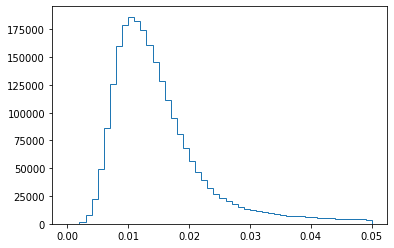

In [1015]:
_, _, _ = plt.hist(DF[DF.ntag==2].NN_weight_medianCR_x, bins = 50, histtype = 'step', range = (0, 0.05))

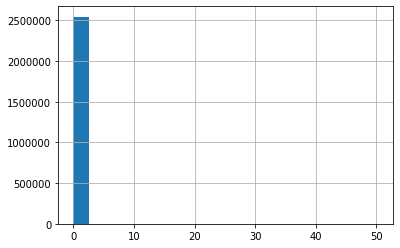

In [1014]:
DF[DF.ntag == 2].NN_weight_medianCR_x.hist(bins = 20)

In [1025]:
for columns in DF.columns:
    print(columns)

NN_weight_medianCR_x
event_number
run_number
mc_sf
ntag
njets
kinematic_region
m_min_dj
m_max_dj
pairing_score_1
pairing_score_2
m_hh_cor
m_hh
pt_hh
dEta_hh
X_wt
X_wt_2
m_h1
E_h1
pT_h1
eta_h1
phi_h1
m_h2
E_h2
pT_h2
eta_h2
phi_h2
m_h1_j1
E_h1_j1
pT_h1_j1
eta_h1_j1
phi_h1_j1
tag_h1_j1
quantile_h1_j1
angle_h1_j1
m_h1_j2
E_h1_j2
pT_h1_j2
eta_h1_j2
phi_h1_j2
tag_h1_j2
quantile_h1_j2
angle_h1_j2
m_h2_j1
E_h2_j1
pT_h2_j1
eta_h2_j1
phi_h2_j1
tag_h2_j1
quantile_h2_j1
angle_h2_j1
m_h2_j2
E_h2_j2
pT_h2_j2
eta_h2_j2
phi_h2_j2
tag_h2_j2
quantile_h2_j2
angle_h2_j2
pT_4
pT_2
eta_i
dRjj_1
dRjj_2
NN_d24_weight_bstrap_med_17
NN_d24_weight_VRderiv_bstrap_med_17
NN_d24_weight_bstrap_IQR_17
NN_d24_weight_VRderiv_bstrap_IQR_17
dPhi_h1
dPhi_h2
dR_hh
pT_2_log
pT_4_log
dRjj_1_log
dRjj_2_log
pt_hh_log
X_wt_log
NN_weightCR_bs_0
poisson_weight
NN_weightCR_bs_1
NN_weightCR_bs_2
NN_weight_medianCR_y
NN_weight_IQRCR
NN_weightVR_bs_0
NN_weight_medianVR
NN_weight_IQRVR
NN_weightCR_bs_0
NN_weightCR_bs_1
NN_weightCR_bs_

### Part 7: How well has the reweighting been done?

In [1057]:
muQCD_N = 1.0246290815738839 #got it from rootfile
muQCD_N_VR = 1.0321873105698995 #got it from rootfile too

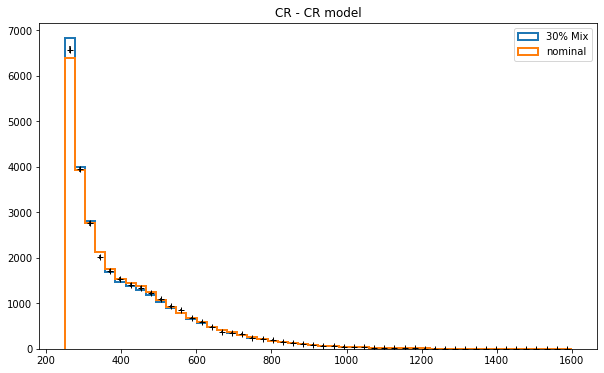

In [1071]:
fig = plt.figure(figsize=(10,6))
hCR4b, be = np.histogram(DF[(DF.ntag>=4) & (DF.kinematic_region == 2)].m_hh_cor, bins = 50, range=(250, 1600))
hCR4b_err = np.sqrt(hCR4b)
x = hh.bin_midpoint(be)
plt.errorbar(x, hCR4b, yerr = hCR4b_err, fmt = 'k+')
N4b = np.sum(hCR4b)
#N2b = DF[(DF.ntag == 2) & (DF.kinematic_region == 2)].N
#muQCD_M = np.median(muQCD_BS)
muQCD_M = N4b/(DF[(DF.ntag == 2) & (DF.kinematic_region == 2)].NN_weight_medianCR_x.sum())

hCR2b, _ , _ = plt.hist(DF[(DF.ntag==2) & (DF.kinematic_region == 2)].m_hh_cor, bins = be, 
                       weights = muQCD_M * DF[(DF.ntag == 2) & (DF.kinematic_region ==2)].NN_weight_medianCR_x,
                       histtype = 'step',
                       lw = 2,
                       label = '30% Mix')

#Nominal 


hCR2b_N, _, _ = plt.hist(df[(df.ntag == 2) & (df.kinematic_region == 2)].m_hh_cor, bins = be,
                        weights = muQCD_N * df[(df.ntag==2) &( df.kinematic_region==2)].NN_d24_weight_bstrap_med_17,
                        histtype = 'step',
                        lw = 2,
                        label ='nominal')
plt.title('CR - CR model')

chi2_N = u.chi2_unweighted(hCR2b_N, f4b)
chi2_M30 = u.chi2_unweighted(hCR2b, f4b)

plt.legend()

In [1072]:
print(chi2_N, chi2_M30)

(0.5580683463239012, 29, 1.0) (0.8820241400174076, 29, 1.0)


In [1073]:
muQCD_M

1.021217823634371

In [1074]:
muQCD_N

1.0246290815738839

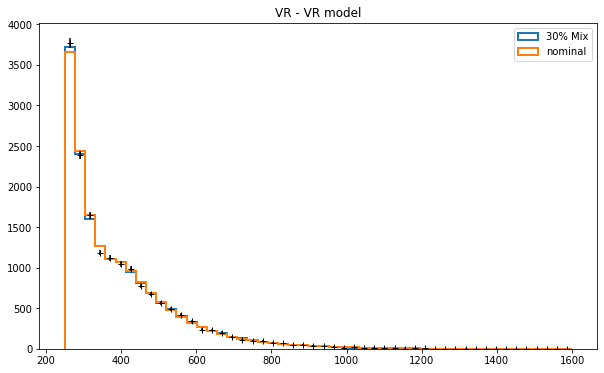

In [1069]:
fig = plt.figure(figsize=(10,6))
hVR4b, be = np.histogram(DF[(DF.ntag>=4) & (DF.kinematic_region == 1)].m_hh_cor, bins = 50, range=(250, 1600))
hVR4b_err = np.sqrt(hVR4b)
x = hh.bin_midpoint(be)
plt.errorbar(x, hVR4b, yerr = hVR4b_err, fmt = 'k+')
N4b = np.sum(hVR4b)
#N2b = DF[(DF.ntag == 2) & (DF.kinematic_region == 2)].N
muQCD_M_VR = np.median(muQCD_BSVR)

muQCD_M_VR = N4b/(DF[(DF.ntag==2) & (DF.kinematic_region == 1)].NN_weight_medianVR.sum())

hVR2b, _ , _ = plt.hist(DF[(DF.ntag==2) & (DF.kinematic_region == 1)].m_hh_cor, bins = be, 
                       weights = muQCD_M_VR * DF[(DF.ntag == 2) & (DF.kinematic_region ==1)].NN_weight_medianVR,
                       histtype = 'step',
                       lw = 2,
                       label = '30% Mix')

#Nominal 

hVR2b_N, _, _ = plt.hist(df[(df.ntag == 2) & (df.kinematic_region == 1)].m_hh_cor, bins = be,
                        weights = muQCD_N_VR * df[(df.ntag==2) & (df.kinematic_region==1)].NN_d24_weight_VRderiv_bstrap_med_17,
                        histtype = 'step',
                        lw = 2,
                        label ='nominal')
plt.title('VR - VR model')

chi2_N = u.chi2_unweighted(hVR2b_N, hVR4b)
chi2_M30 = u.chi2_unweighted(hVR2b, hVR4b)

plt.legend()

In [1067]:
muQCD_N_VR

1.0321873105698995

In [1068]:
muQCD_M_VR

1.1195095707752944

In [1070]:
print(chi2_N, chi2_M30)

(0.6069622311039302, 25, 0.9999999999999999) (0.5361804021260713, 25, 1.0)


In [1076]:
muQCD_M

1.9561387017237457

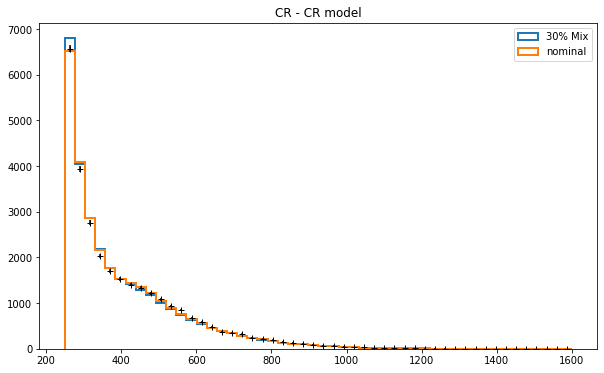

In [1077]:
fig = plt.figure(figsize=(10,6))
hCR4b, be = np.histogram(DF[(DF.ntag>=4) & (DF.kinematic_region == 2)].m_hh_cor, bins = 50, range=(250, 1600))
hCR4b_err = np.sqrt(hCR4b)
x = hh.bin_midpoint(be)
plt.errorbar(x, hCR4b, yerr = hCR4b_err, fmt = 'k+')
N4b = np.sum(hCR4b)

#N2b = DF[(DF.ntag == 2) & (DF.kinematic_region == 2)].N
#muQCD_M = np.median(muQCD_BS)

muQCD_M = N4b/(DF[(DF.ntag == 2) & (DF.kinematic_region == 2)].NN_weight_medianVR.sum())

hCR2b, _ , _ = plt.hist(DF[(DF.ntag==2) & (DF.kinematic_region == 2)].m_hh_cor, bins = be, 
                       weights = muQCD_M * DF[(DF.ntag == 2) & (DF.kinematic_region ==2)].NN_weight_medianVR,
                       histtype = 'step',
                       lw = 2,
                       label = '30% Mix')

#Nominal 


hCR2b_N, _, _ = plt.hist(df[(df.ntag == 2) & (df.kinematic_region == 2)].m_hh_cor, bins = be,
                        weights = muQCD_N_VR * df[(df.ntag==2) &( df.kinematic_region==2)].NN_d24_weight_VRderiv_bstrap_med_17,
                        histtype = 'step',
                        lw = 2,
                        label ='nominal')
plt.title('CR - VR model')

chi2_N = u.chi2_unweighted(hCR2b_N, f4b)
chi2_M30 = u.chi2_unweighted(hCR2b, f4b)

plt.legend()

In [1078]:
print(chi2_N, chi2_M30)

(1.0731487194752718, 29, 0.9999999999999998) (1.5903481252138219, 29, 0.9999999999999488)


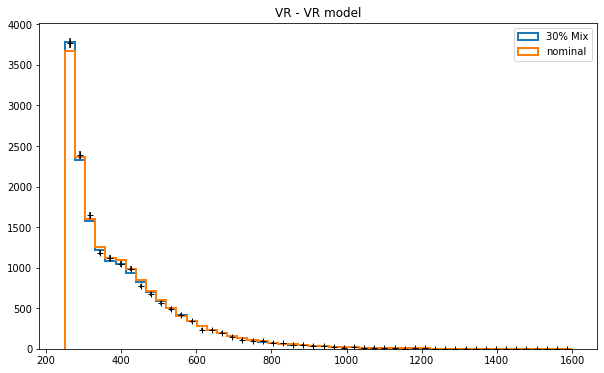

In [1079]:
fig = plt.figure(figsize=(10,6))
hVR4b, be = np.histogram(DF[(DF.ntag>=4) & (DF.kinematic_region == 1)].m_hh_cor, bins = 50, range=(250, 1600))
hVR4b_err = np.sqrt(hVR4b)
x = hh.bin_midpoint(be)
plt.errorbar(x, hVR4b, yerr = hVR4b_err, fmt = 'k+')
N4b = np.sum(hVR4b)
#N2b = DF[(DF.ntag == 2) & (DF.kinematic_region == 2)].N
muQCD_M_VR = np.median(muQCD_BSVR)

muQCD_M_VR = N4b/(DF[(DF.ntag==2) & (DF.kinematic_region == 1)].NN_weight_medianCR_x.sum())

hVR2b, _ , _ = plt.hist(DF[(DF.ntag==2) & (DF.kinematic_region == 1)].m_hh_cor, bins = be, 
                       weights = muQCD_M_VR * DF[(DF.ntag == 2) & (DF.kinematic_region ==1)].NN_weight_medianCR_x,
                       histtype = 'step',
                       lw = 2,
                       label = '30% Mix')

#Nominal 

hVR2b_N, _, _ = plt.hist(df[(df.ntag == 2) & (df.kinematic_region == 1)].m_hh_cor, bins = be,
                        weights = muQCD_N_VR * df[(df.ntag==2) & (df.kinematic_region==1)].NN_d24_weight_bstrap_med_17,
                        histtype = 'step',
                        lw = 2,
                        label ='nominal')
plt.title('VR - VR model')

chi2_N = u.chi2_unweighted(hVR2b_N, hVR4b)
chi2_M30 = u.chi2_unweighted(hVR2b, hVR4b)

plt.legend()

In [1080]:
print(chi2_N, chi2_M30)

(0.7548113955260397, 26, 0.9999999999999997) (0.6674838790458711, 25, 0.9999999999999996)


### part 7.2 : OK shape systematics

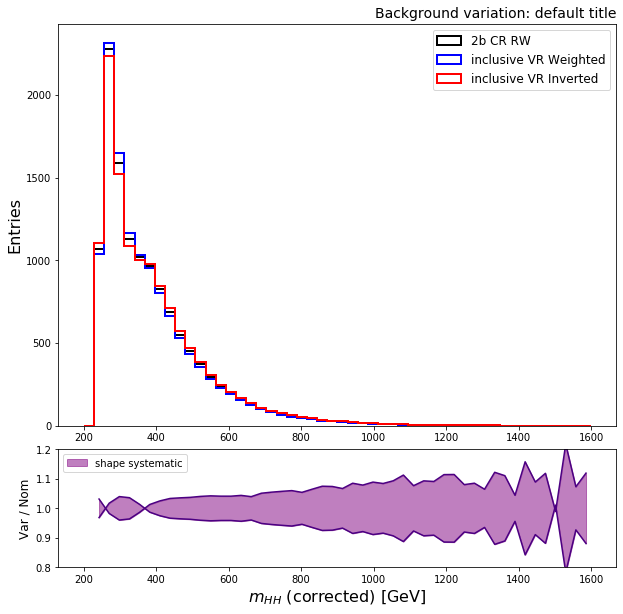

In [1085]:
var = bh.shape_variations_inclusive(df, CR_weights = 'NN_d24_weight_bstrap_med_17',
                             VR_weights = 'NN_d24_weight_VRderiv_bstrap_med_17',
                             muCR = muQCD_N,
                             muVR = muQCD_N_VR,
                             ylims = (0.8, 1.2))

../../eda_tools/bkg_helper.py:257: RuntimeWarning: invalid value encountered in true_divide
  ax2.fill_between(x, (h_err_total + cr)/cr, (cr - h_err_total)/cr, alpha = 0.5, color = 'grey', label = 'shape+boots')
../../eda_tools/bkg_helper.py:258: RuntimeWarning: invalid value encountered in true_divide
  #total_b1 = np.sqrt(((vr/cr)**2) + ((cr_error/cr)**2))
../../eda_tools/bkg_helper.py:259: RuntimeWarning: invalid value encountered in true_divide
  #total_b2 = np.sqrt(((inv/cr)**2) + ((cr_error/cr)**2))


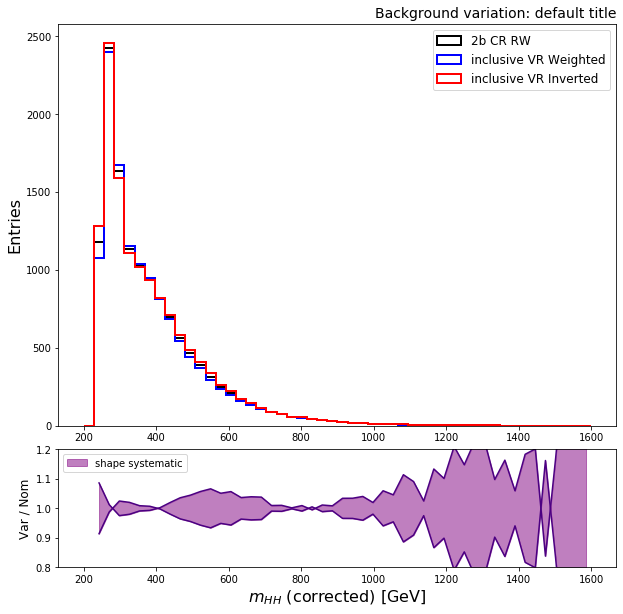

In [1088]:
varM = bh.shape_variations_inclusive(DF, CR_weights = 'NN_weight_medianCR_x',
                             VR_weights = 'NN_weight_medianVR',
                             ylims = (0.8, 1.2))

In [1089]:
DF.columns

Index(['NN_weight_medianCR_x', 'event_number', 'run_number', 'mc_sf', 'ntag',
       'njets', 'kinematic_region', 'm_min_dj', 'm_max_dj', 'pairing_score_1',
       ...
       'NN_weightVR_bs_90', 'NN_weightVR_bs_91', 'NN_weightVR_bs_92',
       'NN_weightVR_bs_93', 'NN_weightVR_bs_94', 'NN_weightVR_bs_95',
       'NN_weightVR_bs_96', 'NN_weightVR_bs_97', 'NN_weightVR_bs_98',
       'NN_weightVR_bs_99'],
      dtype='object', length=287)

In [ ]:
DF.NN_w

In [1090]:
CRBScolumns = []
for i in range(100):
    CRBScolumns.append('NN_weightCR_bs_' + str(i))

../../eda_tools/bkg_helper.py:257: RuntimeWarning: invalid value encountered in true_divide
  ax2.fill_between(x, (h_err_total + cr)/cr, (cr - h_err_total)/cr, alpha = 0.5, color = 'grey', label = 'shape+boots')
../../eda_tools/bkg_helper.py:258: RuntimeWarning: invalid value encountered in true_divide
  #total_b1 = np.sqrt(((vr/cr)**2) + ((cr_error/cr)**2))
../../eda_tools/bkg_helper.py:259: RuntimeWarning: invalid value encountered in true_divide
  #total_b2 = np.sqrt(((inv/cr)**2) + ((cr_error/cr)**2))
../../eda_tools/bkg_helper.py:263: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(x, inv/cr, marker ='.', color = 'red', linestyle = 'None')


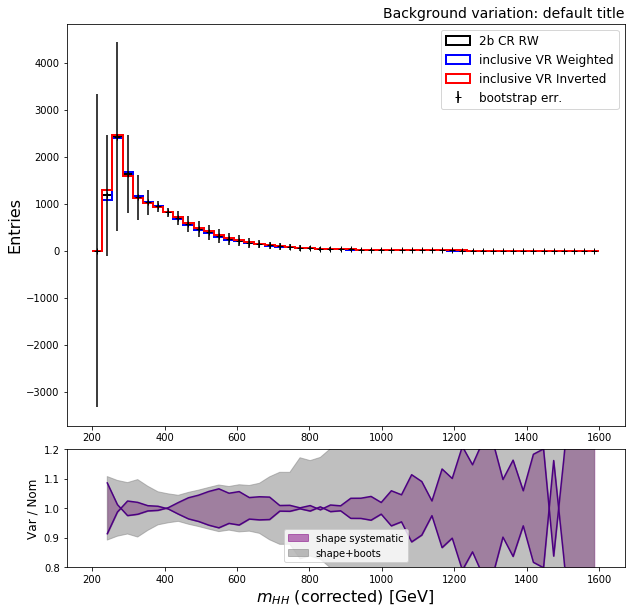

In [1091]:
varMB = bh.shape_variations_inclusive(DF, CR_weights = 'NN_weight_medianCR_x',
                             VR_weights = 'NN_weight_medianVR',
                             bootstraps_columns= CRBScolumns,
                             ylims = (0.8, 1.2))

In [1094]:
crN = var['cr']
vrN = var['vr']
invN = var['inv']
nbins =var['bins']

xb = hh.bin_midpoint(nbins)

In [1098]:
crM = varM['cr']
vrM = varM['vr']
invM = varM['inv']


/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


Text(0.5, 1.0, 'Shape Systematic comparison')

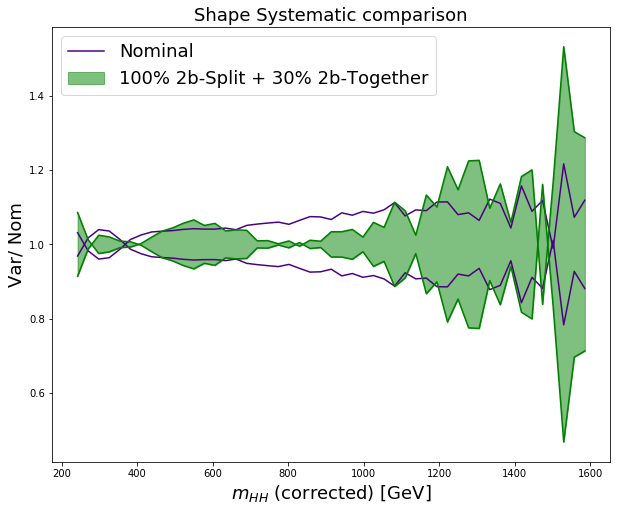

In [1113]:
fig = plt.figure(figsize=(10, 8))
plt.plot(xb, vrN/crN, '-', color = 'indigo')
plt.plot(xb, invN/crN,'-', color ='indigo', label = 'Nominal')
plt.plot(xb, vrM/crM, '-', color = 'green')
plt.plot(xb, invM/crM, '-', color = 'green')
plt.fill_between(xb, vrM/crM, invM/crM, alpha = 0.5, color = 'green', 
                label ='100% 2b-Split + 30% 2b-Together')
plt.legend(fontsize = 18)
plt.xlabel('$m_{HH}$ (corrected) [GeV]', fontsize = 18)
plt.ylabel('Var/ Nom', fontsize = 18)
plt.title('Shape Systematic comparison', fontsize = 18)

In [ ]:
plt.plot(xb, vrN/crN)
plt.plot(xb, vr)

/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Shape Systematic comparison: Percentage difference')

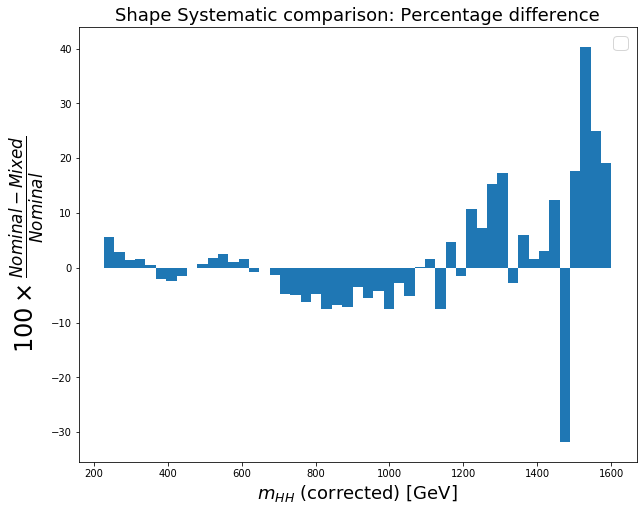

In [1121]:
fig = plt.figure(figsize=(10, 8))
SN = vrN/crN
SM = vrM/crM

pdiff = 100 * ((SN-SM)/SN)

#plt.plot(xb, pdiff)
width = xb[1] - xb[0]

plt.bar(xb, pdiff, width=width)

plt.legend(fontsize = 18)
plt.xlabel('$m_{HH}$ (corrected) [GeV]', fontsize = 18)
plt.ylabel('$100 \\times \\frac{Nominal - Mixed}{Nominal}$', fontsize = 24)
plt.title('Shape Systematic comparison: Percentage difference', fontsize = 18)

### Trying out to get the bootstraps

In [1138]:
CR2b = df.loc[(df.ntag == 2) & (df.kinematic_region == 2)]
N4b = len(df.loc[(df.ntag >= 4) & (df.kinematic_region == 2)])

Wmedian = CR2b['NN_d24_weight_bstrap_med_17'].values 

#Wmedian = np.median(W, axis = 1)

#norms = N4b / np.sum(W, axis = 0)

#norms_IQR = np.subtract(*np.percentile(norms, [75, 25]))
norms_IQR = 0.05801486095407227

muQCDmedian = 1.0246290815738839

#W_IQR = np.subtract(*np.percentile(W, [75, 25], axis = 1))

W_IQR = CR2b['NN_d24_weight_bstrap_IQR_17'].values

w1 = muQCDmedian * Wmedian

h1, _ = np.histogram(CR2b.m_hh_cor, bins = be, range = hrange, weights = w1) # Step 1
w2 = w1 + 0.5 * W_IQR
h2, _ = np.histogram(CR2b.m_hh_cor, bins = be, range = hrange, weights = w2) # Step 2
w3 = w2 * (sum(h1)/ sum(h2))
h3, _ = np.histogram(CR2b.m_hh_cor, bins = be, range = hrange, weights = w3) # Step 3
w4 = w1 * 0.5 * norms_IQR
h4, _ = np.histogram(CR2b.m_hh_cor, bins = be, range = hrange, weights = w4) # Step 4
w5 = w4 + w3
h5, _ = np.histogram(CR2b.m_hh_cor, bins = be, range = hrange, weights = w5) # Step 5 (upper bound)

err_mag = w5 - w1
w6 = w1 - err_mag
h6, _ = np.histogram(CR2b.m_hh_cor, bins = be, weights = w6) # Step 6 (lower bound)

h_err_bs_mag, _ = np.histogram(CR2b.m_hh_cor, weights = err_mag, bins = be, range = hrange)
results = {}

results['lowerBound'] = h6
results['upperBound'] = h5
results['variation'] = err_mag
results['hist_var'] = h5-h6
results['h_err_bs_mag'] = h_err_bs_mag

In [1125]:
results['h_err_bs_mag']

array([2.02260604e+02, 1.16157638e+02, 9.81840809e+01, 7.44371946e+01,
       5.49961136e+01, 4.21965657e+01, 3.35539415e+01, 2.81173000e+01,
       2.46102408e+01, 2.07125088e+01, 1.83932672e+01, 1.65438729e+01,
       1.47934188e+01, 1.31093816e+01, 1.15488739e+01, 1.05649235e+01,
       9.82568592e+00, 9.20060502e+00, 7.53422934e+00, 7.41538475e+00,
       6.36465866e+00, 5.61691233e+00, 4.92414058e+00, 4.58316653e+00,
       4.01709566e+00, 3.21728119e+00, 2.99315015e+00, 2.44346973e+00,
       2.22036384e+00, 1.80242910e+00, 1.46981468e+00, 1.24702528e+00,
       9.61729008e-01, 7.37482549e-01, 6.73388346e-01, 5.58200635e-01,
       3.99105235e-01, 2.84946789e-01, 3.05980186e-01, 1.94096985e-01,
       1.24013899e-01, 1.25040073e-01, 9.51629533e-02, 5.37996798e-02,
       4.32030694e-02, 4.24855126e-02, 2.72677604e-02, 1.24415000e-02,
       1.45101214e-02, 7.13898085e-03])

/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


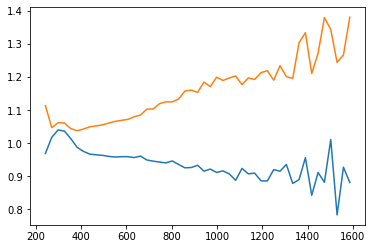

In [1143]:
plt.plot(xb, vrN/crN)
h_err_totalN = np.sqrt((results['h_err_bs_mag'])**2 + ((vrN-crN)**2))
plt.plot(xb, (h_err_total+crN)/crN)

/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


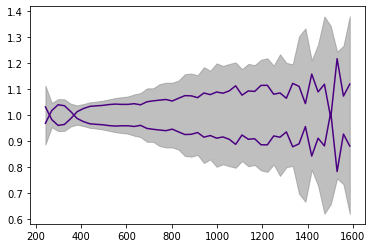

In [1144]:
plt.plot(xb, vrN/crN, xb, invN/crN, color ='indigo')
plt.fill_between(xb, (h_err_totalN + crN)/crN, (crN - h_err_totalN)/crN, alpha = 0.5, color = 'grey', label = 'shape+boots')


In [1135]:
weight_columns = []
for i in range(100):
    weight_columns.append('NN_weightCR_bs_' + str(i))

In [1139]:
CR2b = DF.loc[(DF.ntag == 2) & (DF.kinematic_region == 2)]
N4b = len(DF.loc[(DF.ntag >= 4) & (DF.kinematic_region == 2)])


Wmedian = CR2b['NN_weight_medianCR'].values 

W = CR2b[weight_columns].values

#Wmedian = np.median(W, axis = 1)

norms = N4b / np.sum(W, axis = 0)

norms_IQR = np.subtract(*np.percentile(norms, [75, 25]))
#norms_IQR = 0.05801486095407227

muQCDmedian = N4b / sum(Wmedian)

#W_IQR = np.subtract(*np.percentile(W, [75, 25], axis = 1))

W_IQR = CR2b['NN_weight_IQRCR'].values

w1 = muQCDmedian * Wmedian

h1, _ = np.histogram(CR2b.m_hh_cor, bins = be, range = hrange, weights = w1) # Step 1
w2 = w1 + 0.5 * W_IQR
h2, _ = np.histogram(CR2b.m_hh_cor, bins = be, range = hrange, weights = w2) # Step 2
w3 = w2 * (sum(h1)/ sum(h2))
h3, _ = np.histogram(CR2b.m_hh_cor, bins = be, range = hrange, weights = w3) # Step 3
w4 = w1 * 0.5 * norms_IQR
h4, _ = np.histogram(CR2b.m_hh_cor, bins = be, range = hrange, weights = w4) # Step 4
w5 = w4 + w3
h5, _ = np.histogram(CR2b.m_hh_cor, bins = be, range = hrange, weights = w5) # Step 5 (upper bound)

err_mag = w5 - w1
w6 = w1 - err_mag
h6, _ = np.histogram(CR2b.m_hh_cor, bins = be, weights = w6) # Step 6 (lower bound)

h_err_bs_mag, _ = np.histogram(CR2b.m_hh_cor, weights = err_mag, bins = be, range = hrange)
resultsM = {}

resultsM['lowerBound'] = h6
resultsM['upperBound'] = h5
resultsM['variation'] = err_mag
resultsM['hist_var'] = h5-h6
resultsM['h_err_bs_mag'] = h_err_bs_mag

In [1141]:
resultsM['h_err_bs_mag']

array([2.65353634e+02, 1.33886425e+02, 1.16054764e+02, 8.38938168e+01,
       5.69563017e+01, 4.47369848e+01, 3.03743016e+01, 2.33650591e+01,
       2.19124729e+01, 1.64870173e+01, 1.40631298e+01, 1.33002819e+01,
       1.20612525e+01, 1.13066928e+01, 1.06281065e+01, 1.01722037e+01,
       1.03223863e+01, 1.03745982e+01, 8.31960035e+00, 9.48921886e+00,
       7.94586258e+00, 6.80347897e+00, 6.34265623e+00, 6.52542391e+00,
       5.43422663e+00, 4.23107636e+00, 4.42296724e+00, 3.62948758e+00,
       3.01370319e+00, 2.58192855e+00, 2.34196443e+00, 1.84272477e+00,
       1.51622473e+00, 1.14104019e+00, 1.23620218e+00, 8.80025512e-01,
       6.16912535e-01, 4.54769883e-01, 6.52195599e-01, 2.73846538e-01,
       2.04849685e-01, 1.73267394e-01, 1.74378752e-01, 9.09363501e-02,
       9.04951728e-02, 4.91743785e-02, 7.60198202e-02, 3.27704949e-02,
       1.57063029e-02, 1.42482415e-02])

/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


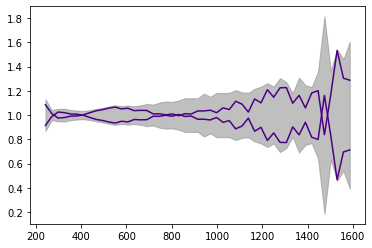

In [1142]:
plt.plot(xb, vrM/crM, xb, invM/crM, color ='indigo')
h_err_totalM = np.sqrt((results['h_err_bs_mag'])**2 + ((vrM-crM)**2))



plt.fill_between(xb, (h_err_totalM + crM)/crM, (crM - h_err_totalM)/crM, alpha = 0.5, color = 'grey', label = 'shape+boots')



/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


Text(0.5, 1.0, 'Shape Systematics + Bootstrap error')

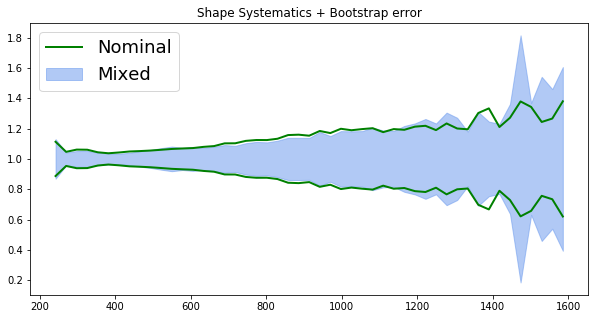

In [1154]:
fig = plt.figure(figsize = (10,5))
plt.plot(xb, (h_err_totalN + crN)/crN, color = 'green', lw = 2)
plt.plot(xb, (crN - h_err_totalN)/crN, color = 'green', lw = 2, label = 'Nominal')


plt.fill_between(xb, (h_err_totalM + crM)/crM, (crM - h_err_totalM)/crM, alpha = 0.5, color = 'cornflowerblue', label = 'Mixed')
plt.legend(loc='upper left', fontsize = 18)
plt.title('Shape Systematics + Bootstrap error')



In [1123]:
for columns in df.columns:
    print(columns)

run_number
event_number
mc_sf
ntag
njets
kinematic_region
m_min_dj
m_max_dj
pairing_score_1
pairing_score_2
m_hh_cor
m_hh
pt_hh
dEta_hh
X_wt
X_wt_2
m_h1
E_h1
pT_h1
eta_h1
phi_h1
m_h2
E_h2
pT_h2
eta_h2
phi_h2
m_h1_j1
E_h1_j1
pT_h1_j1
eta_h1_j1
phi_h1_j1
tag_h1_j1
quantile_h1_j1
angle_h1_j1
m_h1_j2
E_h1_j2
pT_h1_j2
eta_h1_j2
phi_h1_j2
tag_h1_j2
quantile_h1_j2
angle_h1_j2
m_h2_j1
E_h2_j1
pT_h2_j1
eta_h2_j1
phi_h2_j1
tag_h2_j1
quantile_h2_j1
angle_h2_j1
m_h2_j2
E_h2_j2
pT_h2_j2
eta_h2_j2
phi_h2_j2
tag_h2_j2
quantile_h2_j2
angle_h2_j2
pT_4
pT_2
eta_i
dRjj_1
dRjj_2
NN_d24_weight_bstrap_med_17
NN_d24_weight_VRderiv_bstrap_med_17
NN_d24_weight_bstrap_IQR_17
NN_d24_weight_VRderiv_bstrap_IQR_17
dPhi_h1
dPhi_h2
dR_hh


In [1]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           125G         65G         59G         41M        613M         59G
Swap:           15G         15G        312K


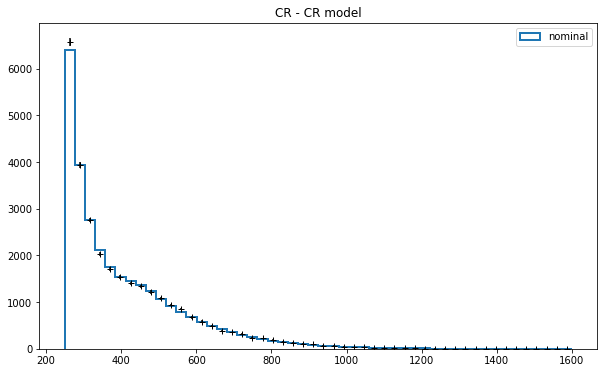

In [1052]:
fig = plt.figure(figsize=(10,6))
h4b, be = np.histogram(DF[(DF.ntag>=4) & (DF.kinematic_region == 2)].m_hh_cor, bins = 50, range=(250, 1600))
h4b_err = np.sqrt(h4b)
x = hh.bin_midpoint(be)
plt.errorbar(x, h4b, yerr = h4b_err, fmt = 'k+')
N4b = np.sum(h4b)

muQCD = 1.0246290815738839

h2b, _, _ = plt.hist(df[(df.ntag == 2) & (df.kinematic_region == 2)].m_hh_cor, bins = be,
                        weights = muQCD * df[(df.ntag==2) &(df.kinematic_region==2)].NN_d24_weight_bstrap_med_17,
                        histtype = 'step',
                        lw = 2,
                        label ='nominal')
plt.title('CR - CR model')

chi2_N = u.chi2_unweighted(h2b, h4b)

plt.legend()

# Part 8 - Exploring the Massplanes

In [ ]:
ph.massplane(df[df.ntag==2], df[df.ntag==2])

# DEBUG - 1: $\chi^2$ metric

In [985]:
df4b.head() #4b
dfCR2b #2b
dfS #2b Split 
dfT #2b Together

run_number  event_number  mc_sf  ntag  njets  kinematic_region  \
entry                                                                     
6            326468     120622018    1.0     2      4                 1   
8            326468     122327110    1.0     2      4                 0   
9            326468     111764957    1.0     2      6                 0   
11           326468     114693480    1.0     2      4                 2   
12           326468     113641275    1.0     2      4                 0   
...             ...           ...    ...   ...    ...               ...   
3910070      338987    1240391346    1.0     2      4                 2   
3910076      338987    1164816147    1.0     2      4                 2   
3910077      338987    1165168820    1.0     2      4                 1   
3910082      338987    1154639029    1.0     2      5                 0   
3910084      338987    1154231040    1.0     2      4                 0   

           m_min_dj    m_max_dj  pairing_score_1  pairing_score_2  ...  \
entry                                                              ...   
6         51.621985  153.301291         0.542750         0.519563  ...   
8         56.590643  137.155425         0.550896         0.013660  ...   
9        102.014907  209.503584         0.960571         0.070902  ...   
11       100.962650  217.681681         0.689516         0.379965  ...   
12        41.727889  166.198747         0.580349         0.454685  ...   
...             ...         ...              ...              ...  ...   
3910070   66.110130  172.889470         0.661635         0.233860  ...   
3910076  123.911539  215.412253         0.499604         0.402881  ...   
3910077  100.083154  218.910322         0.993656         0.028584  ...   
3910082  117.543440  419.783012         0.999665         0.001360  ...   
3910084   91.953854  154.448946         0.658591         0.531038  ...   

            eta_i    dRjj_1    dRjj_2  NN_d24_weight_bstrap_med_17  \
entry                                                                
6        1.503408  1.106467  2.042072                     0.007751   
8        0.942756  0.596690  2.884907                     0.006260   
9        1.114849  1.321716  1.535449                     0.068426   
11       0.769576  1.561473  2.338913                     0.009027   
12       1.278836  0.708099  0.925505                     0.014647   
...           ...       ...       ...                          ...   
3910070  0.632978  0.929100  1.807013                     0.008530   
3910076  1.243526  1.689016  2.046301                     0.009524   
3910077  0.475093  1.020909  1.161776                     0.009721   
3910082  0.779425  0.780242  1.166528                     0.014014   
3910084  0.464586  1.471647  1.600451                     0.011774   

         NN_d24_weight_VRderiv_bstrap_med_17  NN_d24_weight_bstrap_IQR_17  \
entry                                                                       
6                                   0.007365                     0.002107   
8                                   0.007539                     0.002170   
9                                   0.062673                     0.022828   
11                                  0.007867                     0.001894   
12                                  0.014049                     0.002672   
...                                      ...                          ...   
3910070                             0.008596                     0.003856   
3910076                             0.008284                     0.002320   
3910077                             0.008356                     0.003567   
3910082                             0.013004                     0.004314   
3910084                             0.009216                     0.002957   

         NN_d24_weight_VRderiv_bstrap_IQR_17   dPhi_h1   dPhi_h2     dR_hh  
entry                                                                       
6  

In [986]:
sum(f4b)

29638

In [987]:
len(df4b)

434193

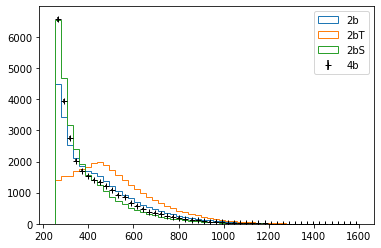

In [233]:
f4b, be = np.histogram(df4b.m_hh_cor, bins = 50, range = (250, 1600))
f4b_err = np.sqrt(f4b)
x = hh.bin_midpoint(be)
plt.errorbar(x, f4b, yerr = f4b_err, fmt = '+k', label = '4b')
N4b = sum(f4b)
mu = N4b/ len(dfCR2b)

h2b, _, _ = plt.hist(dfCR2b.m_hh_cor, bins = be,
                     weights = mu * np.ones(len(dfCR2b)),
                     range = (250, 1600), histtype = 'step',
                    label = '2b')

muT = N4b/len(dfT)
h2bT, _, _ = plt.hist(dfT.m_hh_cor, bins = be,
                      histtype = 'step', weights =  muT * np.ones(len(dfT)),
                      label = '2bT')
muS = N4b/len(dfS)
h2bS, _, _ = plt.hist(dfS.m_hh_cor, bins = be,
                    histtype = 'step', weights = muS * np.ones(len(dfS)),
                      label = '2bS')

plt.legend()

Let's say that these are 2 unweighted histograms (although we scaled h2b)

In [227]:
M = np.sum(f4b)
N = np.sum(h2b)

In [228]:
chi2_1 = (1/(M*N)) * np.sum(((M*h2b - N*f4b)**2)/(h2b+f4b))

In [230]:
chi2_1 / (len(f4b) - 1)

15.443583425473705

In [234]:
Nt = np.sum(h2bT)
Ns = np.sum(h2bS)

29636.88554449641

In [242]:
chi2_1T = (1/(M*Nt)) * np.sum(((M*h2bT - Nt*f4b)**2)/(h2bT+f4b))

In [247]:
chi2_1T/(len(f4b) - 1)

153.65527159697703

In [244]:
chi2_1S = (1/(M*Ns)) * np.sum(((M*h2bS - Ns*f4b)**2)/(h2bS+f4b))

In [246]:
chi2_1S/(len(f4b) -1)

7.368096023318322

These are actually reasonable results.... But let's exclude bins that have less than 25 counts as recommended by the paper

In [250]:
h2b>25

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [251]:
f4b>25

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [252]:
(f4b>25) & (h2b>25)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [253]:
f4b[(f4b>25) & (h2b>25)]

array([6569, 3940, 2757, 2024, 1704, 1532, 1402, 1337, 1217, 1086,  938,
        851,  672,  584,  478,  375,  351,  324,  240,  221,  192,  151,
        132,  109,   93,   66,   66,   48,   29,   36])

In [257]:
def chi2_1(h1, h2):
    
    #Cut events with an event yield lower than 25 as the paper recommends
    H1 = h1[(h1>25) & (h2>25)]
    H2 = h2[(h1>25) & (h2>25)]
    
    N = np.sum(H1)
    M = np.sum(H2)
    
    chi2_1 = (1/(M*N)) * np.sum(((M*H1 - N*H2)**2)/(H2+H1))
    
    ndf = len(H1) - 1
    
    return chi2_1/ndf
    
    
    
    

In [258]:
chi2_1(h2b, f4b)

25.013392706630796

In [259]:
chi2_1(h2bT, f4b)

255.68281769328533

In [260]:
chi2_1(h2bS, f4b)

12.086985591669416

In [326]:
u.chi2_unweighted(h2bS, f4b)

(12.086985591669416, 29, 0.9975750302565793)

In [286]:
from scipy.stats import chi2

In [323]:
chi2.sf(20, 50)

0.9999530506185732

In [324]:
r = chi2.rvs(50, size = 100000)

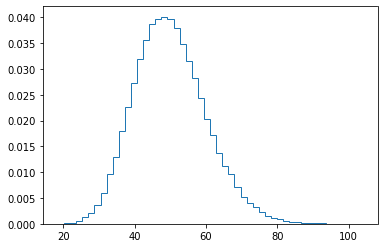

In [325]:
_, _, _ = plt.hist(r, bins = 50, density = 1, histtype = 'step')


In [261]:
def chi2_2(ni, wi, si):
    
    #Cut events with an event yield lower than 25 as the paper recommends
    Ni = ni[(ni>25) & (wi>25)]
    Wi = wi[(ni>25) & (wi>25)]
    Si = si[(ni>25) & (wi>25)]
    
    N = np.sum(Ni)
    W = np.sum(Wi)
    
    
    
    a = W*Wi - N*Si**2 + np.sqrt(((W*Wi - N * Si**2)**2)+4*W*W*(Si**2)*Ni)
    b = 2*W**2
    
    pi = a/b
    
    c = np.sum(((Ni - N*pi)**2)/(N*pi))
    
    d = np.sum(((Wi - W*pi)**2)/(Si**2))
    
    chi2_2 = c+d
    
    ndf = len(Ni) - 1
    
    return chi2_2/ndf

In [270]:
si = u.weighted_histo_error(dfCR2b.m_hh_cor.values, mu*np.ones(len(dfCR2b)), be)

In [275]:
chi2_2(f4b, h2b, si)

52.61164446935725

In [276]:
si = u.weighted_histo_error(dfT.m_hh_cor.values, muT*np.ones(len(dfT)), be)

In [277]:
chi2_2(f4b, h2bT, si)

836.0642476271803

In [278]:
si = u.weighted_histo_error(dfS.m_hh_cor.values, muS * np.ones(len(dfS)), be)

In [279]:
chi2_2(f4b, h2bS, si)

24.717839630256236

In [280]:
chi2_2(h2bS, f4b, f4b_err)

11.90595863593035

In [281]:
chi2_2(h2bT, f4b, f4b_err)

253.7232835036748

In [282]:
chi2_2(h2b, f4b, f4b_err)

24.882547621216016

In [ ]:
def weighted_chisquare(f_obs, f_exp, f_obs_err, f_exp_err):
    from scipy.stats import chi2
    #Calculate weighted chi-square using method in arXiv:physics/0605123
    w1 = f_obs
    w2 = f_exp
    s1 = f_obs_err  # noqa
    s2 = f_exp_err  # noqa
    W1 = np.sum(w1)  # noqa
    W2 = np.sum(w2)  # noqa
    R = (W1*w2 - W2*w1)**2 / (W1**2 * s2**2 + W2**2 + s1**2)
    R = np.where(((np.isnan(R)) | (np.isinf(R))), 0, R)
    #X2 = np.sum((W1*w2 - W2*w1)**2 / (W1**2 * s2**2 + W2**2 * s1**2))
    X2 = np.sum(R)            
    p = chi2.sf(X2, np.size(w1) - 1)
    #p = 1
    return (X2, p)

In [1163]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           125G        116G        7.4G         45M        2.0G        7.9G
Swap:           15G         15G        821M
